# I. Mirror number classification
### 1) MLP (multilayer perceptron) network

*Based on: https://machinelearningmastery.com/tutorial-first-neural-network-python-keras/*

Here we implement our first ML model for the basic task of classifying the number of mirrors in the system, based on the interference pattern. We start with a simple deep neural network - an MLP - which consists of several fully connected layers. 

In [1]:
# necessary imports

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from numpy import loadtxt
import numpy as np
import matplotlib.pyplot as plt

The input data is in the form of a CSV file, where each row has numbers separated by commas. The first value signifies the number of mirrors present in the system; subsequent numbers are the values of total transmittance for equally spaced wavenumbers k. The number of k values is constant through all the rows and depends on the generated data - the more k values, the more dense the probing of the k-space.

Let us load the dataset and visualize some interference pattern.

In [2]:
dataset = loadtxt('data50_2.csv', delimiter=',', skiprows=1)

# number of k samples
k_samples = 50

# number of classes (of mirror numbers)
num_classes = 8

# list of class labels
classes = [f'{class_id}' for class_id in range(3, 11)]

# mirror numbers (the correct classes) in the first column
y = dataset[:,0]

# convenient to have the classes starting from 0, so just subtract 3 from every y
y -= 3

# transmittance values
X = dataset[:,1:]

This dataset we normalize by the maximal values of each sample.

In [3]:
X = X / np.max(X, axis = 1, keepdims = True)

Example plot:

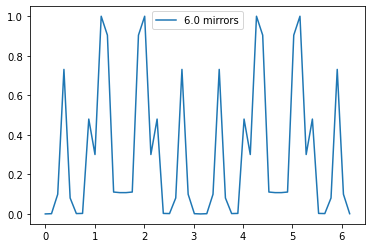

In [4]:
# k-space for plotting
kmin = 0
kmax = 2 * np.pi
ks = np.linspace(kmin, kmax, k_samples, endpoint = False)

which_row = 42200

plt.figure()
plt.plot(ks, X[which_row], label=f'{y[which_row]+3} mirrors')
plt.legend(loc='best')
plt.show()

We will now split the dataset randomly into the training and test parts, borrowing a function from the scikit-learn package.

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify = y, 
                                                    test_size = 0.25,
                                                    random_state = 42)

# the 'stratify = y' argument ensures that the training and testing sets contain the same proportion of each class
# we especially need to watch out for this for the lowest number of mirrors 
# which forms a tiny proportion of the whole dataset:

print('Proportion of 3-mirror elements in the testing set:', list(y_test).count(0) / len(y_test))
print('Proportion of 3-mirror elements in the testing set:', list(y_train).count(0) / len(y_train))

MemoryError: Unable to allocate 176. MiB for an array with shape (462341, 50) and data type float64

Checks out. Let us build the network now (with the sizes of hidden layers chosen arbitrarily).

In [ ]:
# Define the model
model = Sequential()
model.add(Dense(24, input_dim=k_samples, activation='relu'))
model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='sigmoid'))

# The last layer consists of 8 nodes as we generated the data for 3 to 10 mirrors.

We shall define metrics to gauge the performance of our model using a useful function from the sklearn module. To have it evaluated after each epoch of the training, we will wrap it in a Keras callback. This callback will evaluate the classification report and log it to a log dictionary.

In [ ]:
from sklearn.metrics import classification_report

classification_report_log_dict = {**{f'{class_id}' : {'precision': [], 'recall': [], 'f1-score': []} 
                                  for class_id in range(3, 11)}, **{'accuracy': [], 
                                        'macro avg': {'precision': [], 'recall': [], 'f1-score': []},
                                        'weighted avg': {'precision': [], 'recall': [], 'f1-score': []}}}


class PerformanceEvaluationCallback(keras.callbacks.Callback):
    def __init__(self, x_test, y_test):
        self.x_test = x_test
        self.y_test = y_test
        
    def on_epoch_end(self, epoch, logs=None):
        print('Evaluating the model...', end = ' ')
        y_pred = self.model.predict(self.x_test, verbose=0, batch_size = len(self.x_test))
        y_pred = np.argmax(y_pred, axis = 1)
        report = classification_report(self.y_test, y_pred, 
                              target_names = ['3','4','5','6','7','8','9','10'], output_dict = True)
        for class_id in classes + ['macro avg', 'weighted avg']:
            classification_report_log_dict[class_id]['precision'].append(report[class_id]['precision'])
            classification_report_log_dict[class_id]['recall'].append(report[class_id]['recall'])
            classification_report_log_dict[class_id]['f1-score'].append(report[class_id]['f1-score'])
        
        classification_report_log_dict['accuracy'].append(report['accuracy'])
        print(f"Accuracy: {report['accuracy']}")
        
        
performance_callback = PerformanceEvaluationCallback(X_test, y_test)

Now we compile.

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', run_eagerly = 1)

Set necessary prerequisites and train, using the testing data for validation.

In [9]:
epochs = 500
batch_size = 64

callbacks = [
    performance_callback,
    
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

history = model.fit(
    X_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/500
7225/7225 [==============================] - 85s 12ms/step - loss: 1.3541 - val_loss: 1.2376
Evaluating the model... Accuracy: 0.4360538302814799
Epoch 2/500
7225/7225 [==============================] - 82s 11ms/step - loss: 1.1621 - val_loss: 1.0935
Evaluating the model... Accuracy: 0.49731367688853706
Epoch 3/500
7225/7225 [==============================] - 83s 11ms/step - loss: 1.0456 - val_loss: 0.9905
Evaluating the model... Accuracy: 0.550462644535863
Epoch 4/500
7225/7225 [==============================] - 86s 12ms/step - loss: 0.9738 - val_loss: 0.9398
Evaluating the model... Accuracy: 0.5752105584177947
Epoch 5/500
7225/7225 [==============================] - 83s 11ms/step - loss: 0.9221 - val_loss: 0.9239
Evaluating the model... Accuracy: 0.5782926924224925
Epoch 6/500
7225/7225 [==============================] - 87s 12ms/step - loss: 0.8809 - val_loss: 0.8634
Evaluating the model... Accuracy: 0.5970450445773907
Epoch 7/500
7225/7225 [=============================

7225/7225 [==============================] - 95s 13ms/step - loss: 0.3692 - val_loss: 0.3544
Evaluating the model... Accuracy: 0.8153250191416743
Epoch 104/500
7225/7225 [==============================] - 95s 13ms/step - loss: 0.3676 - val_loss: 0.4104
Evaluating the model... Accuracy: 0.7839326732159311
Epoch 105/500
7225/7225 [==============================] - 96s 13ms/step - loss: 0.3648 - val_loss: 0.3831
Evaluating the model... Accuracy: 0.7980261364963598
Epoch 106/500
7225/7225 [==============================] - 96s 13ms/step - loss: 0.3644 - val_loss: 0.4153
Evaluating the model... Accuracy: 0.7655047562194219
Epoch 107/500
7225/7225 [==============================] - 96s 13ms/step - loss: 0.3622 - val_loss: 0.5407
Evaluating the model... Accuracy: 0.7219331144477464
Epoch 108/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.3613 - val_loss: 0.3548
Evaluating the model... Accuracy: 0.8093164800083056
Epoch 109/500
7225/7225 [=============================

7225/7225 [==============================] - 97s 13ms/step - loss: 0.2010 - val_loss: 0.2158
Evaluating the model... Accuracy: 0.8446215139442231
Epoch 206/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1991 - val_loss: 0.2373
Evaluating the model... Accuracy: 0.8376980676641966
Epoch 207/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.2007 - val_loss: 0.2139
Evaluating the model... Accuracy: 0.8484433601100484
Epoch 208/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1993 - val_loss: 0.1989
Evaluating the model... Accuracy: 0.859616906964974
Epoch 209/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1977 - val_loss: 0.1758
Evaluating the model... Accuracy: 0.8637112786638462
Epoch 210/500
7225/7225 [==============================] - 103s 14ms/step - loss: 0.1974 - val_loss: 0.1859
Evaluating the model... Accuracy: 0.8611222860999
Epoch 211/500
7225/7225 [==============================] 

7225/7225 [==============================] - 97s 13ms/step - loss: 0.1307 - val_loss: 0.1307
Evaluating the model... Accuracy: 0.8701934931284634
Epoch 308/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1301 - val_loss: 0.1406
Evaluating the model... Accuracy: 0.8611482409125713
Epoch 309/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1305 - val_loss: 0.1638
Evaluating the model... Accuracy: 0.8545167862750951
Epoch 310/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1308 - val_loss: 0.1255
Evaluating the model... Accuracy: 0.8722309459231478
Epoch 311/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1296 - val_loss: 0.1373
Evaluating the model... Accuracy: 0.8563271344589071
Epoch 312/500
7225/7225 [==============================] - 97s 13ms/step - loss: 0.1295 - val_loss: 0.1451
Evaluating the model... Accuracy: 0.8578195361874976
Epoch 313/500
7225/7225 [=============================

Evaluating the model... Accuracy: 0.8616868032754974
Epoch 410/500
7225/7225 [==============================] - 49s 7ms/step - loss: 0.1011 - val_loss: 0.1171
Evaluating the model... Accuracy: 0.8616413823533229
Epoch 411/500
7225/7225 [==============================] - 50s 7ms/step - loss: 0.1007 - val_loss: 0.1599
Evaluating the model... Accuracy: 0.843265374982156
Epoch 412/500
7225/7225 [==============================] - 50s 7ms/step - loss: 0.1005 - val_loss: 0.1030
Evaluating the model... Accuracy: 0.8662808051182891
Epoch 413/500
7225/7225 [==============================] - 49s 7ms/step - loss: 0.1006 - val_loss: 0.1041
Evaluating the model... Accuracy: 0.8701480722062889
Epoch 414/500
7225/7225 [==============================] - 49s 7ms/step - loss: 0.1006 - val_loss: 0.1025
Evaluating the model... Accuracy: 0.8668193674812152
Epoch 415/500
7225/7225 [==============================] - 49s 7ms/step - loss: 0.1002 - val_loss: 0.0954
Evaluating the model... Accuracy: 0.86541131889

The best model is saved and can be recovered with the following line:

In [10]:
#model = keras.models.load_model("best_model.h5")

Let us now plot the history of training.

In [7]:
import matplotlib.cm as cm
cmap = cm.get_cmap('jet')
colors = [cmap(i/7.) for i in range(8)]

First, the overall accuracy and the class-dependent metrics: precision, recall and the F1 score. All smoothed using the  Savitzky-Golay filter.

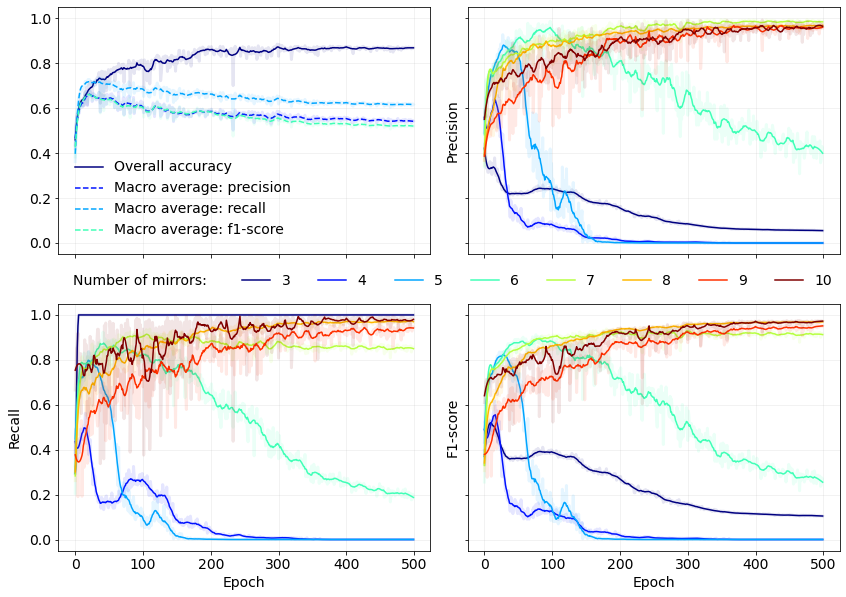

In [50]:
from scipy.signal import savgol_filter # for curve-smoothing
def smooth_plot(ax, data, window_size = 21, poly_order = 3, **kwargs):
    avg_data = savgol_filter(data, window_size, poly_order) # data to smooth, smoothing window size, polynomial order used in the filter
    
    ax.plot(data, alpha = 0.1, linewidth = 3, color = kwargs['color'])
    ax.plot(avg_data, linewidth = 1.5, **kwargs)

#####################
### ACCURACY PLOT ###
#####################
    
fig, ax = plt.subplots(2, 2, figsize=(14,10), sharex = True, sharey = True)
plt.rcParams['font.size'] = '14'

#ax[0,0].set_xlabel("Epoch")
smooth_plot(ax[0,0], classification_report_log_dict['accuracy'], label = 'Overall accuracy', color = colors[0])

smooth_plot(ax[0,0], classification_report_log_dict['macro avg']['precision'], 
         label = 'Macro average: precision', linestyle='--', color = colors[1])
smooth_plot(ax[0,0], classification_report_log_dict['macro avg']['recall'], 
         label = 'Macro average: recall', linestyle='--', color = colors[2])
smooth_plot(ax[0,0], classification_report_log_dict['macro avg']['f1-score'], 
         label = 'Macro average: f1-score', linestyle='--', color = colors[3])


ax[0,0].legend(loc='lower left', frameon = False, borderpad = 0.7)
ax[0,0].grid(alpha=0.2)

######################
### PRECISION PLOT ###
######################

metric = "Precision"
ax[0,1].set_ylabel(metric, labelpad = 8)
#ax[0,1].set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    smooth_plot(ax[0,1], classification_report_log_dict[class_id]['precision'], 
             label = class_id, color=col)
    
#ax[0,1].legend(loc='right',  bbox_to_anchor=[0.95, 0.3], title='Number of mirrors', ncol=3, frameon = False)
ax[0,1].grid(alpha=0.2)

###################
### RECALL PLOT ###
###################

metric = "Recall"
ax[1,0].set_ylabel(metric, labelpad = 8)
ax[1,0].set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    if class_id == '3': # a bit different smoothing to avoid recall > 1 on the plot
        smooth_plot(ax[1,0], classification_report_log_dict[class_id]['recall'], window_size = 7, poly_order = 6,
             label = class_id, color=col)
    else:
        smooth_plot(ax[1,0], classification_report_log_dict[class_id]['recall'], 
             label = class_id, color=col)
    
#ax[1,0].legend(loc='right',  bbox_to_anchor=[0.95, 0.6], title='Number of mirrors', ncol=3, frameon = False)
ax[1,0].grid(alpha=0.2)

#####################
### F1-SCORE PLOT ###
#####################

metric = "F1-score"
ax[1,1].set_ylabel(metric, labelpad=8)
ax[1,1].set_xlabel("Epoch")

for class_id, col in zip(classes, colors):
    class_metric = metric + ": " + class_id + " mirrors"
    smooth_plot(ax[1,1], classification_report_log_dict[class_id]['f1-score'], 
             label = class_id, color=col)
    
#ax[1,1].legend(loc='right',  bbox_to_anchor=[0.95, 0.6], title='Number of mirrors', ncol=3, frameon = False)
ax[1,1].grid(alpha=0.2)

handles, labels = plt.gca().get_legend_handles_labels()
#by_label = dict(zip(labels, handles))
#plt.legend(by_label.values(), by_label.keys())

fig.text(0.14, 0.5, 'Number of mirrors:', va = 'center')
fig.legend(handles, labels, bbox_to_anchor=[0.6, 0.5], loc='center', ncol=8, frameon = False)

plt.subplots_adjust(wspace = 0.1)
#plt.tight_layout()
plt.savefig('mlp2.pdf')
plt.show()

For completeness and convenience, we also output the final classification report in text form.

In [16]:
y_pred = model.predict(X_test, batch_size=len(X_test), verbose=1)
y_test_check = y_test
y_pred_check = np.argmax(y_pred, axis = 1)
print(classification_report(y_test_check, y_pred_check, target_names = classes))

1/1 [==============================] - 0s 52ms/step
              precision    recall  f1-score   support

           3       0.05      1.00      0.10       285
           4       0.00      0.00      0.00      1211
           5       0.00      0.00      0.00      3876
           6       0.40      0.19      0.26      9690
           7       0.99      0.85      0.91     19380
           8       0.97      0.97      0.97     31493
           9       0.96      0.95      0.95     41990
          10       0.96      0.98      0.97     46189

    accuracy                           0.87    154114
   macro avg       0.54      0.62      0.52    154114
weighted avg       0.90      0.87      0.88    154114



History for future reference:

In [17]:
print(classification_report_log_dict)

{'3': {'precision': [0.39069767441860465, 0.44594594594594594, 0.3891213389121339, 0.3333333333333333, 0.33748443337484435, 0.31526548672566373, 0.31456953642384106, 0.34545454545454546, 0.36259541984732824, 0.3298611111111111, 0.35580524344569286, 0.30513918629550324, 0.3321678321678322, 0.35447761194029853, 0.3396901072705602, 0.37898936170212766, 0.3242320819112628, 0.3, 0.3035143769968051, 0.3298611111111111, 0.2737752161383285, 0.29290853031860226, 0.3035143769968051, 0.26635514018691586, 0.2648698884758364, 0.2619485294117647, 0.23690773067331672, 0.2553763440860215, 0.24782608695652175, 0.24675324675324675, 0.23095623987034036, 0.22583201267828842, 0.22655007949125597, 0.22388059701492538, 0.2197378565921357, 0.22476340694006308, 0.22024729520865532, 0.21956856702619415, 0.2144469525959368, 0.22458628841607564, 0.22058823529411764, 0.2219626168224299, 0.2131637995512341, 0.21906225980015373, 0.22144522144522144, 0.22529644268774704, 0.2260111022997621, 0.22178988326848248, 0.216

In [6]:
classification_report_log_dict = {'3': {'precision': [0.39069767441860465, 0.44594594594594594, 0.3891213389121339, 0.3333333333333333, 0.33748443337484435, 0.31526548672566373, 0.31456953642384106, 0.34545454545454546, 0.36259541984732824, 0.3298611111111111, 0.35580524344569286, 0.30513918629550324, 0.3321678321678322, 0.35447761194029853, 0.3396901072705602, 0.37898936170212766, 0.3242320819112628, 0.3, 0.3035143769968051, 0.3298611111111111, 0.2737752161383285, 0.29290853031860226, 0.3035143769968051, 0.26635514018691586, 0.2648698884758364, 0.2619485294117647, 0.23690773067331672, 0.2553763440860215, 0.24782608695652175, 0.24675324675324675, 0.23095623987034036, 0.22583201267828842, 0.22655007949125597, 0.22388059701492538, 0.2197378565921357, 0.22476340694006308, 0.22024729520865532, 0.21956856702619415, 0.2144469525959368, 0.22458628841607564, 0.22058823529411764, 0.2219626168224299, 0.2131637995512341, 0.21906225980015373, 0.22144522144522144, 0.22529644268774704, 0.2260111022997621, 0.22178988326848248, 0.21673003802281368, 0.21477015825169554, 0.21855828220858894, 0.2197378565921357, 0.2237048665620094, 0.21739130434782608, 0.2289156626506024, 0.2224824355971897, 0.21477015825169554, 0.22265625, 0.2149321266968326, 0.22007722007722008, 0.22024729520865532, 0.2249408050513023, 0.21956856702619415, 0.21956856702619415, 0.23076923076923078, 0.22144522144522144, 0.22093023255813954, 0.22565320665083136, 0.2283653846153846, 0.2260111022997621, 0.22909967845659163, 0.23651452282157676, 0.2254746835443038, 0.2444253859348199, 0.23495465787304204, 0.23495465787304204, 0.24978089395267308, 0.2401010951979781, 0.23095623987034036, 0.2544642857142857, 0.24782608695652175, 0.23379819524200163, 0.24152542372881355, 0.23476112026359144, 0.24804177545691905, 0.23651452282157676, 0.25862068965517243, 0.24739583333333334, 0.23909395973154363, 0.2373022481265612, 0.2401010951979781, 0.23909395973154363, 0.23710482529118138, 0.2378964941569282, 0.24338172502134928, 0.2476107732406603, 0.2378964941569282, 0.24825783972125434, 0.23553719008264462, 0.2491258741258741, 0.23809523809523808, 0.2446351931330472, 0.23710482529118138, 0.2378964941569282, 0.23553719008264462, 0.23612261806130902, 0.24653979238754326, 0.23170731707317074, 0.2341824157764996, 0.22423288749016523, 0.237698081734779, 0.2401010951979781, 0.23208469055374592, 0.22511848341232227, 0.22983870967741934, 0.2285485164394547, 0.2285485164394547, 0.2221356196414653, 0.2285485164394547, 0.22983870967741934, 0.22655007949125597, 0.23114355231143552, 0.21906225980015373, 0.22709163346613545, 0.22058823529411764, 0.22565320665083136, 0.22041763341067286, 0.22983870967741934, 0.21906225980015373, 0.2375, 0.23133116883116883, 0.23058252427184467, 0.2240566037735849, 0.2180566182096404, 0.21706016755521707, 0.2336065573770492, 0.20848573518653987, 0.2136431784107946, 0.20727272727272728, 0.22075910147172734, 0.21079881656804733, 0.202991452991453, 0.203136136849608, 0.20342612419700215, 0.21607278241091737, 0.19063545150501673, 0.20056298381421533, 0.1924375422012154, 0.1893687707641196, 0.1972318339100346, 0.18974700399467376, 0.19025367156208278, 0.18106734434561628, 0.18886679920477137, 0.19282814614343707, 0.18375241779497098, 0.18688524590163935, 0.18506493506493507, 0.17947103274559195, 0.18095238095238095, 0.17723880597014927, 0.17823639774859287, 0.17399267399267399, 0.18387096774193548, 0.1832797427652733, 0.17890772128060264, 0.1847051198963059, 0.17690875232774675, 0.17035265989240886, 0.17845961177207265, 0.1892430278884462, 0.17625231910946196, 0.16994633273703041, 0.17506142506142505, 0.16843971631205673, 0.17346317711503348, 0.17701863354037267, 0.1736745886654479, 0.17879548306148055, 0.17495395948434622, 0.18700787401574803, 0.1694411414982164, 0.17220543806646527, 0.17388651616839537, 0.17570900123304561, 0.17117117117117117, 0.17055655296229802, 0.16695957820738136, 0.16627771295215868, 0.1660839160839161, 0.16092603049124787, 0.17189384800965019, 0.1643598615916955, 0.1721014492753623, 0.16351118760757316, 0.15224358974358973, 0.16193181818181818, 0.16267123287671234, 0.16304347826086957, 0.15859766277128548, 0.15413737155219037, 0.16304347826086957, 0.14713474445018068, 0.15023721665788087, 0.14652956298200515, 0.14445007602635582, 0.14193227091633467, 0.15023721665788087, 0.14292878635907724, 0.1437216338880484, 0.14186162269785962, 0.14067127344521224, 0.14136904761904762, 0.13828238719068414, 0.1408102766798419, 0.13636363636363635, 0.13922813873961895, 0.13922813873961895, 0.1370851370851371, 0.13662511984659637, 0.134180790960452, 0.11642156862745098, 0.11594792514239219, 0.12978142076502733, 0.12237011592958351, 0.1243455497382199, 0.1270619705751226, 0.13532763532763534, 0.11994949494949494, 0.12450851900393185, 0.12407488027862429, 0.11974789915966387, 0.11296076099881094, 0.11623164763458402, 0.12096774193548387, 0.11747732893652102, 0.12343005630142918, 0.11904761904761904, 0.125, 0.12153518123667377, 0.1138633639632441, 0.12195121951219512, 0.12086513994910941, 0.11786600496277916, 0.11585365853658537, 0.11300555114988105, 0.11699507389162561, 0.12010113780025285, 0.11984861227922625, 0.11377245508982035, 0.11359107214029494, 0.11623164763458402, 0.1082004555808656, 0.1102514506769826, 0.10397665085735133, 0.10754716981132076, 0.11984861227922625, 0.11685116851168512, 0.10547742413027388, 0.1079136690647482, 0.10292524377031419, 0.10409057706355003, 0.09899270580062522, 0.1074660633484163, 0.09007585335018964, 0.09664292980671414, 0.10127931769722814, 0.09841160220994476, 0.09322865554465162, 0.09262268443288918, 0.0986159169550173, 0.09693877551020408, 0.09605662285136501, 0.09985984583041345, 0.0964793500338524, 0.08644222020018198, 0.08763837638376384, 0.0946843853820598, 0.09344262295081968, 0.09205426356589147, 0.09190583682683005, 0.08710268948655257, 0.08812615955473098, 0.08774630541871921, 0.09484193011647254, 0.08917396745932415, 0.08229858504187121, 0.09750256585699624, 0.09016134134767478, 0.08417011222681631, 0.08352872215709262, 0.08477096966091612, 0.08870214752567694, 0.08548290341931614, 0.08605072463768115, 0.08965083359547027, 0.08424475317765297, 0.08479619160963998, 0.08328462887200468, 0.0878003696857671, 0.08397171479080731, 0.08644222020018198, 0.08540605334132455, 0.08199079401611047, 0.08149842722333428, 0.08563701923076923, 0.08530380125710865, 0.0791886635176438, 0.07914468203276867, 0.08152173913043478, 0.08075942193255879, 0.0776778413736713, 0.0790788013318535, 0.08075942193255879, 0.07719393282773565, 0.07940930621342993, 0.07667473769168684, 0.07875103619784471, 0.07816785518376303, 0.07275976512637222, 0.07579787234042554, 0.07958670762356884, 0.07389162561576355, 0.07334019557385486, 0.07087789107187267, 0.07347254447022429, 0.07345360824742268, 0.07349149045899948, 0.07251908396946564, 0.07315195071868583, 0.07075471698113207, 0.07389162561576355, 0.07153614457831325, 0.06995581737849779, 0.07164404223227752, 0.06985294117647059, 0.06660434681000234, 0.06839452843772498, 0.06971624266144814, 0.07217016966320587, 0.06694855532064835, 0.06739181839678411, 0.07093081134892981, 0.0683453237410072, 0.06721698113207547, 0.06651108518086347, 0.06606397774687066, 0.067090395480226, 0.06589595375722543, 0.06769596199524941, 0.06440677966101695, 0.06474329850068151, 0.06763170384432843, 0.06471389645776567, 0.06699576868829338, 0.06553230627730512, 0.06514285714285714, 0.06544202066590127, 0.06557754256787851, 0.0653070577451879, 0.06398742703188146, 0.06565307532826538, 0.06439222774514235, 0.0627062706270627, 0.06214566070649804, 0.06418918918918919, 0.06252742430890741, 0.062335958005249346, 0.06506849315068493, 0.06378692927484333, 0.06186238332971565, 0.06191614164675212, 0.06191614164675212, 0.06337558372248166, 0.06222707423580786, 0.06134309083082221, 0.06256860592755215, 0.06234959527455699, 0.06168831168831169, 0.061661618347035915, 0.0628029969149405, 0.06273387629319832, 0.061435654235826684, 0.06036856598178352, 0.06097560975609756, 0.062023939064200215, 0.061435654235826684, 0.06125080593165699, 0.062050947093403, 0.06191614164675212, 0.0625137091467427, 0.06214566070649804, 0.05931321540062435, 0.060432569974554706, 0.06147540983606557, 0.05963590709353421, 0.060780550223928344, 0.06034300232902816, 0.06054811982154239, 0.05993690851735016, 0.06136950904392765, 0.06104090811736989, 0.06096256684491978, 0.061080154307758254, 0.05906735751295337, 0.06026644110805667, 0.060858424087123636, 0.059190031152647975, 0.058775005155702206, 0.059214627051734886, 0.05848553252616458, 0.060780550223928344, 0.060101223112610715, 0.060228233305156385, 0.058473533032416904, 0.06008855154965212, 0.0595860338699561, 0.058473533032416904, 0.060177364864864864, 0.059251559251559255, 0.060202788339670466, 0.06026644110805667, 0.05825838103025348, 0.058762886597938144, 0.05830605564648118, 0.05866611774392754, 0.05952380952380952, 0.05727491961414791, 0.058413609346177495, 0.056943056943056944, 0.05867819641754169, 0.05811582381729201, 0.058569667077681874, 0.0580566306783459, 0.059873949579831935, 0.057599029911075184, 0.05741337630942788, 0.05653640150763738, 0.05702280912364946, 0.056977209116353456, 0.05831798649478207, 0.057599029911075184, 0.0577039886616724, 0.05777417393067099, 0.05744809514210845, 0.0572289156626506, 0.057926829268292686, 0.05764563106796117, 0.05798575788402848, 0.05765729314181671, 0.05614657210401891, 0.058521560574948665, 0.05747126436781609, 0.05679553607014747, 0.05785627283800244, 0.057482855990318674, 0.0559042761867399, 0.056682577565632455, 0.05608028335301062, 0.05620193255768093, 0.05567493651103731, 0.057205941389000405, 0.0566938531927591, 0.05660377358490566, 0.05640213734415199, 0.05505118794668727, 0.05718298555377207, 0.05592621664050235, 0.05729794933655006, 0.05577299412915851, 0.057160048134777375, 0.05725190839694656, 0.055286129970902036, 0.05555555555555555, 0.05726341169379144, 0.05649157581764123, 0.056818181818181816, 0.05614657210401891, 0.05651397977394408, 0.05718298555377207, 0.05557722308892356, 0.056648777579010136, 0.056003144036156416, 0.05677290836653386, 0.05667130642274806, 0.05663751987281399, 0.055221856229412905, 0.057332528666264336, 0.05583855799373041, 0.05540435458786936, 0.05489214175654854, 0.0556640625, 0.05593719332679097, 0.05536130536130536, 0.05577299412915851, 0.05592621664050235, 0.05530758781292451, 0.0553290623179965, 0.055598907530238, 0.05474452554744526], 'recall': [0.29473684210526313, 0.3473684210526316, 0.6526315789473685, 0.856140350877193, 0.9508771929824561, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'f1-score': [0.33599999999999997, 0.3905325443786982, 0.48754914809960676, 0.47984267453294, 0.49816176470588236, 0.479394449116905, 0.47858942065491183, 0.5135135135135135, 0.5322128851540616, 0.4960835509138381, 0.5248618784530387, 0.4675963904840033, 0.4986876640419948, 0.5234159779614325, 0.5071174377224199, 0.5496624879459981, 0.4896907216494846, 0.4615384615384615, 0.4656862745098039, 0.4960835509138381, 0.42986425339366513, 0.4531001589825119, 0.4656862745098039, 0.42066420664206644, 0.4188096987509184, 0.4151493080844865, 0.38306451612903225, 0.4068522483940043, 0.3972125435540069, 0.3958333333333333, 0.37524687294272546, 0.36845507433742725, 0.3694102397926118, 0.36585365853658536, 0.36030341340075855, 0.3670315518351578, 0.36098796706776437, 0.36007580543272266, 0.35315985130111527, 0.3667953667953668, 0.36144578313253006, 0.36328871892925424, 0.35141800246609123, 0.35939470365699877, 0.36259541984732824, 0.36774193548387096, 0.3686934023285899, 0.3630573248407643, 0.35625, 0.3535980148883375, 0.3587161736941472, 0.36030341340075855, 0.36561898652982683, 0.3571428571428571, 0.37254901960784315, 0.3639846743295019, 0.3535980148883375, 0.36421725239616615, 0.35381750465549344, 0.36075949367088606, 0.36098796706776437, 0.36726804123711343, 0.36007580543272266, 0.36007580543272266, 0.375, 0.36259541984732824, 0.36190476190476195, 0.3682170542635659, 0.37181996086105673, 0.3686934023285899, 0.37279267495094837, 0.38255033557046975, 0.36797934151065204, 0.3928325292901447, 0.38050734312416556, 0.38050734312416556, 0.39971949509116406, 0.38722826086956524, 0.37524687294272546, 0.40569395017793597, 0.3972125435540069, 0.37898936170212766, 0.3890784982935153, 0.3802535023348899, 0.39748953974895396, 0.38255033557046975, 0.4109589041095891, 0.39665970772442594, 0.38591740013540965, 0.3835800807537012, 0.38722826086956524, 0.38591740013540965, 0.3833221250840619, 0.38435603506405935, 0.3914835164835165, 0.3969359331476323, 0.38435603506405935, 0.39776692254012563, 0.3812709030100334, 0.3988803358992302, 0.3846153846153846, 0.3931034482758621, 0.3833221250840619, 0.38435603506405935, 0.3812709030100334, 0.3820375335120643, 0.395558639833449, 0.37623762376237624, 0.37949400798934757, 0.3663239074550129, 0.3840970350404313, 0.38722826086956524, 0.3767349636483807, 0.36750483558994196, 0.3737704918032787, 0.3720626631853786, 0.3720626631853786, 0.3635204081632653, 0.3720626631853786, 0.3737704918032787, 0.3694102397926118, 0.37549407114624506, 0.35939470365699877, 0.3701298701298701, 0.36144578313253006, 0.3682170542635659, 0.3612167300380228, 0.3737704918032787, 0.35939470365699877, 0.3838383838383838, 0.3757415952537904, 0.3747534516765286, 0.36608863198458574, 0.35804020100502515, 0.3566958698372966, 0.37873754152823924, 0.3450363196125908, 0.35206917850525016, 0.3433734939759036, 0.3616751269035533, 0.34819792302993274, 0.3374777975133215, 0.3376777251184834, 0.33807829181494664, 0.3553615960099751, 0.3202247191011236, 0.33411488862837047, 0.32276330690826727, 0.31843575418994413, 0.32947976878612717, 0.3189703413542249, 0.31968592260235557, 0.3066164604626143, 0.31772575250836116, 0.3233125354509359, 0.3104575163398693, 0.31491712707182323, 0.31232876712328766, 0.3043246129204485, 0.3064516129032258, 0.3011093502377179, 0.302547770700637, 0.29641185647425894, 0.3106267029972752, 0.30978260869565216, 0.3035143769968051, 0.31181619256017507, 0.30063291139240506, 0.29111338100102147, 0.3028692879914984, 0.3182579564489112, 0.29968454258675076, 0.29051987767584103, 0.29796131730266595, 0.28831562974203334, 0.29564315352697096, 0.30079155672823216, 0.2959501557632399, 0.3033528472591804, 0.29780564263322884, 0.3150912106135986, 0.28978139298423994, 0.29381443298969073, 0.2962577962577963, 0.29889879391714735, 0.2923076923076923, 0.29141104294478526, 0.28614457831325296, 0.2851425712856428, 0.2848575712143928, 0.27723735408560307, 0.29336078229541945, 0.2823179791976226, 0.2936630602782071, 0.28106508875739644, 0.26425591098748263, 0.2787286063569682, 0.27982326951399117, 0.2803738317757009, 0.2737752161383285, 0.26710402999062793, 0.2803738317757009, 0.2565256525652565, 0.2612282309807516, 0.2556053811659193, 0.2524357838795394, 0.24858264282599218, 0.2612282309807516, 0.25010969723562965, 0.2513227513227513, 0.24847428073234526, 0.24664647338814366, 0.24771838331160365, 0.24296675191815856, 0.2468601126028584, 0.24000000000000002, 0.24442538593481988, 0.24442538593481988, 0.24111675126903553, 0.24040489245044286, 0.23661270236612705, 0.20856201975850713, 0.20780167699598978, 0.22974607013301088, 0.21805661820964037, 0.22118742724097787, 0.2254746835443038, 0.2383939774153074, 0.2142051860202931, 0.22144522144522144, 0.22075910147172734, 0.21388367729831145, 0.202991452991453, 0.20825721592985022, 0.2158273381294964, 0.2102545186278126, 0.21973785659213568, 0.21276595744680848, 0.2222222222222222, 0.21673003802281368, 0.20444763271162125, 0.21739130434782605, 0.21566401816118047, 0.21087680355160934, 0.2076502732240437, 0.20306376914855717, 0.20948180815876513, 0.21444695259593682, 0.21404431092752538, 0.20430107526881722, 0.20400858983536152, 0.20825721592985022, 0.19527235354573486, 0.19860627177700352, 0.18836748182419033, 0.19420783645655876, 0.21404431092752538, 0.20925110132158592, 0.190826916638768, 0.1948051948051948, 0.18664047151277013, 0.18855441614290439, 0.18015170670037928, 0.1940755873340143, 0.16526529428819947, 0.17625231910946196, 0.18393030009680542, 0.17918893429739075, 0.17055655296229805, 0.16954193932183223, 0.1795275590551181, 0.17674418604651163, 0.17527675276752766, 0.18158649251353934, 0.17598024081506639, 0.1591289782244556, 0.1611535199321459, 0.17298937784522003, 0.1709145427286357, 0.16858917480035493, 0.16834022445363261, 0.16024739949395558, 0.16197783461210571, 0.1613359750919898, 0.17325227963525838, 0.1637460499856363, 0.1520811099252935, 0.1776807980049875, 0.1654091700522345, 0.15527104331244893, 0.1541790641060319, 0.1562928434329586, 0.16295025728987994, 0.15750207239568942, 0.15846538782318598, 0.16454965357967669, 0.1553980370774264, 0.15633571036752605, 0.15376315079579175, 0.16142735768903996, 0.15493340581679807, 0.1591289782244556, 0.15737161789066814, 0.15155543738367455, 0.150713907985193, 0.15776363133130364, 0.1571980143408715, 0.1467559217301751, 0.14668039114770973, 0.1507537688442211, 0.14944939695857368, 0.14415781487101667, 0.14656724093597326, 0.14944939695857368, 0.1433241136535077, 0.14713474445018068, 0.1424287856071964, 0.14600409836065573, 0.14500127194098195, 0.1356496906235126, 0.14091470951792337, 0.14743921365752718, 0.13761467889908258, 0.13665787580915847, 0.13237343241987926, 0.13688760806916428, 0.13685474189675872, 0.1369204900312275, 0.13523131672597866, 0.1363310212867735, 0.13215859030837004, 0.13761467889908258, 0.1335207308503162, 0.1307639366827254, 0.13370865587614356, 0.13058419243986255, 0.12489044697633654, 0.12803234501347707, 0.1303453007088955, 0.134624468587624, 0.12549537648612946, 0.12627381479840497, 0.13246572158958866, 0.12794612794612795, 0.12596685082872927, 0.12472647702407001, 0.1239399869536856, 0.1257445400397088, 0.12364425162689803, 0.12680756395995552, 0.12101910828025476, 0.12161297205035206, 0.1266948210713492, 0.12156110044785669, 0.12557832121612691, 0.12300388433318944, 0.12231759656652359, 0.1228448275862069, 0.12308356726408985, 0.12260701226070121, 0.12027853977632412, 0.12321660181582361, 0.12099341965612398, 0.11801242236024843, 0.1170190925887908, 0.12063492063492062, 0.11769564319636588, 0.11735639283508338, 0.12218649517684887, 0.11992425836313907, 0.11651676206050696, 0.11661211129296235, 0.11661211129296235, 0.1191969887076537, 0.11716341212744091, 0.11559521395254513, 0.11776859504132232, 0.11738056013179572, 0.11620795107033638, 0.11616058691664968, 0.11818370308936348, 0.1180613090306545, 0.1157595450852965, 0.11386336396324412, 0.11494252873563218, 0.1168032786885246, 0.1157595450852965, 0.11543134872417983, 0.11685116851168512, 0.11661211129296235, 0.1176713459950454, 0.1170190925887908, 0.11198428290766207, 0.11397720455908818, 0.11583011583011583, 0.11255924170616113, 0.11459589867310013, 0.11381789137380192, 0.11418269230769232, 0.1130952380952381, 0.11564211807668898, 0.11505853855470327, 0.11491935483870966, 0.11512825691779441, 0.11154598825831702, 0.11368169126445951, 0.1147342995169082, 0.11176470588235295, 0.11102454226723803, 0.11180855237347981, 0.11050794881737107, 0.11459589867310013, 0.11338770638551819, 0.11361371337452661, 0.11048652839697616, 0.11336515513126492, 0.11247040252565114, 0.11048652839697616, 0.11352320254929296, 0.11187438665358196, 0.11356843992827255, 0.11368169126445951, 0.11010237589337454, 0.11100292112950341, 0.11018751208196405, 0.11083025471514679, 0.11235955056179775, 0.10834442121269719, 0.11037955073586367, 0.10775047258979206, 0.11085180863477245, 0.10984775486606282, 0.11065812463599302, 0.1097420100115518, 0.11298315163528246, 0.10892413529524174, 0.10859211278338732, 0.10702215546376269, 0.10789324247586597, 0.10781161339133724, 0.11020881670533643, 0.10892413529524174, 0.10911179173047474, 0.10923725565350709, 0.10865421273351127, 0.10826210826210825, 0.10951008645533142, 0.10900745840504877, 0.10961538461538461, 0.1090283091048202, 0.10632344711807498, 0.11057225994180407, 0.10869565217391304, 0.10748632849330568, 0.10938399539435809, 0.10871638374976159, 0.10588890953000187, 0.10728402032749858, 0.10620458356623813, 0.10642270351008215, 0.10547742413027386, 0.1082209986709702, 0.10730421686746987, 0.10714285714285715, 0.10678156612963657, 0.10435737824972538, 0.1081799202884798, 0.10592826612153874, 0.10838562464346835, 0.10565338276181649, 0.10813887307911212, 0.10830324909747292, 0.10477941176470588, 0.10526315789473684, 0.10832383124287344, 0.10694183864915573, 0.1075268817204301, 0.10632344711807498, 0.10698198198198199, 0.1081799202884798, 0.10530205061888048, 0.1072234762979684, 0.10606624488276889, 0.10744580584354382, 0.10726383138878436, 0.10720331013729548, 0.10466397355857511, 0.1084474885844749, 0.10577101503061792, 0.10499171118069626, 0.10407157202848276, 0.10545790934320073, 0.10594795539033458, 0.1049144119271121, 0.10565338276181649, 0.10592826612153874, 0.10481794777491725, 0.10485651214128035, 0.10534097209388282, 0.10380622837370243]}, '4': {'precision': [0.49109947643979057, 0.5641509433962264, 0.5712765957446808, 0.5454545454545454, 0.5116988809766022, 0.5305010893246187, 0.4973488865323436, 0.5186304128902316, 0.5564892623716153, 0.5313351498637602, 0.5940390544707091, 0.5321463897131553, 0.5975609756097561, 0.6352331606217616, 0.625250501002004, 0.6844221105527638, 0.6936619718309859, 0.5922107674684994, 0.5846645367412141, 0.6587982832618026, 0.5140607424071991, 0.584841628959276, 0.6439665471923537, 0.47362514029180697, 0.48484848484848486, 0.48867699642431467, 0.3274139844617092, 0.4847715736040609, 0.40279394644935973, 0.3818589025755879, 0.3169267707082833, 0.24279835390946503, 0.23976023976023977, 0.23684210526315788, 0.18559556786703602, 0.25555555555555554, 0.1946564885496183, 0.1510574018126888, 0.11465400271370421, 0.189640768588137, 0.17028380634390652, 0.15209665955934612, 0.10144927536231885, 0.1293961512939615, 0.14896650035637918, 0.1671490593342981, 0.15112540192926044, 0.15781600598354525, 0.11207430340557276, 0.09726962457337884, 0.11418481459682166, 0.11274787535410764, 0.14221652786675207, 0.08968824940047962, 0.15446153846153846, 0.10958205912334353, 0.08140655105973026, 0.10583047525722684, 0.06808169803764517, 0.08241082410824108, 0.07859922178988327, 0.09331703341483293, 0.07306273062730627, 0.06244087038789026, 0.10361254466057959, 0.06492699596147872, 0.061676646706586825, 0.07064887810794421, 0.07689922480620155, 0.06930109112356238, 0.07323452484742807, 0.09142318567389256, 0.06467800390298299, 0.09883198562443846, 0.08245920745920746, 0.08176827506501011, 0.10606513295488497, 0.08785897071367643, 0.07100271002710028, 0.11049074346165148, 0.10108092316681273, 0.07335805084745763, 0.0854978354978355, 0.07573744352909913, 0.0984251968503937, 0.07792207792207792, 0.11174134997163924, 0.09009952854897853, 0.07959554057557687, 0.07641025641025641, 0.07982433479721002, 0.0840475532209013, 0.0770440251572327, 0.07932755450485947, 0.0869220607661823, 0.09095647641386499, 0.07968337730870713, 0.09492988133764833, 0.0712355686563498, 0.0938818565400844, 0.07588279489105935, 0.08714880332986473, 0.07271839921913129, 0.07508702138239681, 0.07069722086786934, 0.07183133120862957, 0.08702251454591449, 0.06583760058522312, 0.0682915057915058, 0.0577063550036523, 0.07457879088206144, 0.08071170706549768, 0.06731007176441475, 0.061430793157076204, 0.06776127182694813, 0.072059242381088, 0.06919945725915876, 0.05607235142118863, 0.06981236203090507, 0.0740108169655565, 0.06361724500525763, 0.07663170163170163, 0.052964426877470355, 0.06521160500399255, 0.05416666666666667, 0.06345381526104418, 0.05257705257705258, 0.06547314578005115, 0.05073941866394697, 0.07698309492847855, 0.0679340937896071, 0.07304925290536801, 0.056843679880329095, 0.05022947475777664, 0.048260096520193044, 0.07237851662404092, 0.04251700680272109, 0.05325593134780414, 0.04179254783484391, 0.05871748647952614, 0.045317220543806644, 0.033414634146341465, 0.03678846631866766, 0.03449150393101699, 0.049429657794676805, 0.02227324913892078, 0.03193916349809886, 0.02612942612942613, 0.025068939583855605, 0.03304347826086956, 0.02355512384652744, 0.025094102885821833, 0.021845851742758958, 0.023221343873517788, 0.027820316488004083, 0.021255561047948592, 0.021, 0.027877237851662403, 0.019245188702824295, 0.021145807720678634, 0.0189952511872032, 0.021942800788954636, 0.020398251578436135, 0.027417746759720838, 0.02215032354405177, 0.021635220125786163, 0.030227329502872845, 0.020785804816223066, 0.016770963704630788, 0.022851465474416296, 0.031072749691738594, 0.024427480916030534, 0.016041461006910167, 0.02019446522064323, 0.017298397354362758, 0.020491803278688523, 0.020796347958407305, 0.019518377693282636, 0.025970751386787696, 0.022900763358778626, 0.02775, 0.02042875157629256, 0.018357980622131564, 0.020610687022900764, 0.020071138211382115, 0.015274949083503055, 0.017775520568816656, 0.01618204804045512, 0.014883243520656916, 0.017788089713843776, 0.01344364012409514, 0.018250950570342206, 0.015486164001015486, 0.023119918699186993, 0.016499097705594226, 0.008926227356261486, 0.014921533316182145, 0.016718106995884774, 0.017078766250318633, 0.01232302045097011, 0.010344827586206896, 0.013295099061522419, 0.00913978494623656, 0.011311607864260706, 0.008373851971907077, 0.0075107296137339056, 0.00845608292416803, 0.011320754716981131, 0.008426202772492526, 0.00867443751694226, 0.008446866485013624, 0.007598371777476255, 0.007906215921483098, 0.007596310363537711, 0.008303349017437033, 0.007555315704263357, 0.007803790412486065, 0.00825536598789213, 0.008529997156667614, 0.008906206512663512, 0.006808510638297872, 0.00490948143602332, 0.005728067530901417, 0.006502685891998869, 0.00556043312847527, 0.005553931598947676, 0.005598114319387153, 0.00784094091290955, 0.006644518272425249, 0.004746366063482646, 0.00713224368499257, 0.005118940078289671, 0.005415162454873646, 0.0048721071863581, 0.006294964028776978, 0.006765067650676507, 0.008750754375377187, 0.006310096153846154, 0.008509389671361502, 0.008562149394744612, 0.006721662083715246, 0.007955215085444903, 0.007740398928252456, 0.008610086100861008, 0.006752608962553714, 0.0064200550290431065, 0.006151953245155337, 0.006495515001546551, 0.006329113924050633, 0.006658211794546607, 0.004379105411323116, 0.004244996967859308, 0.004416403785488959, 0.003861003861003861, 0.0035483870967741938, 0.00428921568627451, 0.006664647076643442, 0.0068006182380216385, 0.0037012113055181696, 0.0044585987261146496, 0.0033456005352960855, 0.004886561954624782, 0.0039104159260575895, 0.004918032786885246, 0.003629764065335753, 0.003679175864606328, 0.0038596491228070177, 0.0036496350364963502, 0.003539127015336217, 0.003713330857779428, 0.003934191702432046, 0.0036023054755043226, 0.004027828634199927, 0.00515818431911967, 0.003664345914254306, 0.003998400639744102, 0.0036600244001626678, 0.003992740471869328, 0.00401899890390939, 0.003775009437523594, 0.004144687264506406, 0.0038022813688212928, 0.0035474970437524636, 0.0039541320680110716, 0.0037835792659856224, 0.0016346546791990192, 0.0016597510373443983, 0.004093784890212133, 0.003808073115003808, 0.004177109440267335, 0.0016142050040355124, 0.004073319755600814, 0.0040766408479412965, 0.0040683482506102524, 0.0016220600162206002, 0.0040032025620496394, 0.001294777729823047, 0.003746877601998335, 0.004450378282153983, 0.004093327875562832, 0.004149377593360996, 0.004217629692113032, 0.004159733777038269, 0.003861003861003861, 0.004448398576512456, 0.004231908590774439, 0.004579517069109076, 0.0022675736961451248, 0.004636068613815485, 0.004440497335701598, 0.004578754578754579, 0.0042452830188679245, 0.004677268475210477, 0.003982300884955752, 0.004335260115606936, 0.0040595399188092015, 0.004570383912248629, 0.004227336777829967, 0.004766444232602479, 0.0004997501249375312, 0.0044444444444444444, 0.0040779338468509285, 0.0014742014742014742, 0.004709576138147566, 0.0, 0.0041109969167523125, 0.0, 0.004145077720207254, 0.004186289900575615, 0.0005417118093174431, 0.0, 0.0045, 0.0005482456140350877, 0.001148105625717566, 0.004357298474945534, 0.0011299435028248588, 0.0, 0.0, 0.0011402508551881414, 0.0022459292532285235, 0.0, 0.0034423407917383822, 0.004942339373970346, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005988023952095808, 0.0, 0.0, 0.0036231884057971015, 0.0, 0.003575685339690107, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0036540803897685747, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'recall': [0.3872832369942196, 0.49380677126341865, 0.4434351775392238, 0.35177539223782, 0.4153592072667217, 0.40214698596201487, 0.3872832369942196, 0.42526837324525185, 0.4921552436003303, 0.48307184145334436, 0.4772914946325351, 0.44426094137076794, 0.48554913294797686, 0.5061932287365813, 0.5152766308835673, 0.5623451692815855, 0.4880264244426094, 0.4269199009083402, 0.45334434351775393, 0.5070189925681255, 0.37737407101568954, 0.4269199009083402, 0.44508670520231214, 0.34847233691164325, 0.3435177539223782, 0.3385631709331131, 0.24360033030553263, 0.31544178364987613, 0.2857142857142857, 0.2815854665565648, 0.2180016515276631, 0.1948802642444261, 0.1981833195706028, 0.18579686209744012, 0.16597853014037986, 0.18992568125516102, 0.16845582163501238, 0.16515276630883569, 0.13955408753096615, 0.1874483897605285, 0.16845582163501238, 0.17671345995045418, 0.1329479768786127, 0.1610239471511148, 0.17258464079273328, 0.1907514450867052, 0.19405450041288191, 0.17423616845582163, 0.1494632535094963, 0.1412056151940545, 0.16019818331957061, 0.16432700247729148, 0.1833195706028076, 0.15441783649876134, 0.20726672171758878, 0.17753922378199835, 0.13955408753096615, 0.17836498761354252, 0.14037985136251033, 0.16597853014037986, 0.16680429397192403, 0.18909991742361684, 0.1635012386457473, 0.1635012386457473, 0.21552436003303055, 0.17258464079273328, 0.17010734929810073, 0.19240297274979357, 0.20478943022295623, 0.19405450041288191, 0.20809248554913296, 0.2402972749793559, 0.1915772089182494, 0.27250206440957886, 0.2336911643270025, 0.2336911643270025, 0.2931461601981833, 0.2551610239471511, 0.21635012386457472, 0.3104872006606111, 0.2857142857142857, 0.22873658133773742, 0.26094137076796037, 0.23534269199009084, 0.28901734104046245, 0.24277456647398843, 0.32535094962840627, 0.28406275805119735, 0.2535094962840628, 0.24607762180016515, 0.2551610239471511, 0.2510322047894302, 0.24277456647398843, 0.24938067712634188, 0.27167630057803466, 0.28819157720891825, 0.24938067712634188, 0.2906688687035508, 0.23947151114781173, 0.2939719240297275, 0.250206440957886, 0.27663088356729976, 0.24607762180016515, 0.24938067712634188, 0.23947151114781173, 0.24194880264244426, 0.28406275805119735, 0.22295623451692817, 0.2336911643270025, 0.19570602807597026, 0.24855491329479767, 0.2584640792733278, 0.22460776218001652, 0.19570602807597026, 0.21469859620148637, 0.20891824938067713, 0.21056977704376548, 0.1791907514450867, 0.20891824938067713, 0.21469859620148637, 0.19983484723369116, 0.2171758876961189, 0.16597853014037986, 0.2023121387283237, 0.1717588769611891, 0.19570602807597026, 0.1676300578034682, 0.21139554087530965, 0.16432700247729148, 0.2444260941370768, 0.2213047068538398, 0.2180016515276631, 0.18827415359207267, 0.16267547481420314, 0.1568951279933939, 0.2336911643270025, 0.14450867052023122, 0.17423616845582163, 0.1370767960363336, 0.18827415359207267, 0.1486374896779521, 0.11312964492155243, 0.1222130470685384, 0.11230388109000826, 0.1610239471511148, 0.08009909165978531, 0.10404624277456648, 0.08835672997522709, 0.08257638315441784, 0.10982658959537572, 0.08009909165978531, 0.08257638315441784, 0.07349298100743187, 0.07762180016515277, 0.09000825763831544, 0.07101568951279934, 0.06936416184971098, 0.09000825763831544, 0.06358381502890173, 0.07101568951279934, 0.06275805119735756, 0.07349298100743187, 0.06936416184971098, 0.09083402146985962, 0.07349298100743187, 0.07101568951279934, 0.09991742361684558, 0.06771263418662263, 0.05532617671345995, 0.07597027250206441, 0.10404624277456648, 0.07927332782824112, 0.053674649050371594, 0.06688687035507845, 0.05615194054500413, 0.06606110652353427, 0.06771263418662263, 0.06358381502890173, 0.08505367464905036, 0.07431874483897605, 0.0916597853014038, 0.06688687035507845, 0.05945499587118084, 0.06688687035507845, 0.06523534269199009, 0.0495458298926507, 0.057803468208092484, 0.05284888521882741, 0.04789430222956235, 0.05697770437654831, 0.042939719240297276, 0.05945499587118084, 0.05037159372419488, 0.07514450867052024, 0.05284888521882741, 0.028075970272502065, 0.04789430222956235, 0.053674649050371594, 0.05532617671345995, 0.038810900082576386, 0.03220478943022296, 0.042113955408753095, 0.028075970272502065, 0.03468208092485549, 0.02559867877786953, 0.023121387283236993, 0.02559867877786953, 0.03468208092485549, 0.02559867877786953, 0.026424442609413706, 0.02559867877786953, 0.023121387283236993, 0.023947151114781174, 0.023121387283236993, 0.02477291494632535, 0.023121387283236993, 0.023121387283236993, 0.02477291494632535, 0.02477291494632535, 0.026424442609413706, 0.01981833195706028, 0.013212221304706853, 0.01568951279933939, 0.018992568125516102, 0.01568951279933939, 0.01568951279933939, 0.01568951279933939, 0.023121387283236993, 0.018166804293971925, 0.013212221304706853, 0.01981833195706028, 0.014037985136251032, 0.01486374896779521, 0.013212221304706853, 0.017341040462427744, 0.018166804293971925, 0.023947151114781174, 0.017341040462427744, 0.023947151114781174, 0.023947151114781174, 0.018166804293971925, 0.022295623451692816, 0.021469859620148638, 0.023121387283236993, 0.018166804293971925, 0.017341040462427744, 0.016515276630883566, 0.017341040462427744, 0.017341040462427744, 0.017341040462427744, 0.011560693641618497, 0.011560693641618497, 0.011560693641618497, 0.00990916597853014, 0.009083402146985962, 0.011560693641618497, 0.018166804293971925, 0.018166804293971925, 0.009083402146985962, 0.011560693641618497, 0.008257638315441783, 0.011560693641618497, 0.009083402146985962, 0.012386457473162676, 0.008257638315441783, 0.008257638315441783, 0.009083402146985962, 0.008257638315441783, 0.007431874483897605, 0.008257638315441783, 0.009083402146985962, 0.008257638315441783, 0.009083402146985962, 0.012386457473162676, 0.008257638315441783, 0.008257638315441783, 0.007431874483897605, 0.009083402146985962, 0.009083402146985962, 0.008257638315441783, 0.009083402146985962, 0.008257638315441783, 0.007431874483897605, 0.008257638315441783, 0.008257638315441783, 0.0033030553261767133, 0.0033030553261767133, 0.009083402146985962, 0.008257638315441783, 0.008257638315441783, 0.0033030553261767133, 0.008257638315441783, 0.008257638315441783, 0.008257638315441783, 0.0033030553261767133, 0.008257638315441783, 0.002477291494632535, 0.007431874483897605, 0.008257638315441783, 0.008257638315441783, 0.008257638315441783, 0.008257638315441783, 0.008257638315441783, 0.007431874483897605, 0.008257638315441783, 0.008257638315441783, 0.009083402146985962, 0.004128819157720892, 0.008257638315441783, 0.008257638315441783, 0.008257638315441783, 0.007431874483897605, 0.008257638315441783, 0.007431874483897605, 0.007431874483897605, 0.007431874483897605, 0.008257638315441783, 0.007431874483897605, 0.008257638315441783, 0.0008257638315441783, 0.007431874483897605, 0.007431874483897605, 0.002477291494632535, 0.007431874483897605, 0.0, 0.006606110652353427, 0.0, 0.006606110652353427, 0.006606110652353427, 0.0008257638315441783, 0.0, 0.007431874483897605, 0.0008257638315441783, 0.0016515276630883566, 0.006606110652353427, 0.0016515276630883566, 0.0, 0.0, 0.0016515276630883566, 0.0033030553261767133, 0.0, 0.00495458298926507, 0.007431874483897605, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0008257638315441783, 0.0, 0.0, 0.00495458298926507, 0.0, 0.00495458298926507, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00495458298926507, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'f1-score': [0.43305632502308405, 0.5266402465874064, 0.499302649930265, 0.427710843373494, 0.45852324521422055, 0.4574917801784876, 0.4354688950789229, 0.46733212341197816, 0.5223488168273445, 0.5060553633217992, 0.5293040293040293, 0.48424842484248426, 0.535763097949886, 0.5634191176470589, 0.5649615210502489, 0.6174070716228469, 0.5729520116335433, 0.49616122840690974, 0.5106976744186047, 0.5730284647690155, 0.43523809523809526, 0.49355608591885436, 0.5263671875, 0.4015223596574691, 0.40212663122281295, 0.39999999999999997, 0.2793560606060606, 0.38219109554777386, 0.3342995169082126, 0.3241444866920152, 0.2583170254403131, 0.21621621621621623, 0.21699819168173598, 0.20823692734844976, 0.17523975588491716, 0.21790620558976787, 0.18061088977423637, 0.15779092702169625, 0.1258845437616387, 0.18853820598006643, 0.16936488169364883, 0.1634835752482811, 0.11508220157255182, 0.14348785871964678, 0.15990818668706963, 0.17817200154261473, 0.16992046276211134, 0.16562009419152277, 0.12809624911535739, 0.11519029976423038, 0.13333333333333333, 0.13373655913978494, 0.16017316017316016, 0.11347087378640777, 0.1770098730606488, 0.13551843681058934, 0.10282932765439612, 0.13284132841328414, 0.09169363538295577, 0.11013698630136987, 0.10685003967204444, 0.12496589358799456, 0.1009946442234124, 0.09036969420356003, 0.13994638069705095, 0.0943566591422122, 0.09052955394418809, 0.10334885783987581, 0.11181244364292155, 0.10212950890916994, 0.10834049871023214, 0.13245334547109697, 0.09670696123384744, 0.14505494505494504, 0.12190394141718716, 0.1211472602739726, 0.15577007459412023, 0.13071065989847716, 0.10691695572332179, 0.16298222800173384, 0.1493310315062581, 0.11108883096049728, 0.12879559812512736, 0.11459589867310013, 0.1468428781204112, 0.11797752808988762, 0.1663500105552037, 0.13680652217140588, 0.12115232833464878, 0.11661123067892779, 0.1216056670602125, 0.12593206296603146, 0.11696837079769247, 0.12036667995217218, 0.13170536429143312, 0.1382725832012678, 0.1207758448310338, 0.1431185200243952, 0.10980689132904203, 0.14231461123326006, 0.1164488854727133, 0.13254203758654798, 0.11226219627048409, 0.1154213644181158, 0.10916619612271787, 0.1107750472589792, 0.1332300542215337, 0.1016566265060241, 0.10569561157796453, 0.08913125235050771, 0.1147322279397751, 0.12301041461976814, 0.10357958872810359, 0.09350956796212269, 0.1030110935023772, 0.10715798390512495, 0.10416666666666669, 0.08541625664239323, 0.1046535677352637, 0.11007620660457239, 0.09651046859421736, 0.11328882188240362, 0.08030363563723532, 0.09863123993558777, 0.08235992872698476, 0.09583501819652245, 0.08004731861198737, 0.09998047256395234, 0.07753750243522307, 0.1170886075949367, 0.1039565554693561, 0.10943005181347151, 0.08732286480275757, 0.07675823105396455, 0.07381507381507382, 0.1105252880296817, 0.0657030223390276, 0.08157742122559443, 0.06405556627435849, 0.08951707891637221, 0.06945784294809955, 0.05159103746940312, 0.0565533053114253, 0.052774544043461394, 0.0756400310318076, 0.03485447358965146, 0.04887509697439876, 0.04033169996230682, 0.038461538461538464, 0.05080213903743316, 0.03640457872021017, 0.03849114703618168, 0.033680227057710496, 0.03574824111047728, 0.04250341197114447, 0.03271828038805402, 0.03223949337938976, 0.042569810583870334, 0.029547198772064468, 0.0325881015536188, 0.029163468917881807, 0.03379532940953105, 0.031525614561831485, 0.0421213861765269, 0.034040925607190665, 0.033166216737369844, 0.04641350210970464, 0.03180760279286268, 0.025739531310026893, 0.035134619056711856, 0.047854158754272694, 0.03734681968488621, 0.024700741022230667, 0.03102259670624282, 0.026448852586542202, 0.03128054740957967, 0.03181994567326348, 0.029868114817688134, 0.03979138497199149, 0.03501264345458082, 0.04260218767990789, 0.0312982998454405, 0.028053769725306838, 0.03151137910912274, 0.030697493685642126, 0.02335084646818447, 0.027189745581666345, 0.024777390631049168, 0.02270947533281128, 0.027111984282907668, 0.020476471746406776, 0.027928626842513578, 0.023689320388349512, 0.03536040411890422, 0.02514734774066798, 0.01354581673306773, 0.022754021184778345, 0.02549519513630124, 0.026100506427736654, 0.018706467661691543, 0.01565950612326842, 0.020210025757875966, 0.013790306225917663, 0.017059301380991064, 0.012619580704254021, 0.01133832759667949, 0.012712733237646096, 0.017069701280227598, 0.012678936605316974, 0.013061224489795917, 0.012702315099364881, 0.011437908496732025, 0.011887681902029105, 0.011435572799673268, 0.01243781094527363, 0.01138905836892414, 0.011669097728693479, 0.012383900928792569, 0.012690355329949238, 0.013322231473771857, 0.010135135135135136, 0.00715883668903803, 0.008392226148409895, 0.009688289806234204, 0.008210890233362144, 0.008203799654576857, 0.008251900108577633, 0.011710581346716856, 0.009730207872622734, 0.006983849847228285, 0.010489510489510488, 0.007502206531332745, 0.007938257993384785, 0.007119021134593993, 0.009236859467780955, 0.009858839345731571, 0.01281767955801105, 0.009253139458030404, 0.01255683048278848, 0.012614180078294911, 0.009812667261373774, 0.011726384364820848, 0.011378555798687089, 0.012547613712749272, 0.009845603043186395, 0.009370816599732263, 0.008964589870013447, 0.009450945094509451, 0.009273570324574962, 0.009621993127147767, 0.006352087114337567, 0.006209802616988245, 0.006391234877881762, 0.005556841861542024, 0.005103224309904895, 0.006256983240223464, 0.00975177304964539, 0.009896536212325687, 0.005259383217786278, 0.006435302229372557, 0.0047619047619047615, 0.006869479882237488, 0.0054671968190854875, 0.0070406007979347575, 0.005042864346949067, 0.005090353779587681, 0.005417384880571288, 0.005062009617818273, 0.004794885455514118, 0.005122950819672131, 0.005490391814324931, 0.0050163029847002764, 0.005580923389142568, 0.007283321194464677, 0.005076142131979696, 0.005387931034482759, 0.004904632152588556, 0.005547150781643974, 0.005572441742654508, 0.005181347150259067, 0.005692108667529108, 0.005206977349648529, 0.0048025613660619, 0.0053475935828877, 0.005189413596263622, 0.002186987424822307, 0.0022093344380005524, 0.00564391995895331, 0.005212405525149856, 0.005547850208044382, 0.0021686093792355654, 0.005455537370430987, 0.005458515283842795, 0.005451076587626056, 0.0021756867011150393, 0.005392289026691831, 0.0017006802721088437, 0.00498200941046222, 0.00578368999421631, 0.005473453749315817, 0.00552333609500138, 0.0055834729201563365, 0.0055325034578146606, 0.005081874647092038, 0.005782017924255565, 0.005595970900951315, 0.006089122612787158, 0.0029274004683840747, 0.005938242280285036, 0.005775339301183944, 0.005891016200294551, 0.005403782647853498, 0.005971931919976112, 0.005185825410544511, 0.005476118040766655, 0.005250875145857642, 0.005884083553986466, 0.005389221556886227, 0.0060441220912662436, 0.0006226650062266501, 0.005562422744128553, 0.0052662375658279695, 0.0018484288354898338, 0.005765534913516977, 0.0, 0.00506810262907824, 0.0, 0.0050939191340337465, 0.005124919923126202, 0.000654236179260713, 0.0, 0.005605730302086577, 0.0006589785831960461, 0.0013545546901456145, 0.005251066622907779, 0.0013418316001341832, 0.0, 0.0, 0.0013490725126475548, 0.00267379679144385, 0.0, 0.004062288422477996, 0.005936675461741424, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006942034015966678, 0.0, 0.0, 0.00418555981862574, 0.0, 0.004153686396677052, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004206098843322819, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, '5': {'precision': [0.49341595662277304, 0.6121610517666393, 0.6491967342638926, 0.6417112299465241, 0.645937813440321, 0.6515713932195001, 0.6896551724137931, 0.7317218740674426, 0.6748480598410472, 0.7281446971773089, 0.7486676016830295, 0.7688612602430065, 0.7736670293797606, 0.7961672473867596, 0.7783839958430762, 0.7933749660602769, 0.8065293015788065, 0.7983193277310925, 0.7884759291593914, 0.8405560098119379, 0.7702349869451697, 0.8345905172413793, 0.8631231065822088, 0.8482679645004294, 0.8864535768645357, 0.869200670765791, 0.7943315776272887, 0.9275874249381844, 0.8769492486532464, 0.901294498381877, 0.8982497775140907, 0.8481399222654081, 0.8275120902740463, 0.8830034924330618, 0.8773613193403298, 0.9146706586826348, 0.900476947535771, 0.7613384955752213, 0.8226696979538811, 0.8632872503840245, 0.8893630991464215, 0.8758480325644504, 0.8070116861435727, 0.8367754830113258, 0.8626679777122255, 0.8962585034013606, 0.8374202216996977, 0.911983032873807, 0.8473255402054551, 0.7502467917077986, 0.844747221226246, 0.8124118476727785, 0.8753971055418285, 0.6979461756373938, 0.8741898589401449, 0.7922468949943545, 0.755695208169678, 0.7646176911544228, 0.6029354963306296, 0.652139144342263, 0.7232916265640038, 0.6697882736156352, 0.6107838695061168, 0.4250457038391225, 0.7834645669291339, 0.41214649976819656, 0.3836098541980895, 0.39731285988483683, 0.4934640522875817, 0.4365032486709982, 0.3965896589658966, 0.5794447725930302, 0.3192804946599213, 0.44728915662650603, 0.3383152173913043, 0.45489443378119004, 0.574757281553398, 0.40418118466898956, 0.288135593220339, 0.5383639822447686, 0.5238406270411495, 0.24781659388646288, 0.34898891063274623, 0.3077464788732394, 0.41511771995043373, 0.2849426063470628, 0.4688295165394402, 0.20526315789473684, 0.25366876310272535, 0.22815210140093395, 0.24605678233438485, 0.4075895994378074, 0.26533247256294384, 0.27895819054146676, 0.2752747252747253, 0.26399528579846787, 0.29753168779186123, 0.41898148148148145, 0.1449004975124378, 0.3545727136431784, 0.16842661034846884, 0.28561872909699, 0.15592203898050974, 0.17306556408741877, 0.1469161469161469, 0.16230677764565993, 0.25482368596141053, 0.14568226763348716, 0.1193727870510875, 0.1155688622754491, 0.13954741379310345, 0.19904076738609114, 0.12158681092220505, 0.18349080059671805, 0.14454165081780146, 0.33838912133891214, 0.21471343028229256, 0.11284599006387509, 0.2532496638278799, 0.2776315789473684, 0.18129496402877698, 0.33047404063205416, 0.16129032258064516, 0.23690205011389523, 0.13993639254884144, 0.2501492537313433, 0.14971895758814513, 0.1417733522996681, 0.09056078021595262, 0.15637860082304528, 0.12022817025010969, 0.2692834322227293, 0.09942299156679982, 0.12544378698224853, 0.09945820433436532, 0.1375912408759124, 0.04963839579224195, 0.08243579121789561, 0.08255006129955048, 0.1778393351800554, 0.08490566037735849, 0.0431924882629108, 0.04519559437903532, 0.11246006389776358, 0.14403600900225055, 0.003495484998543548, 0.08994378513429106, 0.015983606557377048, 0.03980099502487562, 0.03851508120649652, 0.014162077104642014, 0.04267265581134194, 0.005296100144439095, 0.016213086276780544, 0.07844574780058651, 0.00980392156862745, 0.02732558139534884, 0.05137519460300986, 0.011848341232227487, 0.015839041095890412, 0.01030337721808815, 0.005482918599746942, 0.002204030226700252, 0.01435705368289638, 0.013813813813813814, 0.008138903960933261, 0.015836050302748022, 0.006839276990718124, 0.001926040061633282, 0.004966139954853273, 0.012802926383173296, 0.005717552887364208, 0.0028420625253755584, 0.0013386880856760374, 0.0022904260192395786, 0.0050621260929590425, 0.007874015748031496, 0.0028056112224448897, 0.0035197497066875244, 0.00525164113785558, 0.0073673870333988214, 0.002521613832853026, 0.00423728813559322, 0.004150943396226415, 0.005453020134228188, 0.0021303792074989347, 0.0027981811822315496, 0.0012004801920768306, 0.001190003966679889, 0.00484027105517909, 0.0019218449711723255, 0.0007176175098672408, 0.0014277555682467161, 0.003060183611016661, 0.003045685279187817, 0.0005858230814294083, 0.0009874917709019092, 0.0009797517962116264, 0.0011947431302270011, 0.0006951685783802572, 0.0021800062285892243, 0.0029101491451436886, 0.0012254901960784314, 0.004609812314784327, 0.0013171759747102212, 0.0, 0.0008149959250203749, 0.00256, 0.0014475969889982628, 0.0018110473890733474, 0.0, 0.0, 0.0, 0.0, 0.0006343165239454488, 0.0, 0.0021813649111872857, 0.000777000777000777, 0.002327901563019621, 0.0005474952094169176, 0.00028514399771884804, 0.0, 0.0, 0.0, 0.0004878048780487805, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00055005500550055, 0.0, 0.0006525285481239804, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002795638803466592, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'recall': [0.3286893704850361, 0.576625386996904, 0.6359649122807017, 0.6811145510835913, 0.6646026831785345, 0.6793085655314758, 0.675954592363261, 0.6326109391124871, 0.7448400412796697, 0.685500515995872, 0.6885964912280702, 0.7020123839009288, 0.7337461300309598, 0.7074303405572755, 0.7729618163054696, 0.7538699690402477, 0.7776057791537667, 0.7843137254901961, 0.8155314757481941, 0.7956656346749226, 0.837203302373581, 0.7992776057791537, 0.8085655314757482, 0.7644478844169247, 0.7512899896800825, 0.8023735810113519, 0.817079463364293, 0.6775025799793601, 0.7979876160990712, 0.7185242518059856, 0.7812177502579979, 0.7881836945304438, 0.7946336429308566, 0.782765737874097, 0.7549019607843137, 0.7881836945304438, 0.7306501547987616, 0.7102683178534571, 0.6535087719298246, 0.7249742002063984, 0.6989164086687306, 0.6661506707946336, 0.6235810113519091, 0.6480908152734778, 0.6790505675954592, 0.6798245614035088, 0.6431888544891641, 0.6656346749226006, 0.6171310629514963, 0.5882352941176471, 0.6078431372549019, 0.5944272445820433, 0.6398348813209495, 0.5085139318885449, 0.5915892672858617, 0.5430856553147575, 0.49638802889576883, 0.5263157894736842, 0.40273477812177505, 0.42079463364293085, 0.3877708978328173, 0.424406604747162, 0.347781217750258, 0.23993808049535603, 0.4107327141382869, 0.22936016511867904, 0.19685242518059856, 0.21362229102167182, 0.23374613003095976, 0.19066047471620226, 0.18601651186790505, 0.2530959752321981, 0.14654282765737875, 0.22987616099071206, 0.19272445820433437, 0.18343653250773995, 0.22910216718266255, 0.17956656346749225, 0.12719298245614036, 0.21904024767801858, 0.20691434468524253, 0.11713106295149639, 0.13802889576883384, 0.11274509803921569, 0.17285861713106296, 0.10887512899896801, 0.19014447884416924, 0.12074303405572756, 0.0936532507739938, 0.08823529411764706, 0.10061919504643962, 0.14963880288957687, 0.10603715170278638, 0.10500515995872033, 0.12925696594427244, 0.11558307533539731, 0.1150670794633643, 0.14009287925696595, 0.06011351909184726, 0.12203302373581011, 0.08230134158926729, 0.11016511867905057, 0.053663570691434466, 0.07559339525283798, 0.054695562435500514, 0.07043343653250773, 0.09881320949432404, 0.05701754385964912, 0.0608875128998968, 0.04979360165118679, 0.06682146542827658, 0.10706914344685242, 0.0608875128998968, 0.09520123839009288, 0.09803921568627451, 0.16692466460268318, 0.12951496388028896, 0.08204334365325078, 0.1457688338493292, 0.163312693498452, 0.09752321981424149, 0.18885448916408668, 0.08642930856553148, 0.10732714138286893, 0.07946336429308566, 0.10810113519091848, 0.07559339525283798, 0.07714138286893704, 0.06707946336429309, 0.09803921568627451, 0.07069143446852426, 0.152218782249742, 0.05779153766769866, 0.08204334365325078, 0.06630546955624356, 0.09726522187822498, 0.03895768833849329, 0.05134158926728586, 0.0521155830753354, 0.08281733746130031, 0.05108359133126935, 0.023735810113519093, 0.03070175438596491, 0.04540763673890609, 0.04953560371517028, 0.0030959752321981426, 0.03715170278637771, 0.010061919504643963, 0.018575851393188854, 0.021413828689370484, 0.009287925696594427, 0.0196078431372549, 0.0028379772961816306, 0.007223942208462332, 0.02760577915376677, 0.005933952528379773, 0.012125902992776058, 0.025541795665634675, 0.006449948400412796, 0.009545923632610939, 0.0046439628482972135, 0.003353973168214654, 0.001805985552115583, 0.005933952528379773, 0.005933952528379773, 0.003869969040247678, 0.008771929824561403, 0.003611971104231166, 0.0012899896800825593, 0.0028379772961816306, 0.007223942208462332, 0.0025799793601651187, 0.001805985552115583, 0.0007739938080495357, 0.0012899896800825593, 0.0028379772961816306, 0.004901960784313725, 0.001805985552115583, 0.0023219814241486067, 0.0030959752321981426, 0.003869969040247678, 0.001805985552115583, 0.0025799793601651187, 0.0028379772961816306, 0.003353973168214654, 0.0012899896800825593, 0.0020639834881320948, 0.0010319917440660474, 0.0007739938080495357, 0.003869969040247678, 0.0015479876160990713, 0.0005159958720330237, 0.0012899896800825593, 0.0023219814241486067, 0.0023219814241486067, 0.0005159958720330237, 0.0007739938080495357, 0.0007739938080495357, 0.0010319917440660474, 0.0005159958720330237, 0.001805985552115583, 0.0020639834881320948, 0.0010319917440660474, 0.003611971104231166, 0.0012899896800825593, 0.0, 0.0007739938080495357, 0.0020639834881320948, 0.0012899896800825593, 0.0015479876160990713, 0.0, 0.0, 0.0, 0.0, 0.0005159958720330237, 0.0, 0.001805985552115583, 0.0007739938080495357, 0.001805985552115583, 0.0005159958720330237, 0.00025799793601651185, 0.0, 0.0, 0.0, 0.0005159958720330237, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005159958720330237, 0.0, 0.0005159958720330237, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00025799793601651185, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 'f1-score': [0.3945493960978631, 0.5938620964527701, 0.6425127068943047, 0.6608260325406758, 0.6551373346897253, 0.66515094101301, 0.6827361563517915, 0.6785664867856649, 0.7081187147412313, 0.7061794019933555, 0.7173766966805538, 0.7339177343223197, 0.7531779661016951, 0.7491803278688524, 0.7756634304207121, 0.7731181373197513, 0.791803494023381, 0.7912545549193127, 0.8017755231452124, 0.8174950298210736, 0.8023241438991223, 0.8165524512387982, 0.8349540428932997, 0.8041796715972317, 0.8132942326490713, 0.8344513013147304, 0.8055449573953961, 0.783062472044133, 0.8356071862758341, 0.7995980476600633, 0.8356561335725128, 0.8170633859320674, 0.8107396683337721, 0.8298687089715536, 0.811537928165303, 0.8467294900221729, 0.8067226890756303, 0.7349172450613989, 0.7283968368080518, 0.7881082597111204, 0.7827217567177116, 0.7567409144196952, 0.7035366031145395, 0.7304448967723175, 0.7599249314277464, 0.773180751173709, 0.7275645702611995, 0.7695749440715883, 0.7141364382743693, 0.6594360086767895, 0.7069767441860465, 0.6865315852205006, 0.7393054106424206, 0.588358208955224, 0.7056470226188645, 0.6444206337058014, 0.5991902834008098, 0.6234718826405867, 0.48290796597061103, 0.5115257958287596, 0.5048706751763521, 0.5195830701200252, 0.44320236725300016, 0.3067282321899736, 0.5389302640487474, 0.2947124150505553, 0.26018755328218246, 0.2778523489932886, 0.31722689075630256, 0.2653977374753097, 0.2532490340709519, 0.35230741605315136, 0.2008841732979664, 0.303680981595092, 0.2455621301775148, 0.2614451185879757, 0.32761483121195356, 0.2486602357984995, 0.17648111687846788, 0.31138822666422156, 0.29665248751618273, 0.15907498248072882, 0.19781845073026436, 0.16503021148036257, 0.24408014571949, 0.15755086802314727, 0.27055800293685756, 0.15204678362573099, 0.13680045223289997, 0.12725581395348837, 0.14283098333638528, 0.21890922815625585, 0.15152073732718893, 0.15257731958762885, 0.17591292134831463, 0.1607751659788265, 0.165953488372093, 0.2099767981438515, 0.0849744711889132, 0.18157389635316698, 0.11057192374350087, 0.15900204803574755, 0.07984644913627639, 0.10522535464176692, 0.07971423199849596, 0.0982367758186398, 0.1424056516081056, 0.08195809382532913, 0.08064240560396378, 0.06959971150378652, 0.0903698534542917, 0.13923838282167422, 0.08114148186350352, 0.12536096483777817, 0.11683320522674866, 0.22356599861783003, 0.16157064692629544, 0.09501045712578429, 0.18503356803667922, 0.20565302144249514, 0.1268243583291394, 0.24035462157281232, 0.11254829497732237, 0.1477272727272727, 0.10136580549613297, 0.15096379030805263, 0.10046288359334819, 0.09991645781119465, 0.07707129094412332, 0.12052013954963528, 0.08903330625507717, 0.19449480797758364, 0.07309512155327133, 0.09920449227889565, 0.07956656346749226, 0.11396614268440146, 0.043654235328129516, 0.06327503974562798, 0.06389372133480943, 0.11300827319133955, 0.06378865979381443, 0.030636030636030643, 0.03656475649101244, 0.0646939900753538, 0.07371856402380494, 0.0032836229306334656, 0.05258353113018075, 0.012349588347055096, 0.025329815303430078, 0.027524456972309732, 0.01121844811467747, 0.026869365388014845, 0.0036956156559717793, 0.009994645725504195, 0.04083969465648855, 0.007393121182899389, 0.01679771265189421, 0.03412028261244184, 0.00835282325425994, 0.011912427559562138, 0.006402276364929753, 0.004161997758924283, 0.0019852524106636414, 0.008397225264695145, 0.008301750586536727, 0.005245672320335723, 0.011290054789971775, 0.004727334121222354, 0.0015451174289245985, 0.0036118863897553768, 0.009236351641101764, 0.0035555555555555557, 0.0022085502445180626, 0.000980872976949485, 0.0016504373659019642, 0.0036369647875681933, 0.006042296072507553, 0.002197457228064668, 0.002798072438986476, 0.003895471514364551, 0.005074424898511502, 0.0021046301864101023, 0.003207184092366902, 0.003371130861170702, 0.004153354632587859, 0.0016069419893941829, 0.002375649591685226, 0.0011098779134295226, 0.0009379396592152572, 0.004301075268817204, 0.0017147756501857674, 0.0006003301815998799, 0.0013553808620222283, 0.002640457679331084, 0.0026350461133069825, 0.0005486968449931413, 0.0008678044547295344, 0.0008648025367541078, 0.0011074197120708748, 0.0005923293351103213, 0.0019754480033864824, 0.002415094339622641, 0.0011204481792717086, 0.0040503399392449015, 0.0013034410844629822, 0.0, 0.0007939658594680428, 0.002285387801742608, 0.001364256480218281, 0.001669216859090277, 0.0, 0.0, 0.0, 0.0, 0.0005690709916062029, 0.0, 0.001976005645730416, 0.0007754943776657619, 0.0020339968037193083, 0.0005312790543232832, 0.00027089259108763376, 0.0, 0.0, 0.0, 0.0005015045135406219, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0005324813631522896, 0.0, 0.0005762858377755367, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0002683483161143164, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]}, '6': {'precision': [0.3394683026584867, 0.6367303981757586, 0.7213153818658405, 0.7285682476063238, 0.7298919567827131, 0.7261424017003189, 0.7204474453290336, 0.7229569680221082, 0.7358193277310925, 0.7469316824155534, 0.7383574098393777, 0.742653606411398, 0.7339284018611718, 0.7145013764319332, 0.7893369479272563, 0.7585414585414585, 0.7795440284459318, 0.7511948002294017, 0.7532713825146975, 0.7696629213483146, 0.8015291837174241, 0.8148842337375964, 0.8437727603787327, 0.8358950652952734, 0.802259322203339, 0.8256093733654148, 0.8289516390782213, 0.8129488691178047, 0.827922077922078, 0.8043583068170861, 0.8242906918865107, 0.8329101066531234, 0.8574193548387097, 0.9018608510133934, 0.8545838784341351, 0.8742483931163176, 0.8916030534351145, 0.8062867611609296, 0.8457828953843126, 0.8725218284540318, 0.9017727728843795, 0.8280584860262817, 0.854225352112676, 0.899375807145932, 0.8740658452837811, 0.8995159932659933, 0.8950293960448957, 0.9446853238733413, 0.9032634032634033, 0.8959135643988019, 0.93132516578622, 0.89359243697479, 0.9506515444015444, 0.8338512332491747, 0.9412359408568179, 0.8973451327433628, 0.9248111950244335, 0.9225527312060573, 0.8964657415437988, 0.9003638698630136, 0.8901997309324227, 0.918173894094574, 0.8951366177866864, 0.7949520641753082, 0.9783489491010382, 0.8454913354778458, 0.8904464093163683, 0.8850424559111691, 0.9660739059149955, 0.9401699452915843, 0.9363636363636364, 0.9549539170506912, 0.8764478764478765, 0.9068234259971432, 0.8934753661784287, 0.9518935516888434, 0.9514410676236402, 0.9540804464078121, 0.9265601654982186, 0.9737029985721085, 0.9770642201834863, 0.9217870678764213, 0.9520131086142322, 0.9512890714122747, 0.9657978535204623, 0.9596548507462687, 0.9726520331054336, 0.8307246998284734, 0.932286995515695, 0.9626291756789234, 0.917109212652967, 0.9711467324290999, 0.9694301785277574, 0.9629094412331407, 0.9356890459363958, 0.9621608757734412, 0.9690376569037656, 0.9873109459113047, 0.9259645464025026, 0.9716132302623242, 0.9245551601423487, 0.9511770845413429, 0.9404638283142956, 0.9082579185520362, 0.9345403899721448, 0.9377367424242424, 0.9351045788581119, 0.9542634715971293, 0.8679309561662503, 0.9451152579582875, 0.9305070456461519, 0.8774570369538358, 0.9115325715631994, 0.8956146489386517, 0.8931250768663141, 0.9667754017155974, 0.896353617071169, 0.7890257558790593, 0.9283154121863799, 0.917963224893918, 0.8956541680999885, 0.8957356552801965, 0.8789155940312109, 0.945687283167843, 0.8970449172576832, 0.9447729422894986, 0.8571116451824339, 0.8833333333333333, 0.8130081300813008, 0.8793245955838942, 0.9251802137708178, 0.937710843373494, 0.8853298404381996, 0.8821553011448482, 0.8932233058264566, 0.8534162977144909, 0.7734793476967028, 0.844488188976378, 0.8506501252534892, 0.9508638647224604, 0.8989576946658492, 0.9177223128057193, 0.8606405341906764, 0.9495888451912764, 0.9605620498287873, 0.6522770934568878, 0.9362336114421931, 0.8208343098195453, 0.8536016007114273, 0.8661740558292282, 0.7991865194654271, 0.871331828442438, 0.8556193601312552, 0.8965962441314554, 0.9244514815652567, 0.7992791169182248, 0.9070744805043194, 0.8750143463789739, 0.8824667472793228, 0.8144258511252164, 0.9412127187577027, 0.7805502951988414, 0.7493875551200392, 0.9072832369942196, 0.9336618194928494, 0.8227861771058316, 0.8299219721813864, 0.8696877201220944, 0.7949049072552242, 0.8113037604143211, 0.8762501506205567, 0.848375054896794, 0.8055229142185664, 0.8211298269737596, 0.8223459877244829, 0.8812131423757371, 0.7906613047363718, 0.8633940746250155, 0.8299197508683674, 0.8619698058950396, 0.9090465740063399, 0.8573274747996898, 0.8528071017274472, 0.8007734677135826, 0.8278879813302217, 0.9014959432048681, 0.783301617507136, 0.752668155869943, 0.8570367619754921, 0.7903566546539083, 0.7976190476190477, 0.8122866894197952, 0.6847497089639115, 0.8031534860803153, 0.8122101040491413, 0.7540776330762422, 0.8066109422492401, 0.8099426386233269, 0.8039685710480756, 0.8455200823892894, 0.8448907585832541, 0.851833058480274, 0.7993750813696133, 0.7892404284131479, 0.7291369240752757, 0.8076225045372051, 0.7840065952184666, 0.8140043763676149, 0.7343072923115018, 0.7474137931034482, 0.7692926045016077, 0.7536406145624582, 0.7393939393939394, 0.7182041484716157, 0.8639558924879394, 0.6261827608554763, 0.8075923036921477, 0.7453734972308523, 0.8201576004067107, 0.7525637654483303, 0.7469330972555963, 0.7003265511178096, 0.6716071658718907, 0.8000285469597488, 0.6774025974025975, 0.7793768154211778, 0.8305504826506652, 0.8298083747338538, 0.6978271854471956, 0.7922409392547218, 0.7456720977596741, 0.734514418724945, 0.565371834536496, 0.5664482919981282, 0.7068540433925049, 0.7231054583995761, 0.8373684210526315, 0.7595088749499533, 0.6824881338995753, 0.7654781647318961, 0.6871628910463862, 0.7905715477680434, 0.6884330780215501, 0.7787789133942981, 0.7515620755229557, 0.7113843603205305, 0.7491086755579031, 0.7551701991008349, 0.7411573383927361, 0.7548703393110566, 0.7450953491562629, 0.7704730598828069, 0.6969780598868497, 0.7360087360087361, 0.6137772984631976, 0.5882270888547915, 0.7857040332998421, 0.7840323254841856, 0.7821017344410436, 0.7047715150641488, 0.6507382550335571, 0.8051820728291317, 0.7195679268799335, 0.7395626242544732, 0.48837523655041903, 0.8003003003003003, 0.7317880794701986, 0.7397104740278172, 0.8117376955086814, 0.7805415617128464, 0.726832955404384, 0.7441576294486024, 0.6512235358812208, 0.6510334996436208, 0.7835641180012041, 0.6817399468001878, 0.7961428116034428, 0.7309178743961353, 0.6360470178493688, 0.6608489868362668, 0.6572870469490748, 0.6918594687232219, 0.6512382075471698, 0.5916950113378685, 0.7410420904396808, 0.6822999854798897, 0.5641227380015735, 0.6942259165800801, 0.5512145156570091, 0.4738317757009346, 0.5690416141235813, 0.5513014527845036, 0.7582037996545768, 0.5720292789285158, 0.6051998074145402, 0.6450781131503109, 0.6845714285714286, 0.6634931057124097, 0.7620223978919631, 0.6951440329218107, 0.568864229765013, 0.7470480625311824, 0.7160198324499915, 0.628393966282165, 0.5882073228720875, 0.6677551020408163, 0.6307200538358008, 0.6183598937583001, 0.5933650845787486, 0.6943636363636364, 0.5861528822055138, 0.5772981614708234, 0.6398519017165938, 0.524947858174234, 0.5565546616185518, 0.5816848567530696, 0.5251078515962037, 0.6732995658465991, 0.5836413305479672, 0.5436909871244635, 0.6247210300429185, 0.5574403762176688, 0.5555555555555556, 0.6026831785345718, 0.5665693179866003, 0.599929191007258, 0.6199397791903647, 0.6030610547329895, 0.5459514861633071, 0.6706006693676237, 0.5766660955970533, 0.5425513247938235, 0.5292955892034233, 0.6194784459819053, 0.5806940700808625, 0.5782701929949964, 0.5292598967297762, 0.5563063063063063, 0.5918595967139656, 0.6149849145155883, 0.4619185551201227, 0.5251167133520075, 0.5000841042893187, 0.4622754491017964, 0.5423917067752684, 0.5248400451637185, 0.5344793905059582, 0.5265818371971414, 0.49458341540279693, 0.6079556320520176, 0.4823828550671994, 0.4491478834524464, 0.5984150387025433, 0.5787018255578094, 0.6138163103721298, 0.4777173913043478, 0.571262361838278, 0.5848690591658584, 0.5977429227237949, 0.550606520090978, 0.4386219401631913, 0.5249144161278052, 0.5325273459988485, 0.5214700193423598, 0.4628053293856403, 0.5490272373540857, 0.5143133462282399, 0.4844933285250631, 0.5210195929237208, 0.5184426229508197, 0.4728271160765007, 0.4831987985733058, 0.4431037683311676, 0.5018385910586414, 0.4826703426545884, 0.4884210526315789, 0.5368541033434651, 0.4921594558851313, 0.5165379283026342, 0.4878001549186677, 0.5553367467506892, 0.5472027972027972, 0.46018213524510754, 0.48642800944138476, 0.5220923320784625, 0.533091202582728, 0.5217126623376623, 0.5025927403270841, 0.530407400118087, 0.5009834775767112, 0.5923108552631579, 0.5248683440608543, 0.43952859350850076, 0.5321824381926684, 0.4744610604000777, 0.4710231814548361, 0.4598409542743539, 0.5658006814310051, 0.477608956417433, 0.5239669421487604, 0.5159509202453988, 0.4616441043751226, 0.5419407894736842, 0.4837810945273632, 0.4846153846153846, 0.4817001180637544, 0.4922948771345273, 0.4578711811636505, 0.3814877271875586, 0.43074225599064875, 0.43252456386605176, 0.5064610254272613, 0.46426426426426426, 0.45467336683417087, 0.41105252880296816, 0.5047856845609655, 0.5276008492569002, 0.4814273789649416, 0.48816809465524275, 0.4499198717948718, 0.5048684483115807, 0.47083926031294454, 0.5013652593992859, 0.49522226838388034, 0.4666666666666667, 0.5243207712532866, 0.5055381400208987, 0.440691596300764, 0.4927628778203491, 0.3988369761379587, 0.4537131230925738, 0.444621197057069, 0.44514726230480334, 0.45482801491918773, 0.4552312884653564, 0.4493842621582133, 0.41712426276184666, 0.41545012165450124, 0.4286308780690803, 0.4323761964211402, 0.47432404108153425, 0.48517461014715574, 0.4549792531120332, 0.46384517226712035, 0.4633155080213904, 0.3830355309098378, 0.4405377456049638, 0.45073375262054505, 0.44323189926547746, 0.5110309715740348, 0.46216857081267515, 0.5021872265966754, 0.4906708129720124, 0.44981810400171196, 0.48255191607792763, 0.48496495591227673, 0.35844973440881367, 0.3983560545308741, 0.43034453242028675, 0.37970838396111783, 0.41264248704663214, 0.4586350669299978, 0.4888691006233304, 0.41581044244076326, 0.44281524926686217, 0.30820357007216104, 0.4515432764947119, 0.400676246830093, 0.44298986486486486, 0.436140426448417, 0.4390552509489667, 0.412531017369727, 0.37738501707170113, 0.399340614053163, 0.43591397849462366, 0.4654201396710971, 0.49457013574660635, 0.4261388766032729, 0.4286660777385159, 0.42594571489634536, 0.4303934284479032, 0.4074542008843967, 0.3975672215108835, 0.43932608232032416, 0.47417424074484593, 0.418236301369863, 0.3794185316879314, 0.47320459969624645, 0.4475851324282217, 0.39591754244139044, 0.3767295597484277, 0.43648707840560663, 0.4482303803033634, 0.42178708080126043, 0.4339241642360332, 0.45464956481905633, 0.3573811509591326, 0.37432109493808385, 0.4299250771264874, 0.40465631929046564], 'recall': [0.20557275541795667, 0.3746130030959752, 0.6247678018575852, 0.6753353973168215, 0.6901960784313725, 0.7051599587203302, 0.7377708978328174, 0.7559339525283798, 0.7229102167182663, 0.7097007223942209, 0.7542827657378741, 0.7746130030959752, 0.7976264189886481, 0.8303405572755418, 0.721155830753354, 0.7835913312693499, 0.7692466460268318, 0.8110423116615068, 0.8198142414860681, 0.8341589267285862, 0.7681114551083591, 0.7627450980392156, 0.7173374613003096, 0.7464396284829722, 0.8281733746130031, 0.8144478844169246, 0.7907120743034056, 0.7826625386996904, 0.8421052631578947, 0.8608875128998968, 0.8544891640866873, 0.846233230134159, 0.8229102167182663, 0.7852425180598556, 0.8763673890608875, 0.8702786377708979, 0.8437564499484004, 0.8629514963880289, 0.8868937048503612, 0.8765737874097007, 0.8346749226006192, 0.9234262125902992, 0.8762641898864809, 0.8624355005159958, 0.8931888544891641, 0.882249742002064, 0.8640866873065015, 0.7420020639834881, 0.8797729618163055, 0.8642930856553147, 0.8551083591331269, 0.8779153766769866, 0.8131062951496388, 0.8861713106295149, 0.7686274509803922, 0.8894736842105263, 0.8593395252837978, 0.8801857585139319, 0.8533539731682147, 0.8682146542827658, 0.887719298245614, 0.8696594427244582, 0.8756449948400413, 0.8385964912280702, 0.7974200206398349, 0.8408668730650155, 0.852218782249742, 0.8390092879256966, 0.7905056759545923, 0.8335397316821466, 0.807843137254902, 0.8554179566563468, 0.843343653250774, 0.851702786377709, 0.8309597523219814, 0.8637770897832817, 0.8755417956656347, 0.8469556243550052, 0.8319917440660475, 0.8444788441692467, 0.813312693498452, 0.8282765737874097, 0.839422084623323, 0.8605779153766769, 0.8450980392156863, 0.849329205366357, 0.8368421052631579, 0.7996904024767801, 0.8582043343653251, 0.8267285861713106, 0.8198142414860681, 0.812796697626419, 0.8181630546955624, 0.8251805985552115, 0.8198142414860681, 0.834468524251806, 0.836532507739938, 0.7949432404540764, 0.8247678018575851, 0.7912280701754386, 0.8043343653250774, 0.8464396284829722, 0.8411764705882353, 0.8285861713106295, 0.8309597523219814, 0.8175438596491228, 0.8535603715170279, 0.8095975232198143, 0.7887512899896801, 0.7996904024767801, 0.7973168214654283, 0.8061919504643963, 0.7985552115583076, 0.7924664602683179, 0.7494324045407637, 0.8257997936016512, 0.7889576883384933, 0.727141382868937, 0.8018575851393189, 0.8037151702786378, 0.8060887512899897, 0.8280701754385965, 0.7962848297213623, 0.8157894736842105, 0.7831785345717234, 0.8244582043343653, 0.8097007223942209, 0.7930856553147575, 0.7120743034055728, 0.7685242518059856, 0.7682146542827657, 0.8031991744066047, 0.7672858617131063, 0.7315789473684211, 0.7372549019607844, 0.7360165118679051, 0.6705882352941176, 0.7526315789473684, 0.7359133126934985, 0.8008255933952528, 0.7565531475748194, 0.7551083591331269, 0.718266253869969, 0.8222910216718267, 0.8395252837977296, 0.5956656346749226, 0.8106295149638802, 0.7229102167182663, 0.7924664602683179, 0.762125902992776, 0.7097007223942209, 0.7966976264189887, 0.7534571723426212, 0.7883384932920536, 0.8435500515995872, 0.7323013415892673, 0.8018575851393189, 0.7867905056759545, 0.7531475748194014, 0.7282765737874097, 0.7881320949432404, 0.7231166150670795, 0.6313725490196078, 0.8099071207430341, 0.8017543859649123, 0.7862745098039216, 0.7573787409700722, 0.7644994840041279, 0.6987616099071208, 0.7436532507739938, 0.7504643962848297, 0.7974200206398349, 0.7074303405572755, 0.7395252837977296, 0.7466460268317854, 0.75562435500516, 0.7304437564499484, 0.7187822497420021, 0.7150670794633643, 0.7424148606811145, 0.769453044375645, 0.6846233230134159, 0.7336429308565532, 0.7051599587203302, 0.7321981424148607, 0.7338493292053664, 0.6796697626418988, 0.6259029927760578, 0.7145510835913312, 0.6563467492260062, 0.6499484004127967, 0.6877192982456141, 0.6070175438596491, 0.672858617131063, 0.6686274509803921, 0.6154798761609908, 0.6572755417956656, 0.6557275541795665, 0.6230134158926729, 0.6778121775025799, 0.6425180598555211, 0.6929824561403509, 0.6336429308565531, 0.6616099071207431, 0.5797729618163054, 0.5970072239422085, 0.5888544891640867, 0.6526315789473685, 0.6120743034055728, 0.6263157894736842, 0.5925696594427244, 0.5821465428276574, 0.5791537667698659, 0.5431372549019607, 0.6468524251805986, 0.4985552115583075, 0.6410732714138286, 0.569453044375645, 0.6659442724458204, 0.5907120743034056, 0.6094943240454076, 0.5754385964912281, 0.5377708978328173, 0.5784313725490197, 0.5382868937048504, 0.6091847265221878, 0.6570691434468524, 0.6033023735810114, 0.5700722394220846, 0.6406604747162022, 0.6045407636738906, 0.586171310629515, 0.5091847265221878, 0.4996904024767802, 0.5917440660474717, 0.5632610939112487, 0.6567595459236326, 0.5873065015479876, 0.5638802889576884, 0.5716202270381837, 0.5259029927760578, 0.586687306501548, 0.547265221878225, 0.5976264189886481, 0.571001031991744, 0.5313725490196078, 0.5854489164086687, 0.6067079463364293, 0.5643962848297214, 0.6038183694530443, 0.5604747162022704, 0.5563467492260062, 0.5212590299277606, 0.5564499484004128, 0.4698658410732714, 0.43519091847265223, 0.5649122807017544, 0.5807017543859649, 0.5537667698658411, 0.5045407636738906, 0.5003095975232198, 0.5932920536635707, 0.5362229102167183, 0.5374613003095975, 0.37285861713106294, 0.5500515995872033, 0.5473684210526316, 0.537874097007224, 0.583797729618163, 0.5116615067079463, 0.49618163054695563, 0.5027863777089784, 0.4888544891640867, 0.4713106295149639, 0.5372549019607843, 0.44963880288957686, 0.5154798761609907, 0.46842105263157896, 0.4523219814241486, 0.46109391124871, 0.4435500515995872, 0.4166150670794634, 0.45593395252837976, 0.4308565531475748, 0.4887512899896801, 0.4849329205366357, 0.369969040247678, 0.4826625386996904, 0.38875128998968006, 0.36625386996904025, 0.37254901960784315, 0.3759545923632611, 0.4983488132094943, 0.37905056759545924, 0.3891640866873065, 0.43890608875129, 0.4327141382868937, 0.4171310629514964, 0.4775025799793602, 0.4358101135190918, 0.35975232198142415, 0.46357069143446855, 0.4321981424148607, 0.3654282765737874, 0.3829721362229102, 0.42208462332301344, 0.3868937048503612, 0.3844169246646027, 0.37285861713106294, 0.3941176470588235, 0.386171310629515, 0.37265221878224974, 0.39236326109391123, 0.33766769865841073, 0.36408668730650157, 0.3520123839009288, 0.3140350877192982, 0.38410732714138285, 0.3748194014447884, 0.3268317853457172, 0.37554179566563467, 0.34251805985552114, 0.3194014447884417, 0.36160990712074303, 0.34035087719298246, 0.3497420020639835, 0.3824561403508772, 0.37409700722394224, 0.3298245614035088, 0.3928792569659443, 0.3473684210526316, 0.3190918472652219, 0.3318885448916409, 0.3603715170278638, 0.3557275541795666, 0.33395252837977296, 0.3173374613003096, 0.33137254901960783, 0.32714138286893707, 0.3786377708978328, 0.27977296181630545, 0.2901960784313726, 0.30681114551083594, 0.278844169246646, 0.3023735810113519, 0.28782249742002064, 0.2823529411764706, 0.31176470588235294, 0.2591331269349845, 0.3280701754385965, 0.2740970072239422, 0.2529411764705882, 0.3350877192982456, 0.29442724458204333, 0.3200206398348813, 0.2721362229102167, 0.3040247678018576, 0.3111455108359133, 0.32249742002063986, 0.2997936016511868, 0.24963880288957688, 0.2848297213622291, 0.28637770897832815, 0.2782249742002064, 0.2581011351909185, 0.2912280701754386, 0.274406604747162, 0.277296181630547, 0.2826625386996904, 0.287203302373581, 0.25768833849329204, 0.2656346749226006, 0.24633642930856553, 0.2675954592363261, 0.2529411764705882, 0.2633642930856553, 0.291640866873065, 0.26883384932920534, 0.2691434468524252, 0.25995872033023737, 0.29102167182662536, 0.29071207430340557, 0.24509803921568626, 0.25521155830753356, 0.2719298245614035, 0.27265221878224977, 0.2653250773993808, 0.26006191950464397, 0.27812177502579977, 0.2628482972136223, 0.29731682146542826, 0.2777089783281734, 0.2347781217750258, 0.25768833849329204, 0.2521155830753354, 0.24324045407636738, 0.2386996904024768, 0.2742002063983488, 0.24654282765737875, 0.26171310629514966, 0.26037151702786376, 0.24282765737874096, 0.2720330237358101, 0.25087719298245614, 0.24705882352941178, 0.25263157894736843, 0.24396284829721362, 0.24282765737874096, 0.21011351909184728, 0.2281733746130031, 0.22260061919504645, 0.25077399380804954, 0.2393188854489164, 0.23343653250773994, 0.217234262125903, 0.2503611971104231, 0.2564499484004128, 0.23808049535603715, 0.24695562435500515, 0.23178534571723428, 0.2514963880288958, 0.2391124871001032, 0.24633642930856553, 0.2460268317853457, 0.23333333333333334, 0.24695562435500515, 0.24963880288957688, 0.2262125902992776, 0.23890608875129, 0.20526315789473684, 0.2301341589267286, 0.2307533539731682, 0.2324045407636739, 0.22652218782249742, 0.23663570691434468, 0.22218782249742003, 0.21166150670794634, 0.21145510835913311, 0.21259029927760578, 0.21444788441692467, 0.23353973168214653, 0.22796697626418988, 0.22631578947368422, 0.22507739938080495, 0.2235294117647059, 0.19246646026831785, 0.21981424148606812, 0.2218782249742002, 0.21795665634674924, 0.24860681114551084, 0.2212590299277606, 0.2369453044375645, 0.22796697626418988, 0.21692466460268317, 0.2326109391124871, 0.22136222910216719, 0.18802889576883386, 0.20505675954592364, 0.20753353973168215, 0.19349845201238391, 0.20546955624355004, 0.21568627450980393, 0.22662538699690402, 0.20464396284829722, 0.21816305469556244, 0.1674922600619195, 0.21589267285861713, 0.1956656346749226, 0.21651186790505675, 0.2089783281733746, 0.2148606811145511, 0.20588235294117646, 0.1939112487100103, 0.2, 0.20918472652218784, 0.2132094943240454, 0.22559339525283797, 0.19886480908152734, 0.2003095975232198, 0.20567595459236326, 0.20546955624355004, 0.1996904024767802, 0.19226006191950465, 0.21259029927760578, 0.22074303405572757, 0.20165118679050567, 0.18720330237358102, 0.22507739938080495, 0.20753353973168215, 0.2021671826625387, 0.18544891640866873, 0.20567595459236326, 0.21042311661506707, 0.1933952528379773, 0.1995872033023736, 0.20485036119711042, 0.17688338493292052, 0.17781217750257997, 0.20134158926728588, 0.18833849329205365], 'f1-score': [0.2560740455071346, 0.4717042427392632, 0.6695791627495438, 0.700942587832048, 0.7094892059619159, 0.715497382198953, 0.7290062713506349, 0.7390777923519322, 0.7293076522644456, 0.7278403979467641, 0.7462351319618153, 0.7582967116229732, 0.7644527965975965, 0.7680778960431482, 0.7537075985547106, 0.7708629441624365, 0.7743611053397048, 0.7799722111949187, 0.7851354022534097, 0.8006141045958797, 0.7844645868465431, 0.787953091684435, 0.7754350736278446, 0.7886387177669958, 0.8150104097902808, 0.819990648864876, 0.8093804468388529, 0.7975182712024816, 0.8349534431597259, 0.8316634265490256, 0.8391183177096528, 0.8395188123880214, 0.8398104265402843, 0.8395211562862029, 0.8653385642227543, 0.8722589987587919, 0.8670201484623542, 0.8336573450974527, 0.865850586872198, 0.8745431145431145, 0.8669274880754596, 0.8731459797033567, 0.865104431991849, 0.8805183858392162, 0.8835238873009391, 0.8907992080858603, 0.879285901811499, 0.8311658285648228, 0.8913634462567963, 0.8798193087509193, 0.8915908968633992, 0.8856845393024466, 0.8765157414617866, 0.8592155293175906, 0.8462193944214055, 0.8933920704845815, 0.8908740772440356, 0.9008714021653024, 0.8743787670508618, 0.8839970578963959, 0.888957784322844, 0.8932584269662921, 0.8852835307006104, 0.8161912414624347, 0.8786672731407777, 0.8431727634914885, 0.8709133094283907, 0.8614113159567706, 0.8695158635563879, 0.8836496909359445, 0.8673684210526317, 0.902449646162221, 0.8595771536762385, 0.8783992336756958, 0.8610843760025665, 0.9056971270897581, 0.9119148707475682, 0.8973321670675706, 0.8767331847099126, 0.9044987288603957, 0.8876999324172111, 0.8725335652552046, 0.8921794449928704, 0.9036627654963155, 0.9014255049810117, 0.9011277783860724, 0.8996505242136794, 0.8149121884530445, 0.8937130574959699, 0.8895180990450812, 0.8657367044463818, 0.8849438202247191, 0.887396462950526, 0.8887406913415584, 0.873927392739274, 0.893776942632917, 0.897923013015785, 0.8807454836496683, 0.8724414606189619, 0.8721915704453672, 0.8602649006622516, 0.8957571124337902, 0.8880536035299885, 0.8665947112790069, 0.8797115699770568, 0.8735251957216892, 0.8924736984084166, 0.8759979900619731, 0.8264489619377163, 0.8663424450779809, 0.8587784138275996, 0.8403162480503414, 0.8513119533527698, 0.8408891809023216, 0.8149935469390045, 0.8907441420381811, 0.8392337669465941, 0.7568206229860365, 0.8604651162790697, 0.8570485308682734, 0.8485144750420944, 0.8605748605748605, 0.8355622935730141, 0.8759488060280347, 0.8362534435261707, 0.8805246335280503, 0.8327319040543409, 0.8357803153887983, 0.7592011883149035, 0.8201993501844815, 0.8394226432115471, 0.8652584769316286, 0.822091994692614, 0.7998420399413292, 0.8077792853912257, 0.7903806726879814, 0.7183682494057818, 0.7959183673469388, 0.7891329607702098, 0.8694190801635762, 0.8216307088820398, 0.8285115778746532, 0.7830342577487764, 0.881367181018749, 0.8959744479321549, 0.6226873078375316, 0.8689159292035397, 0.7687664618086041, 0.8218987477255699, 0.8108256477821696, 0.751790106586499, 0.832345013477089, 0.8012950666739833, 0.8389895661724327, 0.8821497949492769, 0.7643257216716932, 0.8512269938650306, 0.8285605607781339, 0.8126948775055679, 0.7689457913375102, 0.857897101774882, 0.7507365939893932, 0.685336619244987, 0.8558342420937842, 0.8626950197101771, 0.8041160949868074, 0.7919926617385203, 0.8137082601054481, 0.7437390158172231, 0.7760068920956278, 0.8084940797153817, 0.8221087349718055, 0.7532967032967033, 0.778194059836021, 0.7826698398961489, 0.8136007555975331, 0.759360583628366, 0.7844793602522949, 0.7682244026830757, 0.7977378576180971, 0.8334451151352559, 0.7613036492999771, 0.788749583934317, 0.749931405366844, 0.7771084337349399, 0.8090795312322221, 0.7278152282020113, 0.683457290962362, 0.7793347965557994, 0.7171449512318882, 0.7162515637438872, 0.7448306694981558, 0.6435448577680525, 0.7322551662174304, 0.7334578592856739, 0.6777657821467129, 0.7243261685431593, 0.7247219846022241, 0.7020175591604163, 0.7524344140222248, 0.7299372765109327, 0.7642405963694303, 0.7069253353289966, 0.7198113737158256, 0.6459327392929002, 0.6865246543642082, 0.6725601131541725, 0.7244401168451802, 0.6676422581189847, 0.6815272318921954, 0.6694648478488983, 0.6568850072780205, 0.649537037037037, 0.6185215654013396, 0.7398052522868102, 0.5551278368284975, 0.7147623978828673, 0.6456444158427426, 0.7350495500626494, 0.6618871415356151, 0.6712507813831903, 0.6317697711307501, 0.5972835119491088, 0.6714183037853377, 0.5998849913743531, 0.6838507877664505, 0.7336943996312514, 0.6986555123991635, 0.6275133477223674, 0.708433184982312, 0.6677305368745013, 0.6520117086609655, 0.5358093066188847, 0.5309792740432066, 0.644197281204359, 0.6332521174150133, 0.7361480624638519, 0.6623988826165396, 0.6175406871609403, 0.6544960415928158, 0.5958143341517596, 0.6735382974942242, 0.6097855459092739, 0.676281676982366, 0.6489561341778091, 0.6083412098298677, 0.657243816254417, 0.6728469241773962, 0.6408108266447947, 0.6709477667564933, 0.6397314329465812, 0.6461317193024511, 0.5964456515321487, 0.6337564645039964, 0.5322656067336918, 0.5002669197461296, 0.6572612115026716, 0.6672200154147152, 0.6484200350431998, 0.5880796295182533, 0.5656942823803968, 0.6831847890671421, 0.6145112648571937, 0.6225197226870667, 0.4228698501872659, 0.6519877675840978, 0.6262840949344669, 0.6228489483747611, 0.6791524101086499, 0.6181274155342227, 0.5897577430236124, 0.600110857917103, 0.5584767743456732, 0.5467824004788985, 0.6374433696583813, 0.541881723773397, 0.6257830117764971, 0.5709433962264152, 0.5286774018454858, 0.5431888638988511, 0.5296691108509458, 0.5200644122383253, 0.5363603253611752, 0.49862653768064014, 0.5890180958895591, 0.5669300838511191, 0.44686818323465255, 0.5694283801059232, 0.4559428709755507, 0.4131548311990687, 0.4502931271049021, 0.4470487176340655, 0.601407310542375, 0.4559617652535535, 0.47371396269078575, 0.5223853098323405, 0.5302560859943092, 0.5122291217843112, 0.587108234995559, 0.535743736124326, 0.4407636869389303, 0.5721199770744443, 0.5390308256644571, 0.4621207177814029, 0.46390399399962495, 0.5172304773948783, 0.47959575284636047, 0.4740995290823469, 0.4579504404588377, 0.5028308097432521, 0.4655966156526067, 0.45293195359046723, 0.4864380757420676, 0.4109778308107769, 0.4402021336327906, 0.4386010029574386, 0.39302550855666774, 0.48915757655408065, 0.45648212153585116, 0.40825008056719303, 0.4690944247502417, 0.4243160317054462, 0.4056090688683573, 0.4520123839009288, 0.4252465991876733, 0.441880174718039, 0.47306612203216747, 0.46175402840583407, 0.41121976325270204, 0.49547732153315543, 0.4335673343208605, 0.4018454740398987, 0.4079665102118483, 0.45566647093364654, 0.4411877639831051, 0.4233939552531728, 0.39677419354838706, 0.41534083559694734, 0.42137445168151005, 0.4687020950434338, 0.34847997943312553, 0.3738118976404121, 0.3803006076111288, 0.3478596717090441, 0.38828518420355157, 0.3717675286590243, 0.36950503072455937, 0.3916510014908926, 0.3400826166452225, 0.4261679737247805, 0.34956567517767834, 0.32362844127550006, 0.42961100820322834, 0.3902872777017784, 0.4207027540360873, 0.3467455621301775, 0.39684784805011114, 0.40619737285281243, 0.41895696474058186, 0.3882132834424696, 0.31818480762906937, 0.3692801712603693, 0.3724582242802496, 0.3628532974427995, 0.33138995627401613, 0.38057990559676336, 0.35787348586810225, 0.3527172486216856, 0.36649494881916106, 0.3696374020454244, 0.33357825128581925, 0.3428114803223014, 0.31664124162631824, 0.34906104866392945, 0.3319339111592633, 0.3422058330539725, 0.37795907449511834, 0.34772742441433624, 0.3538910373838117, 0.3391679009021139, 0.3819068255687974, 0.3797007682976142, 0.31984378156353105, 0.3347773114931637, 0.35760331139309226, 0.36078110064181346, 0.35175810644411, 0.34276387377584333, 0.3649042041838737, 0.3447949099769866, 0.39590490586780264, 0.36323142336505365, 0.3060675366608368, 0.34723960506188284, 0.3292674708538311, 0.32081121546209335, 0.3142663043478261, 0.3693869039343807, 0.325210999183229, 0.349070887818307, 0.3460905349794239, 0.3182525191046189, 0.36223718565342866, 0.33041114509004416, 0.32727272727272727, 0.33143785540211207, 0.32624896494617717, 0.3173511362870052, 0.27097890463831775, 0.2983201781015989, 0.2939292771002248, 0.3354500276090558, 0.31583248212461695, 0.30848960109103307, 0.2842481939099318, 0.33471302428256067, 0.3451388888888889, 0.3186024029830134, 0.3279879385964912, 0.30595286745674977, 0.3357442997864573, 0.31715830538635276, 0.3303577607086015, 0.3287369001654716, 0.31111111111111117, 0.3357653991861933, 0.33423143350604495, 0.2989634478996181, 0.3217959410619961, 0.2710363153232949, 0.3053748716193085, 0.3038249881106054, 0.3053766357041155, 0.3024249104436484, 0.3114008284104026, 0.29735515503072996, 0.280824262339974, 0.2802626179729175, 0.28421633554083886, 0.2866997792494481, 0.31297973860728856, 0.31018746050691565, 0.3022742935906272, 0.3030850472484714, 0.30156630699617126, 0.25619891476062917, 0.2932874354561102, 0.29737206085753803, 0.2922172258734002, 0.3344904193279644, 0.29925326261427876, 0.32197447763287057, 0.31130214205186013, 0.29269651187077905, 0.3139057168720841, 0.303975058456742, 0.24666621539294661, 0.27074533315165555, 0.2800250644015874, 0.25635767022149303, 0.2743368928694454, 0.2933951007229592, 0.30968833732900863, 0.27429282799640364, 0.2923119469026549, 0.2170366408130516, 0.2921175731341199, 0.2629316322285397, 0.29086371828642726, 0.2825647108072281, 0.2885254988913526, 0.2746798843453118, 0.2561865157815802, 0.26651997524582277, 0.2827057182705718, 0.29244815627432935, 0.30985116938341606, 0.2711792851111736, 0.273034182022788, 0.277402742014058, 0.27815032131880413, 0.2680241013920632, 0.25918196994991655, 0.28652896585298004, 0.30124639109921836, 0.27210694889291187, 0.2507083131780803, 0.3050562976431918, 0.2835789325248537, 0.26765951632736706, 0.24854771784232363, 0.2796015712682379, 0.2863965166093124, 0.2651949338427793, 0.273414858273839, 0.28244166192373366, 0.23664227530028992, 0.24109704050934025, 0.27424796176553273, 0.25704225352112675]}, '7': {'precision': [0.34624764438532313, 0.4478293506818466, 0.636895178374714, 0.7003422215884786, 0.7378210806023029, 0.7306481380957551, 0.7216094187575013, 0.7708010175590991, 0.7680770985401459, 0.7239153644569543, 0.7153933348447065, 0.7368237867939539, 0.7548411456928636, 0.6946815200790585, 0.7863044080953702, 0.7722559501423736, 0.8113034436356964, 0.7731699654414075, 0.7365331818612136, 0.7445031612720582, 0.8043883956342249, 0.7974068071312804, 0.7798944591029023, 0.7803563177080659, 0.7893705861126862, 0.7198805460750853, 0.7931985294117647, 0.8020522286769097, 0.8338433115870908, 0.7996535208397024, 0.8177876537857026, 0.7990404589969334, 0.8162625847544689, 0.8235691987513007, 0.8719243268337976, 0.8270012895546077, 0.8162419921969076, 0.7796195140327745, 0.8363044489226477, 0.8405266636164913, 0.8638767532766153, 0.8479679932617393, 0.816490278119616, 0.8707171973118872, 0.8605093522138857, 0.8515225146047666, 0.8254870524219016, 0.8141111276037801, 0.8357213438735178, 0.8285659157783031, 0.8430770753923074, 0.8930895751982014, 0.8525372501193065, 0.8345936680782415, 0.8260273301660381, 0.8677615894039735, 0.8697142857142857, 0.8495457893444636, 0.8638661409362046, 0.8754089846793041, 0.8724163256741161, 0.9037267080745341, 0.9004083855159271, 0.8368787176126625, 0.8408928656418067, 0.8248487177024301, 0.8475293212843684, 0.8593517692536425, 0.8720564352415753, 0.8765878395340664, 0.8831188962951481, 0.8788410446638929, 0.8495185963540394, 0.8711647229591071, 0.8894539477063749, 0.8810939357907254, 0.8981447799199709, 0.8850529034821917, 0.9097132384648555, 0.8838495575221239, 0.8914918539026728, 0.8636779946975175, 0.8693099097350286, 0.8813885734037825, 0.8817348203221809, 0.9126102154745135, 0.8972030137269068, 0.8670918367346939, 0.8737973137973138, 0.8991493913309224, 0.8892170578786466, 0.8931887741868548, 0.8956596432721944, 0.8890502905229413, 0.9004561997027013, 0.9010822291898453, 0.9248389018248768, 0.8872608443577715, 0.9029827798277983, 0.8888946602950343, 0.894699467410601, 0.8962075848303394, 0.9082053396557056, 0.9055767446654984, 0.9104353692076177, 0.886620649140843, 0.8941708542713568, 0.9198772226926334, 0.87965, 0.91233429991715, 0.8677658303464755, 0.9086930999519718, 0.8967621545289489, 0.9226335624030149, 0.9117477307308883, 0.93359375, 0.8826211955982949, 0.8384713251125465, 0.9431306306306306, 0.9340483166565315, 0.89144060572632, 0.8849681020733652, 0.9036232640701681, 0.9205622236260266, 0.9134264567914104, 0.9349740224227509, 0.8630130301107803, 0.893818292189397, 0.8667000500751126, 0.9209236466615837, 0.9236951983298539, 0.9380458959474854, 0.9083097504502187, 0.9452605003442736, 0.9286244958607515, 0.904879428248239, 0.9195134144309282, 0.8706777316735823, 0.9081377151799687, 0.9559104322166291, 0.9235859786992038, 0.9232865442953365, 0.9242376445846477, 0.95822513266343, 0.9586461822802357, 0.8505576208178439, 0.9434353351879126, 0.9014843378585389, 0.9352546166759933, 0.9125355388989403, 0.9115419732531286, 0.9190189237762977, 0.9437541235979767, 0.9400032695765899, 0.9526140155728587, 0.9145634196112126, 0.9384656084656084, 0.8838102743436931, 0.925920125293657, 0.9028075495373032, 0.9644740494032751, 0.9250524687948747, 0.8902426270654675, 0.9585184362505553, 0.9687517500140002, 0.8826424476127658, 0.9328097731239092, 0.9252238571503377, 0.9206528765352294, 0.9101229895931883, 0.9318674348538506, 0.9262125629472568, 0.926292038250779, 0.925237150972721, 0.932338953739732, 0.9549162497280835, 0.9077434328515667, 0.9427750890815295, 0.924603801400516, 0.9471236099230111, 0.9588908070781182, 0.9597748717099818, 0.9659825695811076, 0.9308748317631225, 0.9721231956051662, 0.9809334092202618, 0.9275761503564485, 0.9413691632891011, 0.9753072371415566, 0.948905109489051, 0.9600246346789093, 0.9646067733363487, 0.9207320528075245, 0.9526490066225165, 0.9614074280927115, 0.9497653106839518, 0.9698723404255319, 0.9619674325228642, 0.9647216933587188, 0.9868936867357089, 0.9605341729547798, 0.9840851980375733, 0.9728348265563979, 0.9581768234568593, 0.9344352314535171, 0.963745723430085, 0.9592592592592593, 0.961972995315514, 0.9541746912880934, 0.9659947414548642, 0.9537780238029339, 0.9571420578526268, 0.9642078696799358, 0.9591300873337519, 0.9751594122539506, 0.9361419325011558, 0.9705354136266696, 0.956898980224238, 0.9731424987169983, 0.9574396406513195, 0.9554628481226745, 0.9508514152286577, 0.9429952253406312, 0.9710669077757685, 0.9180695233930913, 0.9793320878094348, 0.984586421931992, 0.9853422097640738, 0.9513104318403395, 0.9780110819480898, 0.9558873049724997, 0.9572921399363925, 0.8810172570390554, 0.8611279898359387, 0.9589912661229684, 0.9434255863065466, 0.9906547619047619, 0.9708994708994709, 0.9468243088873658, 0.969388332484581, 0.964509995967045, 0.9846912148448825, 0.9317729083665338, 0.9592594645529627, 0.9725129384703852, 0.9591501416430595, 0.973258388690172, 0.9733800954406945, 0.9748862392719313, 0.9700956937799043, 0.9816402177690259, 0.9860560093348891, 0.9747439067467326, 0.9821731252557133, 0.9506972402123811, 0.9478220358723504, 0.970457327250473, 0.9879778231689524, 0.9742566466190771, 0.9725862068965517, 0.9713560122844318, 0.9871809480401094, 0.9873137454371372, 0.9869483787896524, 0.8972464353749351, 0.9868882626948071, 0.9762219286657859, 0.9611509180474698, 0.9947045372487664, 0.9810725552050473, 0.9770608088782107, 0.9725116881653805, 0.9496812386156649, 0.9447585660974782, 0.985052571753339, 0.9729421166799863, 0.989882823663904, 0.9838608138270475, 0.9567271679631231, 0.9648881239242685, 0.9685089601577451, 0.9648562300319489, 0.9808691544638639, 0.9715788837153051, 0.9830527817403709, 0.9752668727760602, 0.959413688390563, 0.9725754033867381, 0.9272187999087383, 0.8959757023538345, 0.9587142607581669, 0.9203285883081078, 0.9901677270098322, 0.9444285632611057, 0.9643041606886658, 0.9688271427751306, 0.9797081623347014, 0.9810442874375324, 0.9945790080738177, 0.9806084731305089, 0.9666219291591294, 0.9933951332560834, 0.991402846354923, 0.9702016768638114, 0.9579933340995288, 0.9808906232067026, 0.9851157339583944, 0.9797495025166804, 0.9613642877615363, 0.9818472428359402, 0.9752664742948001, 0.9744209347557022, 0.9819304930146634, 0.96875, 0.9652941176470589, 0.9772394827687086, 0.9620814374052036, 0.9927404718693285, 0.9731448763250884, 0.9769281084616757, 0.9896773432430839, 0.975135517322649, 0.9805704836709384, 0.9807032839290903, 0.9819277108433735, 0.9845911399054457, 0.9907784431137725, 0.9816012226663532, 0.9842628051699378, 0.9926345940258374, 0.9842673949180717, 0.9823473282442748, 0.9725192663838939, 0.9907754567636732, 0.9838126297064927, 0.9807939287799182, 0.9844756002166195, 0.9849732523892528, 0.989691328934967, 0.9938561619082038, 0.9745912102607744, 0.9792155941756693, 0.9617428267800212, 0.9699620001206345, 0.9782225874618455, 0.977881051826578, 0.9826143328618576, 0.983762732174955, 0.9788989744194271, 0.9942480527261833, 0.979495173571557, 0.9701982799808887, 0.9906011704202873, 0.9905710102489019, 0.9934840035221603, 0.974738727978501, 0.9945071347543137, 0.9925245747248219, 0.9925589086399339, 0.9875890736342042, 0.9697278503776525, 0.9788093426213195, 0.9882604055496265, 0.97897387841162, 0.9766774309293147, 0.9904778802933523, 0.9874792309518158, 0.9810799447414259, 0.9786299765807962, 0.98372684774247, 0.9743680814538567, 0.9790750208060872, 0.9734523880865344, 0.9804187555293423, 0.9794556939606824, 0.9867099645198147, 0.9899404761904762, 0.9819599904739224, 0.9817447779533087, 0.9866188769414576, 0.9912728568036095, 0.9859525899912204, 0.9795384249345706, 0.9841288711882542, 0.9912569614947003, 0.9858297224499356, 0.9886303387334315, 0.9854917984248238, 0.9868761770244822, 0.9859655356191153, 0.9936227474842031, 0.9893415442918049, 0.9785894206549118, 0.9905676958228368, 0.984472049689441, 0.980135973987585, 0.9803142603024014, 0.9929705348251421, 0.9861641221374046, 0.988492249882574, 0.9896761253023421, 0.9795361527967258, 0.9901908957415565, 0.9872467222884386, 0.9842179926705285, 0.9868648874559676, 0.9851255217825857, 0.9800630839731, 0.9705721740185669, 0.9777152099682501, 0.9819118351701006, 0.9879985880691846, 0.9834774828511781, 0.9836927304223164, 0.9732661991248577, 0.9904068218155978, 0.9934965117654014, 0.987636793847974, 0.9889377899369572, 0.9836349519202054, 0.9889655986310262, 0.9835220200343785, 0.9888725345893435, 0.9913499970172404, 0.9849499318599277, 0.9916588345864662, 0.9855938158819396, 0.9796634358090028, 0.989365473236441, 0.9730700179533214, 0.9863677130044843, 0.986049308478653, 0.9831847286218658, 0.9866945107398568, 0.9811354439419185, 0.9872782655438094, 0.9789102640697813, 0.9804614923584057, 0.9849592521572388, 0.9849754579193104, 0.9898574070759502, 0.9911420810204322, 0.9889314347253799, 0.9863013698630136, 0.9847877358490567, 0.9775693066329906, 0.9866036720291849, 0.9849842720636239, 0.9873516364944251, 0.9941116992803188, 0.9882262454147438, 0.9888412521289717, 0.9913986096382703, 0.9852888836160874, 0.9882630492480095, 0.9920855235957711, 0.9744525547445255, 0.9784506109673148, 0.9864542308151331, 0.9790256286266924, 0.9798245090431564, 0.9886962182635971, 0.9924825381792353, 0.9841393344505626, 0.9858827734095783, 0.9613449503006504, 0.9884293597579066, 0.9783774124374554, 0.9864832678337502, 0.9847595327047381, 0.9865743779461782, 0.9845664184482344, 0.9766515837104073, 0.982501503307276, 0.9872467222884386, 0.9882339098717496, 0.9945507315050642, 0.9888344877000239, 0.9878056034739159, 0.9891937323647716, 0.9862598144182727, 0.9845987894768382, 0.9825160170049697, 0.9900396015840633, 0.9921629163450691, 0.9872393961179008, 0.9787221289858548, 0.988873764573593, 0.9863239801933507, 0.980845921450151, 0.9796212804328224, 0.9871231901258011, 0.9898893778993696, 0.9882988833452127, 0.9876828329484219, 0.990227434257285, 0.9758244408271538, 0.9818159995198944, 0.9860484445499881, 0.9872070779531325], 'recall': [0.3223426212590299, 0.36940144478844167, 0.3878224974200206, 0.5068627450980392, 0.6017543859649123, 0.6945304437564499, 0.6514963880288958, 0.6410216718266254, 0.6949948400412796, 0.7697110423116615, 0.8141382868937048, 0.7646542827657379, 0.7220846233230134, 0.7979876160990712, 0.731733746130031, 0.7416924664602683, 0.6844169246646027, 0.7619195046439629, 0.8028895768833849, 0.8141898864809082, 0.733952528379773, 0.7362229102167183, 0.7625902992776058, 0.7842621259029928, 0.7901444788441693, 0.8706914344685243, 0.801547987616099, 0.762280701754386, 0.7452528379772961, 0.8098039215686275, 0.7785861713106295, 0.8335913312693498, 0.819969040247678, 0.8167698658410733, 0.7752837977296182, 0.8603715170278637, 0.874406604747162, 0.8542827657378741, 0.8351393188854489, 0.8531475748194014, 0.775438596491228, 0.8311661506707946, 0.8558823529411764, 0.8156346749226007, 0.8403508771929824, 0.8498968008255934, 0.8767285861713107, 0.8490196078431372, 0.8728070175438597, 0.8863261093911249, 0.8787925696594427, 0.7788957688338494, 0.8296181630546956, 0.8542311661506707, 0.8702270381836945, 0.8451496388028896, 0.8638802889576883, 0.8927244582043343, 0.8817853457172342, 0.8697626418988648, 0.8581011351909185, 0.8408668730650155, 0.853250773993808, 0.856656346749226, 0.9116615067079463, 0.8862229102167183, 0.9098039215686274, 0.8947368421052632, 0.8866357069143447, 0.9008771929824562, 0.8818885448916408, 0.9046439628482972, 0.8969040247678018, 0.8980908152734778, 0.8934468524251806, 0.9176470588235294, 0.8917956656346749, 0.9193498452012384, 0.8708462332301341, 0.9070175438596492, 0.8639834881320949, 0.9245098039215687, 0.9243034055727554, 0.9210010319917441, 0.9179050567595459, 0.9025799793601651, 0.897110423116615, 0.8769349845201239, 0.9231682146542828, 0.9108875128998968, 0.885500515995872, 0.8884416924664603, 0.9146542827657379, 0.9158410732714138, 0.9064499484004128, 0.9194014447884417, 0.8812693498452012, 0.8686274509803922, 0.9091331269349845, 0.8830237358101135, 0.9101651186790506, 0.9267285861713106, 0.9092363261093911, 0.9066047471620227, 0.9053147574819401, 0.9345201238390093, 0.9181630546955625, 0.8969040247678018, 0.9077915376676987, 0.9091331269349845, 0.9369453044375645, 0.8786377708978328, 0.9174922600619195, 0.859029927760578, 0.8966460268317853, 0.8632610939112487, 0.9187822497420021, 0.8841589267285862, 0.8642930856553147, 0.871826625386997, 0.9173374613003096, 0.916202270381837, 0.8930856553147575, 0.9023219814241487, 0.9042827657378741, 0.8821465428276574, 0.9124871001031992, 0.9117131062951497, 0.8930856553147575, 0.8725490196078431, 0.9132094943240454, 0.8922084623323013, 0.9108875128998968, 0.8500515995872033, 0.9029411764705882, 0.9081011351909185, 0.8541795665634675, 0.9094943240454076, 0.898297213622291, 0.8524767801857586, 0.9217750257997936, 0.9265737874097008, 0.9070691434468524, 0.8758513931888545, 0.8564499484004128, 0.8264189886480908, 0.8924664602683179, 0.8805985552115583, 0.8623839009287926, 0.9108875128998968, 0.8757481940144479, 0.897110423116615, 0.8857069143446853, 0.8900928792569659, 0.883797729618163, 0.8787925696594427, 0.9152218782249743, 0.9259029927760578, 0.9151702786377709, 0.8910216718266254, 0.8965428276573787, 0.8642414860681115, 0.878482972136223, 0.8906604747162022, 0.8926212590299277, 0.8976264189886481, 0.8825593395252838, 0.9117131062951497, 0.8818885448916408, 0.8934984520123839, 0.9097007223942208, 0.9015995872033024, 0.8896800825593395, 0.8908152734778122, 0.8901960784313725, 0.9060371517027864, 0.8879772961816306, 0.9147058823529411, 0.906140350877193, 0.9140866873065016, 0.9171310629514964, 0.8975232198142414, 0.8864809081527347, 0.8922084623323013, 0.8583075335397317, 0.8893188854489165, 0.8862229102167183, 0.8748710010319918, 0.8845201238390092, 0.8787409700722394, 0.8847781217750258, 0.8803405572755418, 0.8384932920536635, 0.8907120743034056, 0.888235294117647, 0.8770381836945305, 0.8820433436532508, 0.8900928792569659, 0.8889576883384933, 0.8703302373581011, 0.9130030959752322, 0.8487100103199174, 0.8740454076367389, 0.8818885448916408, 0.8780701754385964, 0.901186790505676, 0.8954076367389061, 0.900670794633643, 0.8691950464396285, 0.8530959752321982, 0.8890608875128999, 0.8827141382868937, 0.8673890608875129, 0.8670278637770897, 0.9074819401444788, 0.8358617131062952, 0.8923116615067079, 0.8763673890608875, 0.8805985552115583, 0.8798761609907121, 0.8745098039215686, 0.8615067079463364, 0.8356553147574819, 0.886687306501548, 0.8667182662538699, 0.865531475748194, 0.8635706914344685, 0.8706398348813209, 0.8559339525283798, 0.8652218782249742, 0.878844169246646, 0.8697626418988648, 0.8008255933952528, 0.8043859649122806, 0.8555211558307534, 0.8759545923632611, 0.8587719298245614, 0.8711042311661507, 0.8553663570691434, 0.8840041279669762, 0.8638286893704851, 0.8762125902992776, 0.8688854489164086, 0.8929824561403509, 0.8726522187822497, 0.8735294117647059, 0.8845201238390092, 0.8735810113519091, 0.8733230134158927, 0.8787925696594427, 0.874561403508772, 0.8720846233230134, 0.8543343653250774, 0.8670794633642931, 0.8407636738906089, 0.8398348813209494, 0.9000515995872033, 0.8735294117647059, 0.89437564499484, 0.8732198142414861, 0.8486584107327141, 0.8940660474716202, 0.8513415892672859, 0.8701238390092879, 0.8020123839009288, 0.885500515995872, 0.8770381836945305, 0.8859649122807017, 0.8529411764705882, 0.8986584107327141, 0.8813209494324046, 0.8908668730650154, 0.8608875128998968, 0.8621775025799794, 0.8943240454076368, 0.8794633642930857, 0.8936016511867905, 0.8870485036119711, 0.8567595459236326, 0.8678018575851393, 0.8617131062951496, 0.888235294117647, 0.8571723426212591, 0.8290505675954593, 0.8889576883384933, 0.8626934984520124, 0.8477296181630547, 0.8801857585139319, 0.8388028895768834, 0.7915376676986584, 0.8495356037151702, 0.8440144478844169, 0.8833849329205367, 0.8523735810113519, 0.8670278637770897, 0.8707946336429309, 0.8868937048503612, 0.8812693498452012, 0.8898864809081527, 0.8897832817337461, 0.8547471620227038, 0.8847265221878226, 0.8806501547987616, 0.8836945304437565, 0.8602167182662539, 0.8819917440660475, 0.8674406604747162, 0.8637770897832817, 0.8653766769865842, 0.8875128998968008, 0.8545407636738906, 0.8530959752321982, 0.87765737874097, 0.8381836945304437, 0.846749226006192, 0.8618163054695562, 0.8509803921568627, 0.8749742002063984, 0.8526315789473684, 0.8477296181630547, 0.8657378740970072, 0.8539731682146543, 0.8567595459236326, 0.8706398348813209, 0.8578947368421053, 0.8704334365325077, 0.8537667698658411, 0.8616615067079464, 0.8487616099071208, 0.8762125902992776, 0.85546955624355, 0.8499484004127967, 0.8399896800825594, 0.859029927760578, 0.856140350877193, 0.8669246646026831, 0.8442208462332301, 0.845562435500516, 0.8669246646026831, 0.8513931888544891, 0.827296181630547, 0.8605779153766769, 0.8405572755417957, 0.8297729618163054, 0.8599071207430341, 0.8577399380804953, 0.8603199174406605, 0.8472136222910217, 0.8569659442724458, 0.8562435500515996, 0.8429824561403508, 0.8382352941176471, 0.8647058823529412, 0.8727554179566563, 0.8732714138286893, 0.8422084623323013, 0.8594943240454076, 0.8700722394220847, 0.867234262125903, 0.8581527347781218, 0.8347265221878225, 0.862796697626419, 0.860061919504644, 0.8624871001031992, 0.8427244582043344, 0.8641382868937049, 0.8586687306501548, 0.842827657378741, 0.8624871001031992, 0.8577915376676987, 0.849329205366357, 0.8498452012383901, 0.8381836945304437, 0.8577399380804953, 0.8560887512899897, 0.8466460268317854, 0.8581527347781218, 0.8510319917440661, 0.8657894736842106, 0.852218782249742, 0.8615583075335397, 0.8691950464396285, 0.8497420020639835, 0.8542827657378741, 0.8541279669762641, 0.8687306501547988, 0.8659442724458204, 0.858720330237358, 0.8652734778121774, 0.8591331269349846, 0.8763157894736842, 0.862125902992776, 0.8419504643962848, 0.8724458204334365, 0.8505675954592363, 0.85546955624355, 0.8530959752321982, 0.8746646026831786, 0.853250773993808, 0.8687306501547988, 0.8656346749226006, 0.8521155830753354, 0.8698658410732714, 0.8547987616099071, 0.8591847265221878, 0.852889576883385, 0.8646026831785346, 0.8497420020639835, 0.8253869969040247, 0.842156862745098, 0.8459236326109391, 0.8665634674922601, 0.8507739938080495, 0.8497420020639835, 0.8378224974200207, 0.8630030959752322, 0.8670794633642931, 0.8615067079463364, 0.8579979360165119, 0.8497936016511868, 0.8648090815273478, 0.8561919504643963, 0.8666666666666667, 0.8574819401444789, 0.8577399380804953, 0.8711042311661507, 0.868421052631579, 0.8501031991744066, 0.8640866873065015, 0.8390092879256966, 0.8512383900928793, 0.8461300309597524, 0.8477812177502579, 0.8533023735810114, 0.8507223942208463, 0.8529411764705882, 0.8454592363261094, 0.8441176470588235, 0.8481424148606811, 0.8490712074303406, 0.8560887512899897, 0.866047471620227, 0.852889576883385, 0.8582043343653251, 0.8618163054695562, 0.8388028895768834, 0.8512383900928793, 0.8563467492260062, 0.8498968008255934, 0.8624355005159958, 0.8618679050567596, 0.868782249742002, 0.8683178534571724, 0.8570691434468525, 0.8646026831785346, 0.8667182662538699, 0.826625386996904, 0.8387512899896801, 0.8529927760577916, 0.8357585139318885, 0.8470072239422085, 0.8620227038183694, 0.8651702786377709, 0.8484520123839009, 0.8540247678018575, 0.8084623323013416, 0.859545923632611, 0.8475232198142415, 0.8548503611971104, 0.8568627450980392, 0.8531475748194014, 0.8459752321981424, 0.8352941176470589, 0.8430856553147574, 0.8547987616099071, 0.8667698658410733, 0.8664086687306501, 0.8545407636738906, 0.8568627450980392, 0.8502063983488132, 0.8555727554179566, 0.8477812177502579, 0.8466976264189886, 0.8513931888544891, 0.862280701754386, 0.8503095975232198, 0.8425696594427244, 0.8621775025799794, 0.8633642930856553, 0.8376160990712074, 0.8408668730650155, 0.858359133126935, 0.8588235294117647, 0.8585655314757482, 0.8606295149638803, 0.8626934984520124, 0.8351909184726523, 0.8441692466460269, 0.8570175438596491, 0.8521155830753354], 'f1-score': [0.33386777831222275, 0.40485211785330544, 0.48208845130047134, 0.5880979464766808, 0.6628772807366566, 0.7121316332469183, 0.6847628603194403, 0.6999464743499452, 0.7297106945497887, 0.7461111388986145, 0.7615783757692771, 0.7504811100982477, 0.7380996334291515, 0.7427597137505404, 0.7580382199652546, 0.7566657015766063, 0.7424780990232024, 0.7675035084983627, 0.7682812422850935, 0.7777887317001035, 0.7675579418827401, 0.76559439808977, 0.7711453169840856, 0.782304346707157, 0.7897573428917714, 0.7881363848668845, 0.7973514012935016, 0.7816608904997486, 0.787063022805918, 0.8046967133261549, 0.7977055853664984, 0.8159503005202282, 0.8181116144975288, 0.8201554404145077, 0.8207691467278488, 0.8433564311365132, 0.8443237587504048, 0.8152452235572188, 0.8357214778096196, 0.8467900950039691, 0.817272134000435, 0.8394830102147176, 0.835722383171684, 0.8422763361219162, 0.8503106562940531, 0.8507088810267799, 0.8503365613192203, 0.8311990098759818, 0.853861686017163, 0.8564732866296029, 0.8605644122179834, 0.8320930488947689, 0.8409215722168467, 0.8442982456140351, 0.8475513229640426, 0.8563063651810221, 0.8667874708775563, 0.8706000754811926, 0.8727337725345998, 0.8725766791769121, 0.8651995213568493, 0.8711643322997968, 0.8761955225857729, 0.8466520475291958, 0.8748483573073209, 0.8544351027312075, 0.8775632092375074, 0.8766873957227364, 0.8792856411830928, 0.8885665572435555, 0.8825032917667106, 0.891555849373236, 0.8725684596270173, 0.8844228765974745, 0.8914459289005587, 0.8989990900818926, 0.8949589622763638, 0.9018754270962518, 0.8898555309501213, 0.8952836915554649, 0.8775221424453645, 0.8930591900311526, 0.8959635872555394, 0.9007595064469733, 0.8994564530400708, 0.9075673852699303, 0.897156716032819, 0.8719856336582863, 0.8978045414628026, 0.9049803911516673, 0.8873548954212881, 0.8908089091238327, 0.9050573128079447, 0.9022468483123222, 0.90344313301962, 0.9101496654237116, 0.9025286020028006, 0.8778452793784058, 0.906047516198704, 0.8859494719403604, 0.9023660314618236, 0.9112125824454591, 0.908720540456913, 0.906090454334485, 0.9078678430053556, 0.9099404627326853, 0.9060081466395112, 0.9082453756923399, 0.8934992381919757, 0.9107309004445363, 0.9010296489269322, 0.8934127338072877, 0.9070087737196492, 0.8896964514749893, 0.9041338224199381, 0.8970509383378017, 0.9003387773676493, 0.8607092626079969, 0.9019924609585354, 0.9018655421815367, 0.9042036467207486, 0.9003143697393773, 0.8983235584159442, 0.9113508442776735, 0.9088316133381736, 0.9077923801938138, 0.8870607709864312, 0.9026770205374476, 0.8796950444726811, 0.8960839383180542, 0.9184224182667359, 0.9145531959907968, 0.9095968053587531, 0.8951314931536622, 0.9156027626622018, 0.9064874191969919, 0.8856432068052323, 0.8896628306077126, 0.9031906614785992, 0.9012355781032649, 0.9226796136563193, 0.9249272451003115, 0.9155729166666667, 0.9151884401790048, 0.9046710633891099, 0.838314577335776, 0.9172433908731737, 0.890919057189841, 0.8973422818791947, 0.9117107811491285, 0.8932866654385643, 0.9079325291137919, 0.9138096252129472, 0.9143674962232646, 0.9169164882226981, 0.8963212462501975, 0.9266980146290491, 0.9043671093415316, 0.9205138186064616, 0.8968758926948347, 0.9292686187993048, 0.89361361574988, 0.884323706627883, 0.923344388573874, 0.9291296291323148, 0.8900713755788073, 0.9069890762541096, 0.918418795644151, 0.9008538899430739, 0.9017341040462427, 0.9206506697302801, 0.9137403582167603, 0.9076169921566563, 0.9076999921133574, 0.9107802766339352, 0.9298347807667867, 0.8977515780687569, 0.9285284026922975, 0.9152789721939907, 0.9303119420228967, 0.9375461546576642, 0.927605791536677, 0.9245257634871518, 0.9111316032143327, 0.9116768518264776, 0.9328822733423546, 0.9064281190626978, 0.9069027306036213, 0.9276978027925099, 0.9124762236450825, 0.9208667866061598, 0.9205492756360104, 0.877690458829566, 0.9206399999999999, 0.9233740109963793, 0.911954072325357, 0.9238751520064856, 0.9246355060034305, 0.9252913690316344, 0.9249540730991748, 0.9361657099018544, 0.9113980162907963, 0.9207979995651228, 0.9184512453986081, 0.9053762868771781, 0.9314169910938083, 0.9262343207899653, 0.9303131245836109, 0.9097045957768537, 0.9060419235511714, 0.9202830818533849, 0.9184226773682655, 0.9132395284402673, 0.9107563890620342, 0.9401042362688761, 0.8831643223203577, 0.9297811710307005, 0.9148643917153706, 0.9245605005823875, 0.9170207044904544, 0.9131957540815776, 0.9039768266601695, 0.8860863380204628, 0.9269608371992664, 0.8916551650918356, 0.9189218801358606, 0.9201165539611853, 0.9244466359850976, 0.90110546758291, 0.9181656399726215, 0.9157481585031453, 0.9114307342922028, 0.8390096226619094, 0.8317904116532827, 0.9043060896124792, 0.908439021779847, 0.9200110558319513, 0.9182985204525674, 0.8987746692691391, 0.9247294416106658, 0.911397228951738, 0.9272901023890784, 0.899231015700096, 0.9249351968146229, 0.9198803372314386, 0.9143397245476641, 0.9267699294461114, 0.920784271068447, 0.921314063308021, 0.9221897335932424, 0.9250122796485292, 0.9255750273822562, 0.9105758125721829, 0.9210446984022582, 0.8923574029957009, 0.8905668636463122, 0.9339294319216148, 0.9272353827194303, 0.9326087541362891, 0.9202283849918433, 0.9058713372989645, 0.938319072890718, 0.9142999639799396, 0.9248615148357374, 0.8469607389041767, 0.9334493731132205, 0.9239759723845506, 0.9220277091612071, 0.9183843546863714, 0.9380588171927179, 0.9267247226065489, 0.9299006274742143, 0.9031070693948252, 0.9015809636863972, 0.9374983096686951, 0.9238441107919128, 0.9392813559322034, 0.9329498276938105, 0.9039880223220362, 0.9137734311328443, 0.9119951942768206, 0.9249617151607964, 0.9148584645886111, 0.8946738313333519, 0.9336404281262702, 0.9155326780384963, 0.9001205347359195, 0.924077033505783, 0.8807975726051148, 0.8405249171255582, 0.9008289333296856, 0.8805210884719942, 0.9337332969730026, 0.8960429605923353, 0.9130824616220623, 0.9171988369249163, 0.9309933918318709, 0.928484057734649, 0.9393246187363834, 0.9329906668470174, 0.9072486786975928, 0.9359170305676856, 0.93275037573439, 0.9249297904515015, 0.906475993692567, 0.9288159539205565, 0.9225408149266018, 0.9181155048538364, 0.9108486082824168, 0.9322998536506043, 0.9109210417755287, 0.9097312020249264, 0.9268704702740996, 0.8987495850392829, 0.9021440351841672, 0.9159057881604562, 0.9031268824270302, 0.9301445379995062, 0.9089108910891089, 0.9077547863082576, 0.9235681061294141, 0.9105413732394366, 0.914493432104205, 0.9223998906655733, 0.9157303370786516, 0.9239996713499301, 0.9171840354767185, 0.9177291712464278, 0.9115039343898926, 0.9307972702606407, 0.9153599823321554, 0.9113643908376674, 0.9014092305988538, 0.9202111488820718, 0.9155469719961374, 0.9203505888797591, 0.9089696936026002, 0.9099591859399727, 0.924249092309385, 0.9171252292813071, 0.8949233903603026, 0.9160716247390969, 0.8970758301668594, 0.8944075196751857, 0.9152570298769773, 0.9138788861705929, 0.9174094860790141, 0.9103964513446077, 0.9138832333681836, 0.9200998059329083, 0.9061260711611525, 0.8994020595725833, 0.9233820976940244, 0.9279385543821149, 0.9295070712618426, 0.9036401384083045, 0.9220847518613855, 0.9272732271989881, 0.9256740010464573, 0.9183324130314743, 0.897177083911042, 0.9171488906562817, 0.9197152789273298, 0.9170461403412521, 0.9047698188466015, 0.9230048500881834, 0.9185802605431662, 0.9067140359155126, 0.9168952276467361, 0.916453044460983, 0.9075620985305874, 0.9098944809679024, 0.9007680150830398, 0.9149855511215083, 0.9136264764999037, 0.9113277236246494, 0.91934770591487, 0.9118199911543564, 0.9201283211318582, 0.9145071982281284, 0.9218749999999999, 0.9238996297819827, 0.9100353669319188, 0.9146203353313261, 0.9175974943873167, 0.9235833013330408, 0.9232292669509008, 0.9177489177489176, 0.9220829209281864, 0.9181900901646126, 0.9312897565255538, 0.9213631851770155, 0.9051422865701447, 0.9277620785206727, 0.9126342597718969, 0.9135693621710979, 0.9122913505311078, 0.9300705056102714, 0.9149053889565121, 0.9247500823904207, 0.9235088491921499, 0.9113938022572367, 0.926136519708831, 0.9162610619469026, 0.9174610171359303, 0.9149990312491352, 0.9209376459919206, 0.9102617251195313, 0.8921112071609827, 0.9048873118398802, 0.9088590752855084, 0.9233052944087086, 0.9123253562041777, 0.9118241466183107, 0.9004797160524638, 0.9223260815617503, 0.9259932771256957, 0.9202700840567728, 0.9188263248052163, 0.9118290285967389, 0.9227296501224984, 0.9154506082590825, 0.9237453595490168, 0.9195694878676369, 0.9169539675097222, 0.92748049664872, 0.9233048057932851, 0.9102964334060835, 0.9224921500578417, 0.9010806317539486, 0.91383464894059, 0.9107470147181339, 0.910476296029481, 0.9151632540121748, 0.9112867565774928, 0.91520637820779, 0.9073038374217841, 0.9071953417440732, 0.9114450482422092, 0.9119880285983485, 0.9181262278298885, 0.9243817811312441, 0.9158862968914501, 0.9178048174819966, 0.9192074848651625, 0.9028853897636703, 0.9139359020525748, 0.9161721273013331, 0.9134823359769285, 0.9236040118254911, 0.9207320434375172, 0.9249320185678578, 0.9257853331132752, 0.9167172581268282, 0.9223063162240265, 0.9251741896395032, 0.8944723618090452, 0.9032311838413025, 0.914881841828546, 0.9017370003340385, 0.9085877175988709, 0.9210243404912203, 0.924463803275073, 0.9112724451341165, 0.9152289316522894, 0.8783003531588094, 0.919493279606988, 0.9082614465826145, 0.9159617404765854, 0.9163700576663079, 0.9150225518138299, 0.9100244227353462, 0.9004589069670422, 0.9074701471813386, 0.9162610619469026, 0.9235252075430205, 0.926067892893583, 0.916795837023915, 0.9176867176922439, 0.9144490384882205, 0.9162798408488063, 0.9110821526603265, 0.9095645907818519, 0.9154968651167951, 0.9226734395273721, 0.9136726546906189, 0.9055567879325642, 0.9211897345425477, 0.9207572088928021, 0.9035903145004174, 0.9049562682215744, 0.9182490616030028, 0.9197104492457313, 0.9188756350784185, 0.9197893401715058, 0.922071475843812, 0.9000472655489754, 0.9078045667674722, 0.9170163427561837, 0.9147003434142018]}, '8': {'precision': [0.3687452573316074, 0.4114997430393906, 0.4586588724636052, 0.5114351657574486, 0.525576792231088, 0.5178111302961881, 0.5133560415919685, 0.5940358873944724, 0.5754086907922313, 0.565272224756487, 0.48403226470225114, 0.5247814081914404, 0.5855238957584675, 0.4774612860755261, 0.7324613555291319, 0.6397648643683792, 0.7394351242301975, 0.774370112945265, 0.50574355146388, 0.6289624772115044, 0.7523344500677168, 0.7377846860850172, 0.7459445758702264, 0.779874213836478, 0.7733299056153365, 0.5703970264447549, 0.8366448983372702, 0.7423513694054776, 0.7703359698135114, 0.7791645177926766, 0.7004687543338973, 0.7572836464428704, 0.8223967774420947, 0.8240764660294497, 0.8425832099150362, 0.8576478272563107, 0.7888395261173936, 0.6418823291548726, 0.8306956334076685, 0.8552443877167956, 0.8161639762107051, 0.8786989483981413, 0.6842586710710202, 0.8459770966905088, 0.8597335165884015, 0.8741139648347602, 0.6800893664556625, 0.845966421745917, 0.7694436922706622, 0.8541549295774647, 0.8009030447251205, 0.8349197031322068, 0.8459079530136723, 0.8761655674323402, 0.8409418548774628, 0.8686586830988645, 0.881664499349805, 0.8651544470723141, 0.7893671196735896, 0.7889857438558643, 0.8441142479775466, 0.8355100600070596, 0.8912797723463143, 0.8581018823219692, 0.8675077808640942, 0.8864786695589298, 0.8897148603030955, 0.8170376660399102, 0.88306893778785, 0.8977952365785469, 0.8925622922036685, 0.8944108378309849, 0.7941612329579134, 0.8687491437183176, 0.9175104577974119, 0.8997440273037542, 0.8888849431818182, 0.9170574783923103, 0.8914027149321267, 0.8876001758360667, 0.8711188834262712, 0.8123847707120072, 0.8086225627537309, 0.8784677231801721, 0.8571428571428571, 0.8749237143866637, 0.8859026708615034, 0.9222161143395634, 0.8904147306831871, 0.9126253249164501, 0.8916277811591262, 0.897848686110309, 0.8635015782928929, 0.8896782008053163, 0.9098408956982911, 0.8250619236622997, 0.8973349590663647, 0.8746224077656722, 0.9119176372712147, 0.8645167297783848, 0.9152144045122569, 0.7937289597418135, 0.8978595317725753, 0.8811475409836066, 0.9176986766683178, 0.9045814327877649, 0.8104050879504956, 0.9103889184869473, 0.863292864222002, 0.9195109526235354, 0.821962766111934, 0.87399673940306, 0.8541111676494357, 0.9056427955133736, 0.9107341877960434, 0.8880187392930812, 0.8935217205151006, 0.8916059013057487, 0.8689304213491654, 0.9083377588953797, 0.9216219004711628, 0.9018716400079644, 0.9122594536401561, 0.8809157012570865, 0.9244023700878568, 0.895161813347169, 0.8491481197237145, 0.8206848881080614, 0.9091492885388853, 0.9061988304093567, 0.9168351619211774, 0.8815765464387811, 0.8948582624909143, 0.9001953760989906, 0.9280123055887882, 0.9339341397388891, 0.9368421052631579, 0.8692358678155477, 0.8842698012185365, 0.8937438584998362, 0.8921875960415514, 0.9359888142413805, 0.9329492233565821, 0.9108619864652403, 0.8766561985942875, 0.9431789189780224, 0.8779230954676953, 0.901278294748366, 0.9246037362015285, 0.9341461780665907, 0.9414941172263348, 0.9186754966887417, 0.9274469082869967, 0.9257242216462714, 0.9133201311560563, 0.9160469667318982, 0.8778921865536039, 0.8726015240077118, 0.9232500562682872, 0.92737072595587, 0.9158226638639404, 0.9336233231504848, 0.9401968463712835, 0.9205783456624075, 0.9164209115281501, 0.9240612333768801, 0.9397228078664501, 0.9204011882326636, 0.9266966262863098, 0.9391686380533965, 0.9205217167823182, 0.9007444168734491, 0.9299749095767214, 0.9223341062863314, 0.9163118346900438, 0.9393091502614836, 0.9357077685088634, 0.9399036064483962, 0.9283074648928308, 0.9473508273441418, 0.9162902184935927, 0.9313443335891533, 0.9171197739071668, 0.9496782932610904, 0.9206745783885072, 0.9312889846837138, 0.9235025939317717, 0.9415855354659249, 0.929016620498615, 0.9404407962771458, 0.9385522959183673, 0.9334183673469387, 0.9228258113590264, 0.9514727908137793, 0.9443037152507144, 0.9407743398671634, 0.9329348438380172, 0.939811134781088, 0.9339592917008003, 0.9305388843262367, 0.9450310360273885, 0.9120680130133202, 0.9366257223151978, 0.9348569993407214, 0.9351621742178041, 0.9271065675340768, 0.9333333333333333, 0.9472987800942361, 0.9448768457128215, 0.9326796566631164, 0.9322203464015507, 0.9384020046309512, 0.9553145336225597, 0.9473480947476828, 0.932884012539185, 0.9281869954315038, 0.9497985443202496, 0.9427295918367347, 0.9342377341938718, 0.9460399227301997, 0.9527219225110348, 0.958291824400611, 0.9378103873634296, 0.953340760998008, 0.9400702025569189, 0.9317782242873289, 0.9282450445908045, 0.9300006392635684, 0.9484406276231678, 0.9460819554277499, 0.9437373353596757, 0.945492798187409, 0.9034994697773064, 0.9015251780424781, 0.937826936408899, 0.9442242723492723, 0.9214105483414364, 0.9455440764700203, 0.9504710109740702, 0.9502235858602344, 0.9302361333169352, 0.9430404105195638, 0.9364893144777728, 0.9415323219206284, 0.9569393949501351, 0.947222487809542, 0.9285540186460302, 0.9374670266579772, 0.9487932575660835, 0.9522159992230244, 0.9524663102973656, 0.9388127853881278, 0.9512565411202274, 0.9208803747297621, 0.955625323666494, 0.9613221735434513, 0.9573381060852587, 0.9462327781862353, 0.9546011083902565, 0.9463423866754992, 0.957616966164805, 0.953036904151717, 0.9457957576527372, 0.9464066290683386, 0.9298580005718098, 0.9304939640305494, 0.9283889024093454, 0.952683615819209, 0.9035062046359167, 0.9676888248610825, 0.9421742242693971, 0.9561755567063698, 0.9616327330958528, 0.9565830464010493, 0.9620761797230432, 0.9496150933871782, 0.9425995024875622, 0.9609270442304554, 0.9414496391590838, 0.9428544706322484, 0.9586928705010007, 0.9516211061665607, 0.9441660701503222, 0.9318706342123888, 0.9554764881238581, 0.9515605095541402, 0.9308291904498864, 0.9504329275944284, 0.9550092915593519, 0.9319015859846188, 0.935891089108911, 0.9419814773559084, 0.956609907619017, 0.9484030261783419, 0.9607480214449834, 0.9587002829618796, 0.9514620612257622, 0.9572773352643013, 0.9567010309278351, 0.9487904981033518, 0.9440513870787562, 0.9498407145980386, 0.9551645134601922, 0.9662517020035013, 0.9613721533583165, 0.9537783611475718, 0.9484542508102718, 0.9547411761008266, 0.9535192143736777, 0.9567010309278351, 0.9624780456650167, 0.9496479092665295, 0.9545426123929219, 0.9667385774543581, 0.9498555639286611, 0.9554204025330741, 0.9532833847509916, 0.9545929845685859, 0.9419152276295133, 0.9511323003575686, 0.9585690934238652, 0.9641365679492493, 0.9596492342886191, 0.9564985572701041, 0.9572148964826009, 0.9632867686654629, 0.9588762473781224, 0.9603264996203493, 0.9617091416254596, 0.9563011972274732, 0.9624578803484011, 0.9690287011512891, 0.959152606875555, 0.9621833864375141, 0.9670146137787057, 0.9584758646902318, 0.95803778796058, 0.9574636306135358, 0.9602364320257926, 0.9565681961030799, 0.9567226098434848, 0.9572620092813244, 0.9392575234336458, 0.9586789893700911, 0.9613491282116429, 0.9651390269715532, 0.9586946239949551, 0.958164769341738, 0.9608147000221385, 0.9624482072363055, 0.9698166522171917, 0.9632107023411371, 0.9528163976237131, 0.9662374271253764, 0.9664788184998057, 0.9475393609452814, 0.9604457352105562, 0.9577420766393698, 0.9497173919757853, 0.9543234612735583, 0.9553121577217962, 0.9615142154699615, 0.967022832792724, 0.9670813397129187, 0.9540219150790686, 0.9625503524672709, 0.9616986627415365, 0.9696056428342418, 0.9667312764132058, 0.9681412532386527, 0.9638248628768904, 0.9486957863867881, 0.9649647103707001, 0.95734434124527, 0.9669426751592357, 0.9705049855258926, 0.9673982391221131, 0.9624684343434343, 0.974171413775246, 0.9606822599862043, 0.9692685131383563, 0.9573672400897532, 0.960267185148018, 0.9585730365182591, 0.9659090909090909, 0.9698866737294938, 0.970422354675383, 0.9700032082130253, 0.9584359701911385, 0.9638531415594247, 0.9720334553058024, 0.9655488189970949, 0.9561132440615538, 0.9729241294736503, 0.965519421004393, 0.9643353990135323, 0.9612609786700126, 0.9673229728436034, 0.9639301915322581, 0.9627637827468, 0.962332852030887, 0.9698178221612481, 0.9664206291380238, 0.9659094499383906, 0.9551359563451461, 0.9673461623815109, 0.9641855923394337, 0.9585195836328968, 0.9678005547231167, 0.96137379588239, 0.9587306549945287, 0.9656972880605044, 0.957388939256573, 0.9705364291433146, 0.9673029733261098, 0.9609982442939553, 0.9661022323693557, 0.9643217347453353, 0.9675318486513963, 0.9604756689094038, 0.9708905754635412, 0.9614684084913956, 0.9763973544287382, 0.968682091269334, 0.9647585424284454, 0.9679944006108424, 0.9676153091265947, 0.9557255231166247, 0.9668058983608633, 0.9525863406460421, 0.9690751169227833, 0.9721376126198339, 0.9633893187393848, 0.9719532983821685, 0.953592118714954, 0.9711443104385937, 0.9670535856256957, 0.9678268870768156, 0.968520461699895, 0.9759285621845477, 0.9682710917917314, 0.9633789523360076, 0.9653821857233101, 0.9703381704276673, 0.9671269318469724, 0.9687938736439056, 0.9612717846211506, 0.9650056696484818, 0.9705882352941176, 0.958351450400646, 0.9703338632750398, 0.9710135633437009, 0.9747657512116317, 0.9570333116016267, 0.9623327379273605, 0.9691371787113419, 0.9659913628858122, 0.961256347564416, 0.9695156876471711, 0.9640022675736961, 0.9641662986562362, 0.9641419224962254, 0.9682378350908398, 0.9671949286846275, 0.963651785994785, 0.9457220573689417, 0.9659949622166247, 0.9614589208497838, 0.9619068486290222, 0.97152, 0.9572601890593523, 0.9692185261817603, 0.9598298085346014, 0.9718831874241166, 0.9726990825101499, 0.9736478452292959, 0.9695560792306223, 0.9588299362066283, 0.9636649379223636, 0.96772147885091, 0.9634670262472953, 0.9669800867445468, 0.9706324098041096, 0.9728405342215675, 0.9717781977768524, 0.967073516889015, 0.9711977520196698, 0.9637544718508756, 0.9675533931505118, 0.9638918646417544, 0.964622938436359, 0.9643980374889923, 0.968309747681008, 0.9657236469031567, 0.9654348167950936, 0.9698895204036018, 0.9545920109252305, 0.9628968067437561, 0.9645848364126854, 0.9737035733708692], 'recall': [0.2623122598672721, 0.43222303369002635, 0.5182103959610072, 0.46438891182167463, 0.539611977264789, 0.6189629441463183, 0.5455498047185089, 0.587622646302353, 0.6538278347569301, 0.6689105515511383, 0.7469278887371797, 0.72419267773791, 0.6570666497316864, 0.7254628012574222, 0.6063569682151589, 0.6635125265932111, 0.5528212618677166, 0.5660305464706443, 0.774489569110596, 0.7339726288381545, 0.6702759343346141, 0.693296923125774, 0.5606960276886928, 0.6929793922458959, 0.6686247737592481, 0.7650271488902296, 0.5735877814117423, 0.7057441336169943, 0.6741815641571143, 0.719588479979678, 0.8018924840440733, 0.7807766805321817, 0.6482710443590639, 0.7090464547677262, 0.6864700092083955, 0.7087924300638238, 0.7442288762582161, 0.8064649287143175, 0.7333375670783984, 0.7233988505382148, 0.7320674435588861, 0.6845330708411393, 0.8550789064236497, 0.7248277394976661, 0.7150477883974217, 0.6030228939764392, 0.8119264598482202, 0.7055853681770552, 0.8120534722001714, 0.7702664084082177, 0.8335820658559044, 0.6322674880132093, 0.6974248245641889, 0.7339726288381545, 0.777950655701267, 0.7117137141587019, 0.6889149969834566, 0.76661480328962, 0.8170387070142572, 0.8593338202140158, 0.8117359413202934, 0.826755151938526, 0.726002603753215, 0.8279935223700505, 0.8231035468199283, 0.7785857174610231, 0.7866827548979138, 0.8554599434795034, 0.7671228526974249, 0.8055440891626711, 0.7586765312926682, 0.7840472485949258, 0.8508239926332836, 0.8053853237227321, 0.7452132219858382, 0.8036071507954149, 0.7948115454227924, 0.751309814879497, 0.7756644333661449, 0.8334868065919411, 0.8383132759660877, 0.8814657225415171, 0.898104340647128, 0.8395833994856, 0.8691455244022481, 0.8649223636998699, 0.8404724859492586, 0.7457847775696187, 0.82148413933255, 0.7803956434763281, 0.8372971771504779, 0.7898263106087067, 0.8599371288857841, 0.8629536722446258, 0.7844282856507795, 0.877877623598895, 0.8178960403899279, 0.8182453243577938, 0.8353284856952339, 0.8844187597243832, 0.8037659162353539, 0.9058838472041406, 0.8524434001206618, 0.8601911535896866, 0.8235480900517576, 0.8564125361191376, 0.8982313529990792, 0.8138951513034642, 0.8850855745721271, 0.8024005334518782, 0.8986441431429206, 0.8851808338360906, 0.9060743657320675, 0.8332327818880386, 0.8303114977931604, 0.8065284348902931, 0.8614612771091988, 0.8347569301114534, 0.9108690820182263, 0.8146572254151716, 0.850919251897247, 0.8629536722446258, 0.8610167338773695, 0.9078525386593846, 0.8619693265170038, 0.8765439939034071, 0.8783221668307243, 0.9048042422125552, 0.8541263137840155, 0.8610802400533452, 0.8782904137427365, 0.920458514590544, 0.8991204394627378, 0.8778141174229194, 0.8620645857809672, 0.8654304131076748, 0.8138951513034642, 0.8744800431841997, 0.9124884895056045, 0.8664147588352967, 0.9217921442860318, 0.8714952529133458, 0.8792112532943829, 0.8462197948750516, 0.9307147620106055, 0.8217064109484647, 0.9250627123487759, 0.8888006858667006, 0.8298034483853555, 0.8855301178039564, 0.83596354745499, 0.8809576731337122, 0.8791795002063951, 0.8959768837519448, 0.8933096243609691, 0.8918172292255422, 0.920458514590544, 0.9054075508843235, 0.9117581684818848, 0.8741307592163338, 0.913060045089385, 0.8928015749531641, 0.8766075000793827, 0.869336042930175, 0.8683199441145651, 0.8759406852316388, 0.8633347093004795, 0.9149652303686534, 0.9035976248690185, 0.8824183151811513, 0.9098529832026164, 0.9336360461054838, 0.9062331311720064, 0.9219826628139587, 0.929317626139142, 0.8954053281681643, 0.9117899215698727, 0.8978820690312133, 0.9172832057917633, 0.8998825135744452, 0.9467818245324358, 0.9248086876448735, 0.9479884418759724, 0.8904835995300543, 0.9360810338805449, 0.9055028101482869, 0.9326517003778617, 0.9243641444130442, 0.9371288857841426, 0.9240466135331661, 0.934588638745118, 0.929476391579081, 0.924554662940971, 0.9077255263074334, 0.9232845394214587, 0.9220144159019464, 0.9465913060045089, 0.9385577747435938, 0.9412250341345696, 0.935414219032801, 0.9378592068078621, 0.9436065157336551, 0.9418600958943257, 0.9455434541009113, 0.9319848855301178, 0.9502746642110945, 0.9477661702600578, 0.9320483917060934, 0.936716095640301, 0.9453846886609722, 0.9468135776204236, 0.9394151081192647, 0.9089638967389578, 0.9346838980090814, 0.944940145429143, 0.9418918489823135, 0.928174514971581, 0.9387482932715207, 0.9468453307084114, 0.9330327374337154, 0.9252532308767027, 0.916330613152129, 0.9294128854031054, 0.896611945511701, 0.9269361445400566, 0.9423998983901184, 0.9353189597688375, 0.9238878480932271, 0.9328104658178008, 0.9193154034229829, 0.9464642936525577, 0.9275394532118248, 0.9198234528307878, 0.9084240942431652, 0.9450036516051186, 0.9229670085415806, 0.9508144667068873, 0.9328739719937764, 0.9323024164099959, 0.924395897501032, 0.9606896770710952, 0.9336677991934715, 0.9378274537198743, 0.9439240466135331, 0.9109960943701775, 0.9437335280856063, 0.9677388626043882, 0.9591972819356682, 0.9437017749976185, 0.9339535769853619, 0.9448448861651796, 0.9466230590924968, 0.9350966881529229, 0.9738354554980472, 0.9375099228399962, 0.9336360461054838, 0.9341440955132887, 0.9399231575270695, 0.9407487378147524, 0.9525926396342044, 0.9391293303273743, 0.9446543676372527, 0.9457657257168259, 0.953799256977741, 0.9294446384910933, 0.9594195535515829, 0.9690407392118884, 0.9423681453021306, 0.9802495792715842, 0.8958181183120059, 0.9612612326548757, 0.9380497253357889, 0.9343346140412155, 0.9262693296923126, 0.9199187120947512, 0.9557361953449973, 0.9625631092623758, 0.934747404185057, 0.9527196519861556, 0.9603086400152415, 0.9278252310037151, 0.9506239481789605, 0.9632934302860954, 0.9615787635347538, 0.9464960467405455, 0.9487505159876798, 0.9631346648461563, 0.9619915536785952, 0.930143206426825, 0.9272854285079224, 0.9604674054551805, 0.9398278982631061, 0.9436700219096307, 0.95135426920268, 0.9559584669609119, 0.9574826151843266, 0.9691359984758517, 0.965484393357254, 0.9576731337122535, 0.9689454799479249, 0.9660241958530467, 0.9656749118851808, 0.9531324421299971, 0.9464007874765821, 0.9530689359540215, 0.9690724922998761, 0.9663734798209126, 0.9645635538056075, 0.9588479979678024, 0.9576731337122535, 0.9570380719524973, 0.9677706156923761, 0.9694852824437177, 0.9533547137459117, 0.960562664719144, 0.9677071095164005, 0.9615470104467659, 0.956593528720668, 0.9716444924268886, 0.9628806401422538, 0.968278665100181, 0.9603403931032293, 0.959070269583717, 0.9683739243641444, 0.970406121995364, 0.9656114057092052, 0.9580541707681072, 0.963833232781888, 0.9633886895500587, 0.9638014796939003, 0.961388245006827, 0.9487822690756677, 0.9603403931032293, 0.9492903184834726, 0.9560219731368875, 0.960880195599022, 0.969263010827803, 0.9613247388308513, 0.9646270599815832, 0.9665004921728638, 0.9665957514368272, 0.9693900231797542, 0.9672625662845712, 0.9650716032134125, 0.9611659733909123, 0.9555774299050582, 0.9654526402692661, 0.9701520972914616, 0.964658813069571, 0.936716095640301, 0.9590385164957292, 0.960213380751278, 0.972724097418474, 0.9578001460642047, 0.9475438986441431, 0.9726923443304861, 0.9660877020290223, 0.9729781221223764, 0.9763757025370717, 0.9679293811323151, 0.9693265170037786, 0.9686279490680468, 0.9655796526212174, 0.962690121614327, 0.9731368875623154, 0.9711999491950593, 0.9750738259295717, 0.9602768869272537, 0.9660559489410345, 0.9610707141269489, 0.9652938748293272, 0.9758676531292668, 0.9637697266059124, 0.97205728257073, 0.9640872574857905, 0.958085923856095, 0.9629441463182294, 0.9681834058362175, 0.9557044422570095, 0.9729146159464008, 0.9534182199218874, 0.9754548629854254, 0.9723113072746324, 0.9735179246181691, 0.9608484425110342, 0.9592925411996317, 0.9615787635347538, 0.9600546153113391, 0.9760264185692058, 0.9703108627314007, 0.9447178738132284, 0.9709141714031689, 0.9726288381545105, 0.9572920966563998, 0.9700568380274982, 0.9684691836281079, 0.9730733813863398, 0.962531356174388, 0.9716127393389007, 0.97205728257073, 0.9734861715301814, 0.9651986155653637, 0.9686914552440224, 0.97075540596323, 0.9781856285523767, 0.9688819737719493, 0.9719620233067666, 0.9736766900581082, 0.9639284920458514, 0.9697075540596323, 0.973708443146096, 0.9690089861239005, 0.9724065665385959, 0.9622773314704856, 0.9638014796939003, 0.9732956530022545, 0.9674213317245102, 0.9715174800749373, 0.9670402946686565, 0.9745657765217668, 0.962690121614327, 0.9721842949226812, 0.95627599784079, 0.9624996030864001, 0.9718350109548154, 0.9661194551170101, 0.9705648874353031, 0.9760581716571937, 0.9701520972914616, 0.9747880481376814, 0.9671673070206077, 0.9627536277903026, 0.9725970850665228, 0.9595465659035342, 0.9773918013526816, 0.9639284920458514, 0.9655796526212174, 0.9685644428920712, 0.9671673070206077, 0.9578001460642047, 0.9690089861239005, 0.9723113072746324, 0.9705013812593275, 0.9639602451338393, 0.9696758009716445, 0.9640872574857905, 0.9772965420887181, 0.9728193566824374, 0.9619280475026196, 0.9798050360397549, 0.9690089861239005, 0.9615787635347538, 0.9579589115041438, 0.9788524434001207, 0.9751055790175595, 0.9661829612929858, 0.965960689677071, 0.9737401962340838, 0.967453084812498, 0.9719302702187788, 0.9705648874353031, 0.9732956530022545, 0.9679611342203029, 0.9689454799479249, 0.9739942209379863, 0.9715174800749373, 0.9741847394659131, 0.9743117518178643, 0.9758041469532912, 0.9640237513098149, 0.9807258755914012, 0.9668180230527419, 0.9741847394659131, 0.9658654304131077, 0.9661512082049979, 0.9620233067665831, 0.9667545168767663, 0.9783761470803035, 0.9735179246181691, 0.969104245387864, 0.9755818753373766, 0.9698663194995714, 0.9644682945416442, 0.9645000476296319, 0.9632616771981075, 0.9736449369701203, 0.9657701711491442, 0.9751690851935351, 0.9724383196265837, 0.9713904677229861, 0.9731686406503033, 0.9736766900581082, 0.9711999491950593, 0.9733591591782301, 0.974692788873718, 0.9645000476296319, 0.9765979741529863, 0.97567713460134, 0.9764074556250595, 0.966468739084876], 'f1-score': [0.3065533620305774, 0.4216068884346157, 0.48661945583302274, 0.48677794604669744, 0.532501919250474, 0.5638867193149932, 0.528963531965333, 0.5908118634868946, 0.6121168881357948, 0.612739965095986, 0.5874068247368618, 0.6085680359692073, 0.6192357183469491, 0.5758973583383747, 0.6634702244458343, 0.6514223365287196, 0.6326538028271377, 0.6540091354355843, 0.6119090327517217, 0.6774221909618428, 0.708938556867223, 0.7148493132745101, 0.6401885253330917, 0.733863510264472, 0.7171758455093492, 0.6535289969077199, 0.6805817195388442, 0.7235850438689304, 0.7190585047836763, 0.7481924130872594, 0.7477570840612323, 0.7688507418351235, 0.7250257466529351, 0.7622461170848267, 0.7565571906003395, 0.7761474269819193, 0.7658851401029326, 0.7148224764638832, 0.7789864238131377, 0.78381586416886, 0.771831740345826, 0.7695575347600265, 0.7601908310749774, 0.78073055612559, 0.7807440280137296, 0.7136924782502491, 0.7401832366010045, 0.7694252077562326, 0.7901745712961533, 0.8100445795001084, 0.8169158718551135, 0.7195981352318312, 0.7645236520588952, 0.7987904967602591, 0.8082207597275142, 0.7823931862608209, 0.7734621486248017, 0.8129093082375124, 0.8029645810578875, 0.8226586010882452, 0.8276085337822525, 0.8311095505617977, 0.8001959892205929, 0.8427788820478014, 0.8447225209372046, 0.8290365661927543, 0.8350326092451844, 0.8358074673864148, 0.821022582453994, 0.8491715481171548, 0.8201915485221929, 0.8356006768189509, 0.8215167169990648, 0.8358681144853268, 0.822434819175778, 0.8489626138441153, 0.8392201565721759, 0.8259503612943765, 0.8295159345976875, 0.8596927914060196, 0.8544012944983819, 0.8455165692007798, 0.8510177370582661, 0.858585530588388, 0.8631024642502405, 0.8698942931051001, 0.8625898225546267, 0.8246695107178597, 0.8545616700799366, 0.8413467298837787, 0.8636088230959438, 0.8403804246836833, 0.861715667557592, 0.8761121856866538, 0.8424929661522721, 0.8506507492077165, 0.8557759393999801, 0.8454951112277709, 0.871944449047911, 0.8743545070709925, 0.8558773308988858, 0.8461059374814639, 0.8745622465101884, 0.87054324597908, 0.868077985105849, 0.879838196675855, 0.8520610250154369, 0.8594420600858369, 0.8740534014832003, 0.856973293768546, 0.8585947454644742, 0.8795532347883702, 0.8793257526732611, 0.867930144870014, 0.8686653932397641, 0.8453141640042597, 0.8771986549405069, 0.8622453999803208, 0.8894056366849595, 0.8589507516153871, 0.8848604919927356, 0.8819835461729437, 0.8858977081529641, 0.8941813007240144, 0.8920948421761778, 0.8857550817410278, 0.8634887931572705, 0.8606941130274564, 0.8807793058284218, 0.8830635969911101, 0.8971489734358277, 0.9005980582524272, 0.8969842878864673, 0.888863881163288, 0.8938236649766248, 0.8983782714747183, 0.8710516031468234, 0.8718500696467013, 0.8981575534059477, 0.8798671460587202, 0.906748293795193, 0.9025914233096554, 0.9052834630222979, 0.8773518131388783, 0.9028770330211927, 0.8782623451552691, 0.9008766640382208, 0.8949960031974421, 0.8746423013203474, 0.9091887133845177, 0.8855960710441335, 0.8994213281895839, 0.9026684271439517, 0.9106076741859488, 0.9032040580454603, 0.9037697295383972, 0.8986715855719003, 0.8887018856163317, 0.9174681279355849, 0.8999640393605545, 0.9144392679397688, 0.9127562531448327, 0.9072893387669252, 0.8942237029052961, 0.8917222376208567, 0.8993577413360283, 0.899910634495085, 0.9176751592356688, 0.9150013665375155, 0.9099094674459343, 0.9151562574855081, 0.916895347386803, 0.917950532308385, 0.922158351065519, 0.9227689057745968, 0.9168319406964269, 0.9235940238979753, 0.9184124200201371, 0.922762409761707, 0.9230067743616468, 0.9312865040447262, 0.9280650043814227, 0.9322986603378822, 0.9191288530554053, 0.9283138884952686, 0.9182148951927102, 0.9280545988814812, 0.9328953693318378, 0.9330551208485482, 0.9321716290020341, 0.9365662736862203, 0.9314432087569408, 0.9236894281862162, 0.929084468133511, 0.9336758449064783, 0.9312999134032521, 0.9397134616293914, 0.9391840366039654, 0.9375780866979805, 0.9329701825782648, 0.9414314628587821, 0.9275692547795552, 0.9392356163516038, 0.9401698607646892, 0.9335708265080552, 0.9385476612359462, 0.9404943834386273, 0.9396117095344035, 0.9407787734796058, 0.9389891981392415, 0.9394602939554815, 0.9389082830847351, 0.9315630186468807, 0.940973387676816, 0.9388733771867557, 0.9349892042678601, 0.9388620340779522, 0.9407347302435841, 0.9404992824588794, 0.93949131136796, 0.9387866877154547, 0.936841592676157, 0.933592753253381, 0.9241065584500588, 0.9334569756659099, 0.9370589628226379, 0.9317685762186442, 0.9269341658834962, 0.9405606160052509, 0.9325066430469442, 0.9450988474404298, 0.9364300827082132, 0.9115883880103847, 0.9049614879719107, 0.9414016163980578, 0.9334746375066237, 0.9358816083511744, 0.9391662937152356, 0.9412990510387278, 0.9371318203766297, 0.9452176765546652, 0.9383307006206819, 0.9371579064269963, 0.9427266673009229, 0.9334027393694896, 0.9454747892476537, 0.9477415843893339, 0.9482076715424698, 0.9462406673352755, 0.9429963771600782, 0.9486402907514268, 0.9427017455097394, 0.9431073961986197, 0.9466178989768044, 0.9464809501674974, 0.9472768569081332, 0.9455988942995356, 0.943067414298458, 0.9476243023237217, 0.9494572269519258, 0.9482830485106929, 0.9488271221036852, 0.9457807414463761, 0.9500885627530363, 0.9296512735819095, 0.9447354021730635, 0.948279344364173, 0.9474978050921861, 0.940314646441571, 0.9303675367289397, 0.9516220294228593, 0.947025918030422, 0.947787154544869, 0.9411821642898625, 0.9405252735123202, 0.9526658120875469, 0.9524767096601888, 0.9476564511975277, 0.9470511181604406, 0.9515015180355204, 0.9430065190731298, 0.9511222658173558, 0.9536338488620647, 0.9464916393186436, 0.9509650661987559, 0.9501534351994657, 0.9467064092760499, 0.9561773106724107, 0.9424122510697166, 0.9295877765398695, 0.948019995925595, 0.9409034555106971, 0.9500959079283887, 0.9498763553357428, 0.9583472600232377, 0.9580910621802815, 0.9602177093328719, 0.9613633489313267, 0.9571868355073153, 0.9587620768203597, 0.9549114079003123, 0.9576923682511691, 0.9541473958581669, 0.9562232310431672, 0.9572025385081481, 0.9613646028570979, 0.9573300199745208, 0.9596272310851366, 0.956176181881511, 0.9571868355073153, 0.9597503502738504, 0.958623618035133, 0.9619559224310402, 0.96, 0.955179109897223, 0.9615245066334338, 0.9573973663826492, 0.9555922096047706, 0.9565489215379807, 0.9569704142011833, 0.9633994155279995, 0.9622347364067323, 0.9593596645862118, 0.9623996086908498, 0.9637653736991485, 0.9644476864038564, 0.9584650327991233, 0.9620766707342198, 0.9625481829285704, 0.9600366897031613, 0.9619227653254118, 0.9587986137851368, 0.9597461324871084, 0.9556933699891311, 0.9614868748802453, 0.9596765242210418, 0.9636177097308816, 0.959390299938206, 0.9624267384761603, 0.9615086948967828, 0.9616338393012271, 0.9632878441271594, 0.9530543605788033, 0.961864674979429, 0.9612575420768499, 0.9603344289498038, 0.9620617643336287, 0.9641211738718838, 0.9627329192546584, 0.9494078269824923, 0.9643974711028802, 0.9617097061442564, 0.9626673370624097, 0.9620002870309834, 0.9569176994981481, 0.9599511140359124, 0.9632584572034636, 0.9652999826736183, 0.9628620635666197, 0.9610782690943485, 0.9622683142100616, 0.9650579730777139, 0.9663007038561147, 0.9648807345289053, 0.9634846031721082, 0.9668558061609952, 0.9683400605449042, 0.9649187179937143, 0.9663934946953814, 0.9645930269615655, 0.964558809531364, 0.9620899073378412, 0.9643668483009515, 0.9646447140381281, 0.9655128551667117, 0.9642554687375166, 0.9651660540093252, 0.9653174615737737, 0.9648495728413663, 0.9667597456891791, 0.9612780330073154, 0.966326418269609, 0.9662517158138874, 0.9659876805772168, 0.9633721207876347, 0.9645605185019634, 0.9659803186653695, 0.9650032714680115, 0.9671512176703795, 0.967071221735209, 0.9581810276807137, 0.9682240623169361, 0.9643003305524949, 0.9650448143405891, 0.9677828111635568, 0.9663978707561667, 0.9671311126189387, 0.9649212159796277, 0.9677562186694498, 0.9673882129878337, 0.9678773815725087, 0.9675027054554712, 0.9675547098001902, 0.9683263651336628, 0.9665233897028833, 0.9681134589758232, 0.9680581910183429, 0.966038686913238, 0.9658606426980592, 0.9655226924232125, 0.9661615047733073, 0.9673503027229213, 0.9648393194706996, 0.9663892343505851, 0.9655490520422445, 0.9671078578302229, 0.9667613320852305, 0.9679062336881732, 0.9672860092107353, 0.9674694237801035, 0.9667729591836735, 0.9667966591407866, 0.9662319328809535, 0.9655809508640598, 0.9682838476991948, 0.9670560190703218, 0.9690878539044417, 0.9657848435339953, 0.9684761074570093, 0.9635593220338984, 0.9681202720742482, 0.9674228646182317, 0.9679713053233682, 0.9657100856448932, 0.965345292604905, 0.9675229474757777, 0.9663160570720392, 0.9681955245199174, 0.9678434113946173, 0.9667793785356004, 0.9686398984288208, 0.9678245203704289, 0.9679350149636596, 0.967138692875006, 0.9683996892292569, 0.9664348351980647, 0.9692179307521532, 0.9688967600132825, 0.9662387369428276, 0.9689595076227411, 0.969670972149405, 0.9662731333758776, 0.9662892558012909, 0.9678199171166646, 0.9686770550753897, 0.9676578152329464, 0.9659760260379455, 0.9674580014196703, 0.9684832880369999, 0.9679500355759348, 0.9673550122636284, 0.9686971636248716, 0.9680994648840053, 0.968069412940374, 0.9687954014275788, 0.9584462369801864, 0.9700725657281077, 0.9678426672133992, 0.9688056619536262, 0.9677573593867046, 0.9688509677216977, 0.9680167864182616, 0.9669540003466914, 0.968864964724244, 0.9694140886354222, 0.9678006708193579, 0.9681532713252246, 0.9685044320110643, 0.9685663739179882, 0.9684123685170789, 0.9694866050298192, 0.9684210526315791, 0.9675405345140636, 0.9686523375215255, 0.9675011959815023, 0.9703481012658228, 0.968476357267951, 0.9694281791063623, 0.9699897062316889, 0.9676266388322183, 0.9688769461787718, 0.9690151527121617, 0.9697526949904883, 0.9695263698900924, 0.9700417140690178, 0.9671872761140564, 0.9654696132596685, 0.9692448425966816, 0.9704601401249763, 0.9700726670066292]}, '9': {'precision': [0.3674217863511104, 0.41010759527216833, 0.4573222530009234, 0.46028723072119887, 0.5067139599695971, 0.4694931211467792, 0.47599828469086597, 0.5251094590226558, 0.5436234183052349, 0.47522782697984856, 0.525092514445238, 0.5100051308363264, 0.5499351901615503, 0.5135402780422776, 0.5992946017439013, 0.5544691194343166, 0.5767375742498858, 0.5774688805953472, 0.4990191270230505, 0.512391335184097, 0.5997346840328027, 0.598206399891297, 0.5802483843106888, 0.6348972088446999, 0.620138830810404, 0.5147058823529411, 0.6102329012540837, 0.5816120731622505, 0.6151379880139097, 0.5805493839628358, 0.5745866283249461, 0.6309640955769182, 0.6357263039820528, 0.6905219288249276, 0.6787050058346549, 0.6817986577181208, 0.6513763953614392, 0.45848332133429326, 0.6525997274386159, 0.6736164122137405, 0.6615564861900488, 0.666335833814195, 0.48745770621864426, 0.7113666634181204, 0.6878875347444944, 0.6288371776089401, 0.5225281724644782, 0.6807471581503145, 0.6490335707019329, 0.6978939901670621, 0.6038187539818909, 0.6354247527759965, 0.6945719765211832, 0.7255858087983341, 0.680159621496332, 0.7135567632850242, 0.709564733522938, 0.7341671901029576, 0.5920469468154957, 0.5732541492125776, 0.7548714298425127, 0.7389494602287986, 0.7194349052126086, 0.6779250058489482, 0.7519444655569912, 0.7628755364806867, 0.7295576081672338, 0.6559050947992797, 0.7548811013767209, 0.7659092121406091, 0.7491425094047356, 0.7774792102732364, 0.5803642841561841, 0.7225214346093467, 0.7652027543993879, 0.7951224141203265, 0.7504210171775009, 0.7765718809790856, 0.7557658898939675, 0.7564485283828537, 0.8062139016132245, 0.5428210801882383, 0.6293652721463405, 0.7470959016591397, 0.6514436793852475, 0.7429318241768782, 0.7919124289282109, 0.7178175858951176, 0.7240532146664812, 0.7964089013402949, 0.773567582322142, 0.7893935724910921, 0.7314679375265418, 0.7263851750513027, 0.7910416448127557, 0.6844309679108221, 0.8106287215901149, 0.7380055441040586, 0.7908995133697888, 0.8006965728615213, 0.7997422536000448, 0.5214255004060574, 0.8138312434977824, 0.700973209404046, 0.826702457418592, 0.6396042093165248, 0.5745213056421639, 0.824921735568624, 0.5938257557017761, 0.8123831085736785, 0.5569776527582435, 0.6355180958363871, 0.710015009149413, 0.8353243525657319, 0.8371397413927403, 0.7687306422300151, 0.6653075222925082, 0.7813718562717542, 0.813380735244867, 0.8009506205439662, 0.8494287561974564, 0.8541801335918983, 0.8418447985490348, 0.7922194997919653, 0.851198373937837, 0.8345065405112714, 0.5813563692625064, 0.6453031605461488, 0.7838059413580247, 0.8467618561958185, 0.8003730021955192, 0.6929332221913495, 0.7252556911910261, 0.8422767101840862, 0.8715711094564408, 0.8147831253713607, 0.8236336032388664, 0.7458001018157135, 0.7601188265874489, 0.8549357945425361, 0.6734705438066465, 0.8689694806569674, 0.8475194367766606, 0.8498572787821123, 0.7256786988330612, 0.8413295030472253, 0.7723520722912504, 0.8379518881870717, 0.8262156615093148, 0.7931945968952309, 0.8629759117298008, 0.8973751058425063, 0.8175260695711262, 0.8715327388283983, 0.8583706661472537, 0.9040610919304816, 0.7594300278035218, 0.7853920565528788, 0.731263565159951, 0.81858752931091, 0.8877947586786409, 0.8937442638481807, 0.8661725559789133, 0.8346308162165399, 0.8612202981691987, 0.893649373881932, 0.8001921229586936, 0.848243493101977, 0.7598839775521786, 0.9025916261416203, 0.7939702023988006, 0.6743926980020124, 0.8655556979874375, 0.8728912899444473, 0.840908557617852, 0.8884673531676983, 0.9109663961740988, 0.9111861650561341, 0.9007349905029317, 0.9213400581181737, 0.8243916416857697, 0.9153885688008873, 0.8504909653409856, 0.9194139194139194, 0.9235502711722987, 0.9088825214899714, 0.9203358644102936, 0.9402914642609299, 0.913774814365813, 0.9006188210349844, 0.907230761627045, 0.9198083331038471, 0.87830503410845, 0.9261812857713297, 0.8512159258002489, 0.8913089115146426, 0.9017261671243625, 0.9324358974358974, 0.8976794258373205, 0.9353885135135135, 0.9422406683161731, 0.9300595996128572, 0.855678793256433, 0.8349508418076712, 0.9296341872692695, 0.7993742256567481, 0.8473566471877283, 0.9229545331966992, 0.9421686103920365, 0.9385399892646269, 0.9605587510271159, 0.9275543941979523, 0.9205517475783153, 0.8915313087112654, 0.9163385095475147, 0.8220027364460407, 0.9392461860604248, 0.9344240939999479, 0.9057257695732749, 0.9174842233653285, 0.935765991227362, 0.9239460194581023, 0.9238455038027539, 0.9095459631352688, 0.8323133414932681, 0.890185546875, 0.8355492589363557, 0.8437708577872909, 0.9430634821887425, 0.9267054665284754, 0.953251756789755, 0.9449799663201904, 0.8594364427484469, 0.5934713523186572, 0.911071962932574, 0.9433609322293774, 0.9412479635902873, 0.8376396350302721, 0.9354604004419413, 0.9282785193339755, 0.9027921406411582, 0.9249139639169882, 0.924792531120332, 0.8790663024584058, 0.9173595289522739, 0.9504389923689177, 0.899679012345679, 0.8980065442899909, 0.9281617044523355, 0.9410224690008343, 0.8905415361945109, 0.9475323959194927, 0.8718354815915792, 0.7540565247200427, 0.9323267657801327, 0.9503120499279885, 0.9268105158730159, 0.9439652572531516, 0.9527784129887948, 0.8839717642412874, 0.9505277623461302, 0.9385529442830737, 0.9419017424057665, 0.8793060606745127, 0.9241380994237719, 0.9194437546560715, 0.8478058716733826, 0.9587042947533456, 0.7409609453383375, 0.9070901771809714, 0.9361676238683929, 0.9270781286980303, 0.8944366938345938, 0.8841052998952984, 0.9265123226288274, 0.9414374445430346, 0.8890212882971654, 0.938473370505672, 0.913655430333047, 0.8994499291393433, 0.9101377342101997, 0.9580675049636003, 0.944261366561969, 0.8067668852738268, 0.9150145881648837, 0.9343031440638198, 0.8949715661058543, 0.9218440888488217, 0.9134739775102, 0.8963401532695108, 0.8262556359442172, 0.9495595050160411, 0.9232646420824295, 0.9549316957012157, 0.944841231541357, 0.9619583280071584, 0.959198300355799, 0.9291113928989465, 0.9454827904267198, 0.8916994608857851, 0.810411778982283, 0.9296444725679064, 0.9418534513957585, 0.9566315446447968, 0.9635891429444416, 0.9622276394159484, 0.9279655955083025, 0.9321301981928012, 0.8709044108023211, 0.9536743241528113, 0.9663922994886379, 0.9001391143055878, 0.897433574195302, 0.9637851392371651, 0.9526761142974718, 0.9292887335988467, 0.965158659360265, 0.9358908278722725, 0.9507409675443969, 0.7764095668043416, 0.8315542183571694, 0.966948885149348, 0.9570442406530283, 0.9459677616613262, 0.9510794558359621, 0.9510344491070557, 0.9156803713832647, 0.9468152555598908, 0.9536989001867607, 0.9542393671614889, 0.9633667230388968, 0.9546718208054225, 0.9593312477562952, 0.9483452985466644, 0.9433049535603715, 0.9605625672378053, 0.9344139241397106, 0.9551119693056148, 0.9448733200030373, 0.9467863554757631, 0.8973623594236936, 0.9259259259259259, 0.9067058879801023, 0.9296904315196998, 0.9384136340947447, 0.9604723844656214, 0.8775474311341702, 0.9556495769039323, 0.9558812146856214, 0.9365431780043888, 0.9210392726937099, 0.9556103896103896, 0.9566481891173034, 0.9609987672777821, 0.9515011547344111, 0.9234622226383298, 0.9496077616755053, 0.94154671987079, 0.8063899671543744, 0.9622544482155714, 0.959249106662098, 0.9531067393844955, 0.9669200633059181, 0.9649015717991759, 0.9423942394239424, 0.9648077019005338, 0.9646438386689445, 0.9676494237469847, 0.955414785690015, 0.9651076662610444, 0.9602422852584874, 0.944965829242468, 0.9681936130308558, 0.9713292568441885, 0.963326367297008, 0.9583704583704584, 0.9492772542783223, 0.9697773470376699, 0.9629403811997985, 0.9654938937231988, 0.9461644225298691, 0.9677032882997706, 0.932117078184494, 0.9615346729708432, 0.9387697183265142, 0.9477588649076897, 0.9398449464012251, 0.9614468106453959, 0.9571913655105506, 0.9565337972417618, 0.9505298513291848, 0.942989177846415, 0.9511060222178912, 0.9536246811850108, 0.9481614859742229, 0.960019816695566, 0.9397310427374498, 0.9614238120287568, 0.9661339612243875, 0.9591891300648988, 0.9691400045382347, 0.9694804038759887, 0.9494568352239954, 0.9624128227089196, 0.9470197091465749, 0.9536352544319242, 0.9617867096963474, 0.9679322341551959, 0.9666800180243329, 0.919842433125687, 0.8563372547363085, 0.9685647566014011, 0.9447032946240628, 0.9533091015539238, 0.9666111014355734, 0.9229992657856094, 0.9520653961497533, 0.9702895922913537, 0.955087440381558, 0.9611785348735196, 0.9637660410755655, 0.9672110489439992, 0.9604177703776584, 0.9527923776609787, 0.9597746011611455, 0.9408614668218859, 0.9390435537209466, 0.9392400878456562, 0.9411889546537129, 0.9281457951726216, 0.9606720872534329, 0.9635628540767177, 0.963251092835445, 0.957636815920398, 0.970119972836339, 0.9664559411688814, 0.9724640398574987, 0.9677849982368646, 0.9633985954986476, 0.9596959869284282, 0.9653109458860604, 0.9606432080996575, 0.9647991335171328, 0.9535427565756166, 0.9668076635979099, 0.9528501405787365, 0.9572227153859072, 0.956983024691358, 0.9622136268967569, 0.9106044562597156, 0.9588787775560854, 0.9608965429910092, 0.9584190715181933, 0.9552786979691776, 0.9592298154766246, 0.948047603116188, 0.9682499493619607, 0.961607121023158, 0.9640611850898471, 0.9642865890998162, 0.9739313682129198, 0.940354321507035, 0.954612739948429, 0.970747673110361, 0.9648669090199331, 0.9318902911936826, 0.9451073985680191, 0.9685599881358445, 0.9669514108534855, 0.9693595578673602, 0.9555689488910318, 0.9671561945423215, 0.9663102532933092, 0.9636359172048027, 0.9605292064344473, 0.9573848468669611, 0.9556089358635599, 0.9107171089779785, 0.9606966518460291, 0.9580577196334951, 0.9594116318180678, 0.9722801710649839, 0.9488461538461539, 0.951065546537567, 0.9629134731746672, 0.9464446019371604, 0.9625212109288542, 0.9588803748352774, 0.9577298469695144, 0.9659158563206985, 0.950105577831028, 0.9600622406639004, 0.9611601085481682, 0.9575859987929994, 0.9306905606486386, 0.9605378544285297, 0.9641383375908823, 0.9717477495449218, 0.9575843506680766, 0.9573847192745514], 'recall': [0.4318409145034532, 0.3685401286020481, 0.29487973326982614, 0.3511074065253632, 0.1905215527506549, 0.3681590854965468, 0.4493927125506073, 0.42557751845677544, 0.35094070016670637, 0.5290545367944749, 0.19261728983091211, 0.37875684686830197, 0.4142653012622053, 0.32110026196713504, 0.43703262681590854, 0.47806620623958085, 0.5410812098118599, 0.6153846153846154, 0.3392474398666349, 0.6021909978566325, 0.5921648011431293, 0.6290783519885687, 0.4639914265301262, 0.5839723743748512, 0.5297689926172898, 0.4692783996189569, 0.5516075256013336, 0.5974994046201476, 0.5939985710883544, 0.6845201238390093, 0.6090974041438437, 0.5955465587044534, 0.5398904501071684, 0.5050726363419862, 0.5402000476303882, 0.6048344844010479, 0.5725410812098118, 0.6369849964277209, 0.6728506787330317, 0.6724934508216242, 0.6320314360562038, 0.6875208382948321, 0.6964991664682068, 0.5215051202667301, 0.6129554655870445, 0.43955703738985474, 0.6349607049297452, 0.5875922838771136, 0.6533460347701834, 0.6794951178852108, 0.7448440104786854, 0.44836865920457253, 0.5692545844248631, 0.6555846630150036, 0.6778756846868302, 0.5628244820195285, 0.5466301500357228, 0.6402238628244821, 0.6871636103834247, 0.7723981900452489, 0.6061443200762087, 0.6553226958799714, 0.6136699214098595, 0.7590854965467969, 0.7068349607049298, 0.6603715170278638, 0.7147892355322696, 0.7373660395332222, 0.5745653727077875, 0.6839009287925697, 0.6449869016432483, 0.6546082400571565, 0.76034770183377, 0.7124553465110741, 0.5954512979280782, 0.5986425339366516, 0.6367230292926888, 0.5606334841628959, 0.6009049773755656, 0.7724458204334366, 0.6748273398428197, 0.829602286258633, 0.8021671826625387, 0.7367230292926887, 0.8156465825196475, 0.737818528221005, 0.7098356751607525, 0.6050250059537985, 0.7439866634913075, 0.595760895451298, 0.7424148606811145, 0.5434389140271493, 0.7383662776851632, 0.83455584663015, 0.5387711359847582, 0.7472017146939748, 0.6905691831388426, 0.7418194808287688, 0.7508930697785187, 0.6843772326744463, 0.6798285306025245, 0.7798285306025244, 0.707930459633246, 0.7633246010954989, 0.6160990712074303, 0.8482257680400095, 0.7767325553703263, 0.6714693974755894, 0.8575613241247916, 0.5896403905691832, 0.8487973326982615, 0.8673255537032627, 0.8224100976422958, 0.7044058109073589, 0.6398666349130745, 0.7152179090259586, 0.8315789473684211, 0.711050250059538, 0.7519171231245535, 0.7223624672541081, 0.7507501786139557, 0.7552750654917838, 0.7737794713026911, 0.8162181471778995, 0.7180757323172184, 0.6973565134555847, 0.859061681352703, 0.7687544653488926, 0.7741366992140986, 0.7118123362705406, 0.8074065253631817, 0.8908787806620624, 0.8376280066682543, 0.7943557989997618, 0.6969040247678019, 0.816432483924744, 0.542629197427959, 0.7326744462967373, 0.828744939271255, 0.710335794236723, 0.8494165277447011, 0.6841867111216956, 0.7969992855441772, 0.7445105977613717, 0.8574898785425101, 0.7462967373184092, 0.8467730412002857, 0.7424624910693022, 0.4985234579661824, 0.8432722076684925, 0.6407477970945463, 0.6309835675160752, 0.7449630864491545, 0.8425577518456775, 0.8396046677780424, 0.7358656823053108, 0.780590616813527, 0.8043581805191712, 0.9227435103596094, 0.7731840914503453, 0.8051678971183616, 0.7189330793045964, 0.7904262919742796, 0.6638485353655632, 0.579185520361991, 0.7138128125744225, 0.7340080971659919, 0.8522029054536795, 0.8609907120743034, 0.7249106930221482, 0.8071683734222433, 0.8938794951178852, 0.8040247678018576, 0.8157656584901167, 0.8534651107406526, 0.7417718504405811, 0.8528459156942129, 0.693903310311979, 0.7792569659442724, 0.6569183138842581, 0.8907120743034056, 0.8059299833293642, 0.9034770183376994, 0.621671826625387, 0.8435341748035247, 0.7931888544891641, 0.845748987854251, 0.8067158847344605, 0.8616337223148368, 0.8699690402476781, 0.8743034055727554, 0.7954512979280781, 0.8401524172422006, 0.8285782329125982, 0.8961181233627054, 0.8089068825910931, 0.8758275779947606, 0.8660395332221957, 0.8936175279828531, 0.7912598237675637, 0.8434389140271493, 0.8696356275303644, 0.9186472969754703, 0.942486306263396, 0.7916170516789712, 0.9065729935698976, 0.8840438199571327, 0.8150750178613956, 0.8407716122886402, 0.8328173374613003, 0.807358894974994, 0.8284591569421291, 0.7740176232436294, 0.8927839961895689, 0.8811383662776852, 0.9156942129078351, 0.7477732793522267, 0.8541557513693736, 0.8962133841390807, 0.8240533460347702, 0.8281495594189092, 0.8413431769468921, 0.8852107644677304, 0.7356513455584663, 0.9230769230769231, 0.8683496070492974, 0.9129554655870445, 0.87308883067397, 0.8303405572755418, 0.8304596332460109, 0.8367230292926887, 0.7751131221719457, 0.8796380090497737, 0.9161705167897118, 0.8990950226244344, 0.7326268159085496, 0.866849249821386, 0.9357466063348416, 0.8267206477732794, 0.803262681590855, 0.8939985710883543, 0.8448678256727792, 0.8917123124553465, 0.9273636580138128, 0.7383662776851632, 0.8275541795665635, 0.8677542271969516, 0.9215527506549178, 0.8901643248392475, 0.7789711836151465, 0.9211240771612289, 0.8184567754227197, 0.8521314598713979, 0.9429387949511788, 0.8632293403191236, 0.8485591807573232, 0.889949988092403, 0.7454155751369373, 0.7938080495356037, 0.8529411764705882, 0.7742081447963801, 0.8464634436770659, 0.8277923315075018, 0.9270302452964991, 0.9013812812574422, 0.8817813765182186, 0.9119314122410097, 0.8155036913550845, 0.9497499404620148, 0.7351988568706835, 0.916146701595618, 0.8395808525839485, 0.8703024529649916, 0.8446058585377471, 0.7386282448201953, 0.8843772326744463, 0.9239342700643011, 0.8136937366039533, 0.8610859728506788, 0.8917599428435342, 0.8733984281971898, 0.861895689449869, 0.8734698737794713, 0.9023338890211955, 0.8738509168849726, 0.9009049773755656, 0.903262681590855, 0.8766849249821386, 0.8744462967373184, 0.8941414622529174, 0.9383186472969754, 0.8881400333412718, 0.8919980947844725, 0.9072874493927126, 0.9325553703262681, 0.8960943081686116, 0.8924267682781615, 0.9073827101690879, 0.9276494403429388, 0.9335556084782091, 0.9542748273398428, 0.9446773041200286, 0.9296737318409145, 0.8389378423434151, 0.9012622052869731, 0.9118361514646345, 0.9249821386044296, 0.8893307930459633, 0.9507978090021434, 0.8947368421052632, 0.8416289592760181, 0.9245772803048344, 0.9435341748035246, 0.8695641819480828, 0.8821386044296261, 0.9057632769707074, 0.901833769945225, 0.9080971659919028, 0.92436294355799, 0.9625148844963086, 0.9609907120743034, 0.8758037628006669, 0.9046677780423911, 0.9210288163848536, 0.9190521552750655, 0.9283400809716599, 0.9488925934746368, 0.9246725410812098, 0.8756132412479162, 0.9078113836627768, 0.8818051917123124, 0.8587044534412955, 0.8909740414384377, 0.9028816384853536, 0.9287925696594427, 0.871826625386997, 0.9486782567277924, 0.9070492974517742, 0.8890450107168374, 0.9419385567992379, 0.9463443677065968, 0.9430816861157418, 0.9029054536794475, 0.9440819242676828, 0.940223862824482, 0.8929030721600381, 0.9506311026434865, 0.914455822814956, 0.8823291259823768, 0.8639437961419385, 0.9506072874493927, 0.8761848059061681, 0.9165277447011193, 0.8725887115979996, 0.794760657299357, 0.9396046677780424, 0.9253869969040248, 0.944058109073589, 0.964729697547035, 0.8912598237675637, 0.9333889021195523, 0.9322695879971422, 0.887544653488926, 0.9035008335317933, 0.9475113122171945, 0.921243153131698, 0.9278637770897833, 0.8597999523696118, 0.9374851155036914, 0.8688497261252679, 0.9174327220766849, 0.9351988568706835, 0.8974755894260539, 0.9117170754941653, 0.9001905215527507, 0.9221719457013575, 0.9524648725887116, 0.9055489402238628, 0.8650869254584425, 0.9169087878066207, 0.9505358418671113, 0.904096213384139, 0.9502976899261729, 0.929888068587759, 0.9453203143605621, 0.9401524172422006, 0.935413193617528, 0.9128363896165754, 0.9398666349130745, 0.9035246487258871, 0.8694212907835199, 0.9524886877828054, 0.9297689926172898, 0.9260538223386521, 0.9530840676351512, 0.9229816623005478, 0.9535841867111217, 0.9140509645153608, 0.918552036199095, 0.9397951893307931, 0.915432245772803, 0.9078113836627768, 0.9408192426768278, 0.9366277685163134, 0.942914979757085, 0.949297451774232, 0.9368659204572517, 0.9143605620385806, 0.9196237199333175, 0.956513455584663, 0.9655870445344129, 0.89888068587759, 0.9512502976899262, 0.9306739699928555, 0.9252441057394618, 0.9580376280066683, 0.9375089306977852, 0.8920933555608478, 0.9156465825196476, 0.9392950702548226, 0.8817575613241248, 0.9139557037389855, 0.9066444391521791, 0.9454632055251251, 0.9370088116218147, 0.9623719933317456, 0.9535127411288402, 0.9472255298880686, 0.9505358418671113, 0.9533222195760895, 0.9313646106215766, 0.9194808287687545, 0.9288640152417242, 0.9168135270302453, 0.9185758513931889, 0.8919980947844725, 0.8646106215765659, 0.9150512026673018, 0.9246010954989283, 0.9231959990473922, 0.9337699452250536, 0.9219337937604192, 0.9334127173136461, 0.9419385567992379, 0.9253631817099309, 0.912026673017385, 0.9501786139557037, 0.9451774231959991, 0.924220052393427, 0.9625863300785902, 0.9385091688497261, 0.9035722791140748, 0.9095737080257205, 0.9477256489640391, 0.9396522981662301, 0.9447963800904977, 0.9107406525363182, 0.9364848773517505, 0.9276018099547512, 0.9375327458918791, 0.8915217909025959, 0.9581805191712313, 0.9522029054536795, 0.9041200285782329, 0.9418194808287688, 0.9442962610145272, 0.9619433198380567, 0.9332221957608955, 0.924648725887116, 0.8521314598713979, 0.9439628482972137, 0.8955465587044534, 0.927625625148845, 0.9346511074065253, 0.9371278875922838, 0.9395094070016671, 0.9474160514408192, 0.9602762562514885, 0.9313884258156704, 0.9313169802333889, 0.9102643486544415, 0.8879495117885211, 0.9400333412717313, 0.9544177185044058, 0.9095737080257205, 0.954108120981186, 0.9321028816384853, 0.9357704215289354, 0.9464396284829721, 0.9273160276256251, 0.9537032626815909, 0.9257204096213384, 0.9447249345082163, 0.9447011193141224, 0.9622529173612765, 0.939080733507978, 0.9347939985710884, 0.9280781138366277, 0.9489640390569183, 0.9453917599428435], 'f1-score': [0.3970353178165575, 0.38821433947117556, 0.3585607760805039, 0.3983517968116725, 0.27692201183841597, 0.4126967177009223, 0.4623130351696005, 0.47013325265387196, 0.4265308189935887, 0.5006987017670393, 0.28184621817991745, 0.4346899171836992, 0.4725553850124285, 0.3951351747380761, 0.5054606051424715, 0.5134409289715324, 0.5583407057898359, 0.5958241580870909, 0.4039072246795963, 0.5536736771806128, 0.5959257040143798, 0.6132540889409962, 0.515648365027062, 0.6083709621396318, 0.571402884627734, 0.49094351844931106, 0.5794411227578615, 0.5894487060509591, 0.6043834886172262, 0.6282622950819673, 0.5913389285796861, 0.6127439569729121, 0.5839021249195107, 0.5834147146610181, 0.6015833233878347, 0.6410146390711762, 0.6094197571548075, 0.5331911330834862, 0.6625705005686948, 0.6730544631152425, 0.6464570189754706, 0.6767625857117741, 0.5735240765979978, 0.6018166078078407, 0.6482633554139486, 0.5174303696331704, 0.5732838789442564, 0.6307487793031162, 0.6511826629796225, 0.6885716699045528, 0.6669581072003584, 0.5257543389324062, 0.6257002251191036, 0.6888113200465413, 0.6790157325349778, 0.6292903741179603, 0.6175307379805752, 0.6839848868421388, 0.6360690430527082, 0.6580904359471222, 0.6723816820109104, 0.6946281617609936, 0.6623568573521663, 0.7162133315357219, 0.7286922576447624, 0.7079322933952872, 0.7220979189221701, 0.6942541622288245, 0.6524949290060851, 0.7225856776206533, 0.6931739653451408, 0.7107726520479934, 0.658275087111606, 0.7174530847173093, 0.669738163798299, 0.6830335307863703, 0.6889123656883712, 0.6511672936490375, 0.6694969220972192, 0.7643634821133996, 0.7346928192696113, 0.6562488225763913, 0.7053366698426327, 0.7418732088684246, 0.7243559917093185, 0.7403663476359464, 0.7486311347767117, 0.6566126489364451, 0.7338846081563615, 0.6816255909320038, 0.7576711346595535, 0.6437225834661551, 0.7349009196928037, 0.7767224851218513, 0.6409780560710592, 0.7144402318088147, 0.7457980221447771, 0.739907597657874, 0.7703772478498827, 0.7379815100154082, 0.7349261109108697, 0.6249701781675557, 0.7571959855316114, 0.7308214102491022, 0.7060300478965108, 0.7292886686596503, 0.660496764851811, 0.7403274297942732, 0.7017314794064056, 0.6833179240205887, 0.6725986035100964, 0.7335441508217854, 0.7620907676520242, 0.7642992803524594, 0.7253290139704394, 0.7410094131290327, 0.7392086711687873, 0.7445543073029016, 0.7814422017894489, 0.7596293513648885, 0.7970468509013678, 0.801688617002452, 0.8063783582552585, 0.804039787922864, 0.7789906088124734, 0.759791901815021, 0.6934389357734673, 0.701639985654201, 0.7789413146102417, 0.7734447779732947, 0.8038743790679201, 0.7795363375879136, 0.7774020290431668, 0.8176146878944982, 0.7745120095282209, 0.8156069707964074, 0.6542337841330002, 0.7391790103434606, 0.7929498353670347, 0.7759567106324305, 0.7512796208530805, 0.7655860681403311, 0.821483363403169, 0.7937035861631228, 0.786097132315216, 0.790968865555233, 0.8078522254788358, 0.7873224319717155, 0.6218400023764965, 0.8174671884198498, 0.735440840816215, 0.740963434244564, 0.7795596426301821, 0.8568003487358327, 0.8488839661939275, 0.8113380947379477, 0.7698649442160893, 0.794761983198814, 0.8159199789418269, 0.7952382701987727, 0.844464981516635, 0.7968640701096784, 0.8265677142999454, 0.7395076139438638, 0.6925913796294978, 0.7936713888521117, 0.7656725502130249, 0.850218589621745, 0.8072839326984269, 0.8040520907626066, 0.8005148917074092, 0.7687770108350571, 0.83365639854312, 0.8433622217845185, 0.8471403075395653, 0.8085194751255727, 0.8809485738182801, 0.7878378195681858, 0.8356040195615256, 0.7669785482906755, 0.8562696032418324, 0.8571790422877696, 0.8761836574437618, 0.7417805688954562, 0.8817306016778272, 0.8471037070006994, 0.8814674162602232, 0.8683971031211948, 0.8869386154147872, 0.8850286489564028, 0.8904627922770932, 0.8531218471833774, 0.8588051998636741, 0.8746653258751806, 0.8730900864319276, 0.8481110639466654, 0.8885882040254186, 0.8980121002592913, 0.8956438715837212, 0.8573087343568571, 0.8901064377898137, 0.8988332594889973, 0.886045710347996, 0.8854656105965006, 0.8550922233941296, 0.8496055171798105, 0.8653115457236766, 0.8656667341157427, 0.8885868539283422, 0.8825236593059935, 0.8773210149709509, 0.8752107077263693, 0.8409490788656593, 0.8921572127226645, 0.8983937742056891, 0.866322691120474, 0.8326438610448158, 0.8924887711047241, 0.9009444690503835, 0.8682625715146041, 0.8786749377771601, 0.8807119886321142, 0.9041155866900175, 0.8134084685064251, 0.8753486376314095, 0.8791320072332729, 0.8725389780357345, 0.8581795198913846, 0.8831195146971289, 0.8759466961403685, 0.8911943384022221, 0.8516589909985346, 0.8694198924288253, 0.7203310489458113, 0.9050438701634943, 0.8247453083109919, 0.9025179454755086, 0.8839793921123085, 0.8777354960239699, 0.8612575805936803, 0.8983738378145529, 0.8830806760759714, 0.9079512112320862, 0.9025693325761701, 0.8181878158523229, 0.8847500350091024, 0.8834282943387077, 0.9096272963411337, 0.9087660008995758, 0.8523628972364461, 0.9055746763128937, 0.8782775364170713, 0.8618708675073166, 0.8379859891214628, 0.8964485334124745, 0.8965577977957828, 0.908006317579881, 0.8330228349390536, 0.8660586691610154, 0.8681792839308656, 0.8533553831817406, 0.8901327322814925, 0.8811681644759357, 0.9025377062103666, 0.9126178477563717, 0.900218818380744, 0.8787002615998898, 0.8813249601070675, 0.8324635745000626, 0.8121489549215369, 0.9260489636744421, 0.8811627529150055, 0.8822045457288736, 0.8639043164766638, 0.8219704498774266, 0.9120157180573463, 0.9061416109028483, 0.8716404964475681, 0.8865921239762641, 0.8955884287439758, 0.8913896822021025, 0.9074406067824233, 0.9074871338083927, 0.851878498999483, 0.8939591429023888, 0.9173001612531675, 0.8990980099325582, 0.8986975574624952, 0.8935341785705595, 0.8952394577774597, 0.8787287426819068, 0.9178233904311873, 0.9073620969500231, 0.9305000915918666, 0.9386581010139751, 0.9278589482769249, 0.9246086087568007, 0.918118508879732, 0.9364812232533539, 0.9121476189922165, 0.8764792090469629, 0.9371006035979635, 0.9357239593945134, 0.8939274748141193, 0.9313841307343966, 0.9363544099485211, 0.9264714652036496, 0.9102276605079705, 0.9090991893615084, 0.923265958100387, 0.899705953487188, 0.9121945488721805, 0.9199066603201876, 0.9142535211267606, 0.9160514894090588, 0.917375206531833, 0.9324222837796244, 0.9217845357958735, 0.9373664191269698, 0.859503429209421, 0.8915992752662514, 0.9191222413836195, 0.9301192429176564, 0.9333317244458389, 0.9347915606908412, 0.9395502422328811, 0.9319906903851328, 0.9356129063350924, 0.9129894961634923, 0.9304465626029753, 0.9207833385141436, 0.9041487481036622, 0.9238899590062726, 0.9250552051435333, 0.9359925120599034, 0.914046016903659, 0.94149206461753, 0.9304603808616415, 0.9161094001153388, 0.944356234704232, 0.9212027077151336, 0.9344250690200334, 0.9048016801107346, 0.9368309110244594, 0.9393178763041126, 0.9254560264606422, 0.9126284623386719, 0.9345990020688815, 0.9176336549059432, 0.8987798079900897, 0.9355897243577723, 0.9141756739967698, 0.9361583089067004, 0.9146623063769237, 0.8660965703385541, 0.9314635125244942, 0.9373409400668203, 0.9428007420444275, 0.878481973434535, 0.9253974926436042, 0.9461423329470837, 0.9425730177457803, 0.9255336321756299, 0.9331923058001673, 0.9449458483754511, 0.9425222942351738, 0.9458964056373591, 0.9105422446406052, 0.9463650350995289, 0.9144525766994186, 0.9383494909144053, 0.9400569746008188, 0.9314943210608927, 0.9405795855189611, 0.9306889250012311, 0.9399228099133433, 0.9508683919592017, 0.9365632581682041, 0.9113946282287707, 0.9405743461956587, 0.9483450946848195, 0.9348190100960353, 0.9411195886743947, 0.9454466209835589, 0.9420336288016329, 0.9439403177791328, 0.9376238332816117, 0.936511233003897, 0.9484498918529201, 0.9292738784857874, 0.9081682152319116, 0.9477151286091726, 0.9403164816108287, 0.9396370490297948, 0.9506164041901232, 0.9411364740165129, 0.9466069338881073, 0.9371390899879137, 0.9417423576521143, 0.9493931265111692, 0.941520825934136, 0.9376329803588779, 0.9451183042656522, 0.949345241687285, 0.9449628869424092, 0.9514614090155032, 0.9491627660087825, 0.9403840501616538, 0.9425649287248584, 0.9378195997851824, 0.9076866248027132, 0.9324225842710507, 0.9479654922808558, 0.9418555607775086, 0.9454753416156626, 0.9401921144272793, 0.9447310950586767, 0.9295498535907489, 0.9349512438294872, 0.9501108113316632, 0.9209397191786785, 0.9398295538032032, 0.9327567408641537, 0.9491136426120947, 0.9482550853176516, 0.9514951730633388, 0.9462228366833282, 0.9432159076087601, 0.9458393070843751, 0.9405655611555587, 0.9457913638617155, 0.94100586163614, 0.9457450806852488, 0.9367806302469887, 0.9436445705757869, 0.9277354634961916, 0.9153713298791019, 0.940679625911962, 0.943601210368336, 0.9410922156270104, 0.9492785202401706, 0.9408905308185884, 0.9488464424915873, 0.9477051360385292, 0.945631540520808, 0.9319915795621858, 0.9536876576113587, 0.9510435886990487, 0.9428342362916353, 0.9358741331604479, 0.9485846331600231, 0.9313531758208039, 0.9333577712609972, 0.9514871843917369, 0.9493401344994767, 0.9464191993892839, 0.9386152222467663, 0.9488797461481848, 0.9454801437032723, 0.950721487653203, 0.9309062876894575, 0.9491837312446919, 0.9534062999260795, 0.9362499691730992, 0.9532038998758692, 0.938052259903713, 0.9534510433386838, 0.9505627789637106, 0.9453270516051276, 0.9069732072697777, 0.949730442074997, 0.9299748982948153, 0.9465728623677081, 0.9489222288042362, 0.9486842581096231, 0.9483629020625992, 0.9514948576895479, 0.9348403176259202, 0.945815547951003, 0.944498116124046, 0.9341920346087572, 0.928203340884762, 0.9444191888981937, 0.952738683910232, 0.9354838709677421, 0.9502609108159393, 0.9470678620255768, 0.9471844566579887, 0.9520512666946158, 0.9462224490291852, 0.9519010209296522, 0.9425786270278135, 0.9528716581393674, 0.9510999220763653, 0.9462086084960891, 0.9496881096312708, 0.9492394379821528, 0.9494110338274883, 0.9532547068251955, 0.9513504445562825]}, '10': {'precision': [0.5620417938826626, 0.5969372452850161, 0.5961421996124031, 0.6106579495165991, 0.5638480245584659, 0.6693080827331634, 0.6946490038593929, 0.6545764362220059, 0.658785821371336, 0.7469862144546346, 0.6826391518364257, 0.7276258368176937, 0.6888343418198425, 0.7432641984880791, 0.6334505304712559, 0.7005176286746753, 0.6703960131112449, 0.7182344202048635, 0.7222040672682939, 0.8056590931189835, 0.7152513402222049, 0.7451443624427673, 0.6500700171152949, 0.7136710926489133, 0.6939159115493058, 0.7863596203722176, 0.6845211151905313, 0.7174486139144046, 0.7194513247767019, 0.7702803090332805, 0.7742521772056039, 0.7606479875086746, 0.6926630434782609, 0.6866546008763574, 0.6958375569178291, 0.731056717278147, 0.7338889315615639, 0.8492621031421881, 0.7711609936375281, 0.7637272204485515, 0.7344054671395941, 0.767268862911796, 0.8919195179685819, 0.6975686299372346, 0.7343571224256293, 0.6491407081322974, 0.8032594086021505, 0.7197325561460655, 0.7987585983278134, 0.780023854569384, 0.8274986291090652, 0.6569617659113531, 0.7130827314510834, 0.7671924998596531, 0.7697533868743409, 0.7139991120027627, 0.7063299181955365, 0.7616683953178248, 0.7900864491609346, 0.8608900781635096, 0.7531247181891965, 0.7748729121278141, 0.7358538875138687, 0.8369673934786958, 0.8016258213993249, 0.7749886758266646, 0.7997357064689972, 0.8419290196698834, 0.7246524468399776, 0.7778172304242198, 0.756112115414992, 0.7656751058590082, 0.8585000172729471, 0.8029664552736983, 0.7342882632831086, 0.7396463707359952, 0.7520353446279372, 0.7202737110120943, 0.7345211656235279, 0.8339362399779991, 0.7802290514827314, 0.9216521292970754, 0.9108390445139397, 0.8188964698902402, 0.870210492882511, 0.8159012702323803, 0.7988345386557334, 0.7278716097834467, 0.8153264694382901, 0.7368257701983076, 0.816346676874106, 0.7123379876025295, 0.8224704881188767, 0.879064840362633, 0.7122413033905768, 0.8478484248515075, 0.7849216072728564, 0.805541531191308, 0.8200047649301143, 0.7917593596105945, 0.7793744260169629, 0.8591932689928236, 0.802453524582429, 0.8282890091786302, 0.747650917101991, 0.86981598461961, 0.8596115501070822, 0.7765631756464585, 0.9124306193347442, 0.7341385804273005, 0.9553009187570971, 0.9063413014608234, 0.9062423031663064, 0.7943619700948604, 0.7644792932837993, 0.7918323161057916, 0.8716495721652405, 0.8104561846743139, 0.8343594552719563, 0.799863953082198, 0.8296235176727943, 0.842747791952895, 0.8440884610073192, 0.8804011474261966, 0.8047326390166709, 0.7936392017965056, 0.9380250714756982, 0.8755164521594389, 0.8433253053500774, 0.8030411285151599, 0.8580470548120365, 0.9323932721895258, 0.8898357768222556, 0.8512901631240731, 0.7942870265686829, 0.865748198389148, 0.7116160907716526, 0.8319802646333259, 0.8973523019166173, 0.7976116432392089, 0.8952275647730329, 0.7854571761301479, 0.8552087099754931, 0.8162813084621392, 0.8885269634455302, 0.8210718914385912, 0.904523832637608, 0.8305572650930099, 0.6935413369507876, 0.8821023049203364, 0.7627374639189098, 0.7657674355906785, 0.8152897130996489, 0.8855453727190901, 0.883922148919991, 0.8312744970557093, 0.8605603498137566, 0.8954804947668886, 0.956251432500573, 0.8394016082289073, 0.8618741324366068, 0.8101139497750036, 0.8536434787803955, 0.7711621233859397, 0.7330842076685989, 0.8143758856112328, 0.8030197713932654, 0.9049842521419289, 0.8980559741125904, 0.8158535256293821, 0.8599002911850349, 0.9429385189550187, 0.8663449006190942, 0.878587012987013, 0.9090193255191343, 0.8195499734524616, 0.9066937540164597, 0.7969387576399712, 0.8547911499931653, 0.7752417208503184, 0.9349989261937146, 0.8665800849018201, 0.9457537823157797, 0.7569703442043868, 0.8942317284862028, 0.8513189897100093, 0.9084212704324436, 0.8705981692222073, 0.9052792811191668, 0.9106654702531249, 0.9165794431651664, 0.8604102760736196, 0.8999616874547699, 0.8789747356619566, 0.9257467866899548, 0.8679365458490078, 0.9187831248675006, 0.9111093038386467, 0.9339250920112578, 0.8529362369142921, 0.8933922966063215, 0.9113700851236319, 0.9467832345274618, 0.9771711049284578, 0.8645302540057738, 0.9468374861293252, 0.9267710937320827, 0.8713424124513619, 0.8940946127679772, 0.8882118630698849, 0.8778803616080015, 0.8868678435114504, 0.839194408681258, 0.9270718708870046, 0.9234248382436082, 0.9615499626214802, 0.826223134247759, 0.9025504760754474, 0.9322455455734471, 0.878261385199241, 0.879729284232164, 0.8876017101089505, 0.9265369194787838, 0.8135021995175252, 0.9638622386223862, 0.909539265691523, 0.9368408853864875, 0.9033106536530227, 0.8844016302334198, 0.8760686223656657, 0.8931060277963699, 0.8477347984534843, 0.9524223077645292, 0.9767520541324312, 0.9418345487200571, 0.8232182377602245, 0.9089395671620836, 0.9593936500358081, 0.8822076267032644, 0.861739262407042, 0.9447316103379721, 0.8890420942738393, 0.942303561455514, 0.962435918067082, 0.8156096690750156, 0.8842043795620438, 0.9232533483350283, 0.9589549719840681, 0.9262233843855061, 0.8469637428634982, 0.9469253375168483, 0.874624638983991, 0.8886846447893385, 0.9881860981957482, 0.9067662458903275, 0.8951974512271869, 0.9226157364484826, 0.822783678432214, 0.8548225050234427, 0.8969337582037268, 0.8437683715461494, 0.8893679568838805, 0.8770872253144079, 0.9535853503762125, 0.9563822540596365, 0.9244006471539933, 0.9571781762319675, 0.8732947183903665, 0.9894066517776302, 0.8104934680277146, 0.9536342736824012, 0.8851941699702187, 0.906677054599819, 0.8877848848040738, 0.8149487002285897, 0.9263839202630327, 0.9520919044086239, 0.8648658873377975, 0.9113205571264007, 0.9346615816237068, 0.9078817935896385, 0.907453168593065, 0.9196137523832955, 0.942274662086476, 0.9093379446640316, 0.9349207676548063, 0.9549928721743263, 0.9190034421962892, 0.9170309347679892, 0.9461868382254389, 0.9821154828819622, 0.9384489384489384, 0.9195908538969726, 0.949817229065861, 0.9629637613986677, 0.9337506413545408, 0.9335136586070905, 0.9405621289137585, 0.9503217936314307, 0.9671908769025612, 0.9923144429965695, 0.9686307199578819, 0.9535778458936688, 0.8861065922999458, 0.9371666289103527, 0.9482239236852015, 0.9592139414163886, 0.9257554197706537, 0.9825324363286881, 0.9273700774528437, 0.890367639926278, 0.9603319990049076, 0.9735830821271602, 0.9083186121752248, 0.927626154353562, 0.9408778356146777, 0.9423967439832216, 0.9364227064747299, 0.9663410513548052, 0.9913299663299663, 0.9814024005053695, 0.9143753496922709, 0.9374342471687604, 0.9545435107975198, 0.9519259353633159, 0.955394675385334, 0.9686481452739407, 0.9531442663378545, 0.9135170021378726, 0.937732495660081, 0.9175026081373886, 0.896638145399722, 0.927825358215972, 0.9288568166992824, 0.952095554755501, 0.9140119088193428, 0.9756221656896361, 0.938168207291602, 0.9221647792548826, 0.9647965977920013, 0.9754516300209953, 0.9735368275431198, 0.9504410192444761, 0.9734589992664547, 0.9665985299873875, 0.9261422400681389, 0.9744229275982964, 0.9473927573088968, 0.920475357128322, 0.8959666967757138, 0.9705386084099286, 0.915538284048819, 0.9489028081385572, 0.9073286519632083, 0.8505460391374244, 0.9771246985643777, 0.949636803874092, 0.969995853972549, 0.9913645599401134, 0.9288877099189912, 0.9682314199005617, 0.9617766160306815, 0.9203995096561565, 0.9342493242689819, 0.9806587556837085, 0.9492868462757528, 0.9570605248158078, 0.8995768356711856, 0.9631260554498621, 0.9072926360810248, 0.9484030513873754, 0.9732899881386461, 0.931840450722626, 0.9475204121912202, 0.9321364231903047, 0.945084549071618, 0.9722671846336463, 0.9388648082335299, 0.9012396613033142, 0.9487639886420578, 0.9668718474822604, 0.9407467196489921, 0.9788636414415622, 0.961042827372092, 0.9645370170515865, 0.9614793631823808, 0.956551517486409, 0.93895217337665, 0.9694434261315852, 0.9358073807007729, 0.9010831600015698, 0.9750257410125529, 0.9632479737885843, 0.947048412285268, 0.9766354118855595, 0.9524130379853449, 0.9812365220871034, 0.9388916276394709, 0.9477971044682846, 0.9661379280858523, 0.9463215315371373, 0.9375448377641585, 0.9631305765271105, 0.9617912726347483, 0.9751136688119139, 0.971593239363654, 0.9637958940284521, 0.9499016859808392, 0.9489542715349167, 0.9832753880064535, 0.9930089068020103, 0.9311833211173548, 0.9801512912687735, 0.9537779653862389, 0.9531194407819008, 0.9821013429635481, 0.9594718152629229, 0.9270596821277975, 0.9424327027252271, 0.9688452784815562, 0.914401549799285, 0.9465404224326293, 0.9308677098150783, 0.9649893390191898, 0.9637317858895312, 0.9801869158878505, 0.9754759386567954, 0.9796408784460316, 0.9720339353653736, 0.987405656088024, 0.9556229211401626, 0.9441607574786546, 0.9583906537704502, 0.9414306388257184, 0.9563898369359121, 0.9225688221197414, 0.9057035721334122, 0.9442453123381332, 0.9504282431585545, 0.9445743734089451, 0.9567243116185359, 0.950388962277998, 0.9594323908322264, 0.9629661215700488, 0.9526319091536483, 0.9407784831272971, 0.9775731051451216, 0.9707741086642365, 0.9476885392232163, 0.986366467507901, 0.9611310420956546, 0.9304765979990627, 0.9331427988159641, 0.9779254272850462, 0.9669997426880521, 0.9645064377682403, 0.9426007485060893, 0.9666616641296658, 0.9525353526901514, 0.96586156866092, 0.9280298422738515, 0.9817557082686765, 0.9715232072955651, 0.9357464212678936, 0.9689009532766212, 0.9852522053833974, 0.9845217006200178, 0.9640215912954777, 0.9553441781182264, 0.8935011379330468, 0.974721059972106, 0.9276739134847655, 0.9607888926630435, 0.9580893812392064, 0.958292019155714, 0.9592677055618902, 0.965737799287892, 0.9868588189103674, 0.9594313600678973, 0.9560112347686525, 0.942206069720325, 0.923452112221864, 0.96253886565884, 0.9716139322355375, 0.9343696380423238, 0.9766253700252165, 0.9571286982560469, 0.9619264978776956, 0.970124195527239, 0.9565134947222047, 0.979548799507941, 0.9543966373064656, 0.9670144445155646, 0.969750430292599, 0.9850561519591294, 0.960035430330894, 0.9701412210453801, 0.9583956205916412, 0.9740299154563191, 0.964788131980561], 'recall': [0.6655697243932538, 0.7325337201498192, 0.8524540475004871, 0.857411937907294, 0.9185953365519929, 0.7223148368659205, 0.7209075753967394, 0.8150425425967222, 0.8276862456429019, 0.5607612202039447, 0.7806404122193595, 0.6894715191928814, 0.7837580376280067, 0.6641408127476239, 0.8893459481694775, 0.7764402779882656, 0.8678906233085799, 0.7954707830868821, 0.6220095693779905, 0.5381584359912533, 0.7972460975556951, 0.7716339388166014, 0.9045443720366321, 0.8331853904609322, 0.8472147047998441, 0.59735001840265, 0.8839983545865899, 0.7541838965987573, 0.8300894152287341, 0.6734720387971161, 0.6640542120418281, 0.7593799389465025, 0.8829807962934898, 0.93639178159302, 0.9363051808872243, 0.8787590118859469, 0.8274264435255148, 0.33763450172118903, 0.7951027300872502, 0.8338348957544004, 0.8561995280261534, 0.844097079391197, 0.35893827534694406, 0.952845915694213, 0.8893242979930286, 0.9641473078005586, 0.5175474680118642, 0.9089177076793176, 0.7466712853709758, 0.8212128428846696, 0.620753859143952, 0.971681569204789, 0.9405053151183183, 0.8876139340535625, 0.821732447119444, 0.9400290112364416, 0.9627183961549287, 0.8903418562861287, 0.6391132087726515, 0.5293684643529845, 0.9040464179783065, 0.8778280542986425, 0.9333391067137197, 0.7246747060988548, 0.868929831778129, 0.8889995453462946, 0.8385546342202689, 0.6913117841910411, 0.9547294810452706, 0.9011019939812509, 0.9327112515967005, 0.9356556755937561, 0.5380285349325598, 0.8333369416960749, 0.962242092273052, 0.9473251206997337, 0.9139405486154712, 0.9799302864318344, 0.9451817532312888, 0.8534716057935872, 0.9410249193530927, 0.38890211955227433, 0.5927385308190262, 0.8367143692221092, 0.6524930178180952, 0.8316049275801598, 0.9111476758535582, 0.8994349303946827, 0.812661023187339, 0.976574509082249, 0.8772867998874191, 0.9852345796618243, 0.8160601008898223, 0.7725432462274567, 0.9805364913724047, 0.7324254692675746, 0.9570677001017558, 0.8635822381952413, 0.8941955876940397, 0.9015349975102297, 0.9370412868864881, 0.3758470631535647, 0.9205222022559484, 0.761956309943926, 0.9698629543830782, 0.6170949793240815, 0.504016107731278, 0.972027972027972, 0.49470653185823465, 0.9790209790209791, 0.4007014657169456, 0.5910281668795601, 0.7169455931065838, 0.9626967459784798, 0.9667669791508801, 0.9184870856697482, 0.6660460282751305, 0.8612007187858581, 0.886076771525688, 0.9419342267639481, 0.936045378769837, 0.9296152763645024, 0.9263244495442637, 0.8438805776267077, 0.946848816817857, 0.9411331702353374, 0.46171166295005306, 0.6377059473034705, 0.8490766199744528, 0.9490138344627509, 0.871701054363593, 0.6757020069713568, 0.7437485115503691, 0.9321266968325792, 0.973456883673602, 0.884323107233324, 0.9885037563056139, 0.8031782459027041, 0.7865942107428175, 0.9717465197341358, 0.6485743358808375, 0.9637576046244777, 0.921734612137089, 0.9730022299681742, 0.7441165645500011, 0.9326896014202516, 0.8069020762519215, 0.9057567819177726, 0.9961895689449869, 0.8426465175691182, 0.9840005196042347, 0.983913918898439, 0.9099352659724177, 0.9372144882980796, 0.931152438892377, 0.9688453960899781, 0.8052999631947, 0.8150425425967222, 0.7226179393362056, 0.8904501071683735, 0.9544263785749854, 0.9666154279157375, 0.928013163307281, 0.9542315269869449, 0.9938513498885015, 0.9581069085713049, 0.9004308385113339, 0.8895841001104159, 0.787113814977592, 0.9724393253805018, 0.8439455281560545, 0.6235900322587629, 0.9210201563142739, 0.915412760613999, 0.8747753794193422, 0.9691268483838144, 0.9469354175236528, 0.9852129294853753, 0.9476931736993657, 0.9964060707094763, 0.84831886379874, 0.9678927883262248, 0.878347658533417, 0.9974885795319232, 0.9703176080885059, 0.9851479789560285, 0.9505293468141766, 0.982181904782524, 0.9596873714520774, 0.9448137002316569, 0.9479529758167529, 0.9716382688518912, 0.915412760613999, 0.9844768234861114, 0.8950615947519972, 0.944077594232393, 0.9382969971205265, 0.9701877070298123, 0.93394531165429, 0.9895862651280608, 0.979735434843794, 0.9735434843793976, 0.8886098421702137, 0.8516529909718764, 0.9660525233280651, 0.8128342245989305, 0.874883630301587, 0.9696464526185888, 0.9787828270800407, 0.975188897789517, 0.988135703305982, 0.9658793219164736, 0.9878326008356968, 0.9302431314815216, 0.9547727813981683, 0.8354153586351729, 0.9937430990062569, 0.9707073112645868, 0.9413280218233778, 0.9619822901556647, 0.982160254606075, 0.9753837493775575, 0.9606183290393817, 0.9929203923011972, 0.8482755634458421, 0.934291714477473, 0.8751001320660763, 0.899673082335621, 0.9819004524886877, 0.9872913464244734, 0.9822252051354219, 0.9921409859490354, 0.8784992097685597, 0.43752841585658925, 0.942323929940029, 0.9905388728918141, 0.9811210461365261, 0.8700989413063717, 0.9741929896728658, 0.9834376150165623, 0.9259347463681828, 0.9771590638463703, 0.9497499404620148, 0.9063846370347919, 0.9898244170689992, 0.9834809153694603, 0.923813029076187, 0.9226222693714954, 0.9662690250925545, 0.9892398623048778, 0.9278183117192406, 0.9900192686570396, 0.9210851068436208, 0.7316244127389638, 0.9673298837385524, 0.9854943817792114, 0.9695165515598952, 0.9962328692978848, 0.9947173569464591, 0.9201974496092143, 0.9943493039468272, 0.9824850072528091, 0.9859706856610881, 0.9109528242655177, 0.94230227976358, 0.9524995128710299, 0.8633440862543029, 0.992314187360627, 0.7097577345255364, 0.9953019117105805, 0.9609430816861158, 0.9717032193812379, 0.9322349477148238, 0.9285327675420555, 0.9956916148866614, 0.9699062547359761, 0.9168849726125268, 0.9898893675983459, 0.9420208274697439, 0.9232284743120657, 0.9591244668644049, 0.9858624347788435, 0.9711403147935656, 0.8195457792981012, 0.9563315941024919, 0.968217540972959, 0.9137240468509819, 0.9479529758167529, 0.9447270995258611, 0.9170365238476693, 0.8322327826971789, 0.9675030851501439, 0.9673731840914503, 0.9732187317326636, 0.9670917317976141, 0.9850180778973349, 0.9788261274329386, 0.9534521206347831, 0.9782415726688173, 0.9107579726774773, 0.8078546840156747, 0.9559851912793089, 0.9766178094351469, 0.9906038234211609, 0.9852129294853753, 0.9813375479010154, 0.9521531100478469, 0.9578038061010197, 0.885340665526424, 0.9824633570763601, 0.9936131979475633, 0.9193314425512568, 0.9159973153781203, 0.9907553746563035, 0.9742795903786616, 0.9509407001667064, 0.9825499577821559, 0.9703609084414038, 0.9659226222693715, 0.7649223841174305, 0.8408712031003053, 0.9906904241269566, 0.9838706185455411, 0.9665504773863907, 0.9705774102058932, 0.9742795903786616, 0.945831258524757, 0.970664010911689, 0.9806230920782004, 0.9823767563705644, 0.9901058693628353, 0.9914481803026695, 0.9827448093701964, 0.9865119400723116, 0.9733269826149084, 0.9870315443070861, 0.9548377319275152, 0.9822035549589729, 0.9731754313797657, 0.9725042759098487, 0.9153478100846522, 0.9446188486436164, 0.923834679252636, 0.9481261772283444, 0.9623503431552967, 0.9887419082465522, 0.8965771071034229, 0.9759033536123319, 0.9793240814912642, 0.9878542510121457, 0.9464374634653272, 0.9793240814912642, 0.9773972157873086, 0.9930935937127887, 0.9965359717681699, 0.9386650501201584, 0.9764879083764533, 0.9623936435081946, 0.8028101929030722, 0.9855593323085583, 0.9739331875554785, 0.9718547706163805, 0.991578081361363, 0.9877893004827989, 0.9572192513368984, 0.9856026326614562, 0.9815107493126068, 0.9941328021823378, 0.9754703500833531, 0.9920327350667908, 0.979757085020243, 0.9593193184524453, 0.9883089047175735, 0.987399597306718, 0.9857974842494966, 0.9873779471302692, 0.9753404490246596, 0.989478014245816, 0.9931801944185845, 0.9838273181926432, 0.97941068219706, 0.9841087704864795, 0.9485158804044252, 0.9784580744333067, 0.967481434973695, 0.9754053995540064, 0.9675896858559397, 0.9886553075407565, 0.9733053324384594, 0.9777869189633895, 0.9941977527116846, 0.9635844032128862, 0.967481434973695, 0.9846933252506008, 0.9674164844443482, 0.9792807811383663, 0.9555738379267791, 0.9896079153045098, 0.9850613782502328, 0.9784580744333067, 0.9877893004827989, 0.9902790707744268, 0.9722011734395636, 0.9820520037238304, 0.9611379332741562, 0.9744960921431509, 0.9798003853731407, 0.9831561627227262, 0.9852778800147222, 0.9368247851219987, 0.8641234926064647, 0.9901924700686311, 0.9621987919201541, 0.9783714737275109, 0.9859706856610881, 0.9420424776461929, 0.9769209119054321, 0.9900625690099374, 0.9793024313148152, 0.9769209119054321, 0.991253328714629, 0.9847799259563965, 0.9917512827729545, 0.9798436857260386, 0.9780034207278789, 0.965034965034965, 0.9584749615709368, 0.9532139686938449, 0.9624585940375414, 0.9403537638831756, 0.9827881097230943, 0.9887635584230011, 0.9803849401372621, 0.9858840849552923, 0.9828314100759922, 0.9918378834787503, 0.9935698975946654, 0.9866851414839031, 0.9850180778973349, 0.9880924029530841, 0.9869449436012904, 0.9812942475481176, 0.9851479789560285, 0.9778518694927364, 0.9862088376020265, 0.9753837493775575, 0.972027972027972, 0.9744311416138042, 0.9883955054233692, 0.9257182446036936, 0.9802333889021195, 0.9886553075407565, 0.9896295654809587, 0.9687154950312845, 0.9763580073177597, 0.97308883067397, 0.9869665937777393, 0.9761631557297192, 0.9858407846023945, 0.980060187490528, 0.9910584771265886, 0.9588213643941198, 0.9779384701985321, 0.9906687739505077, 0.9814241486068112, 0.9430383857628439, 0.962588495096235, 0.9821169542531771, 0.982853060252441, 0.9944792050055208, 0.9683690922081015, 0.9894130637164693, 0.9798220355495897, 0.9849098270150902, 0.9834376150165623, 0.9835458658988071, 0.9806663924310983, 0.9251120396631233, 0.9789776786680812, 0.9801034878434259, 0.9766394596115958, 0.9919677845374439, 0.9718331204399315, 0.9759683041416788, 0.9903440213037736, 0.9642772088592522, 0.9826582086644006, 0.9763796574942086, 0.9757951027300873, 0.9828963606053389, 0.9654246682110459, 0.9782415726688173, 0.9812509471952197, 0.975860053259434, 0.9476065729935699, 0.9855593323085583, 0.9756652016713936, 0.9854943817792114, 0.9727857282036848, 0.9799735867847323], 'f1-score': [0.6094403584243602, 0.6578205502090017, 0.7016224596167039, 0.7132976711514561, 0.6987763303084702, 0.6948019492690242, 0.707534741404955, 0.7260489291327953, 0.7336403761274228, 0.6406143724571188, 0.7283580280580553, 0.7080350393525723, 0.7332367864051123, 0.7014783732177771, 0.7398975116402642, 0.7365275609956462, 0.756465537576072, 0.7548821202938004, 0.668372688147028, 0.6452843903325458, 0.7540261894279893, 0.7581578387577113, 0.7564797798278093, 0.7688112432950766, 0.7629408668187401, 0.6789458142625129, 0.7715754265953627, 0.735357757301331, 0.7708205586996513, 0.7186305199080544, 0.7149317048156263, 0.7600134343073207, 0.7763279368795744, 0.792309735567015, 0.798357024183127, 0.7981319437616754, 0.7778557980969827, 0.4831763539472054, 0.7829488764763569, 0.7972427497981742, 0.790639556968352, 0.803851427275445, 0.511879216388533, 0.8054648109003395, 0.8044455324357405, 0.7758903059446651, 0.6295013759233169, 0.8033371922808292, 0.7718371640221113, 0.8000885917082381, 0.7093693559959425, 0.7839133662285489, 0.811154991644026, 0.8230216405026699, 0.7948940804423176, 0.811570093457944, 0.8148317818661583, 0.8209940008584463, 0.7066258138644197, 0.6556018822646164, 0.82171320621052, 0.8231436837029894, 0.8229140817378356, 0.7767837458372494, 0.8339220412234043, 0.8280882901596199, 0.8186852673853308, 0.7592224930155145, 0.8239305699578674, 0.8349331487778212, 0.8351782564023031, 0.8421739808246941, 0.6614938245315163, 0.8178698539176626, 0.8329507013877826, 0.8307023455817442, 0.8251206974062273, 0.8302745141200966, 0.8266414201183432, 0.8435908410014978, 0.8531163822291137, 0.5469937118409233, 0.7181397300877411, 0.8277095402803508, 0.745787038182673, 0.8236782570469728, 0.8513026943927503, 0.8046094998305331, 0.8139915642924523, 0.8399266342044746, 0.8457203681673032, 0.8268512714289608, 0.8192527548957812, 0.8223689517290651, 0.8251273035335269, 0.785921709838541, 0.8624887813634058, 0.8335527553131464, 0.8554946818977391, 0.8430888218501346, 0.850966359292975, 0.522938819772871, 0.8574424748421966, 0.7937392167254931, 0.8443820330612783, 0.7219787735251653, 0.6354492227484271, 0.8633706395907849, 0.6415655884995508, 0.8390777937560885, 0.5645867333709562, 0.7154857225229004, 0.8005560256255287, 0.8704657126637042, 0.8538049713193117, 0.8504701000340797, 0.7551022912754809, 0.8350582554844128, 0.8594407870559949, 0.8651050883855957, 0.879627274854277, 0.8840527491532751, 0.8832965172691426, 0.8617541066967346, 0.8700253643009896, 0.861116063469424, 0.6188265335732112, 0.7379246417476703, 0.8461911902732677, 0.8699466132137258, 0.8648201647460612, 0.7835605432954231, 0.8102600389173888, 0.8898764003141664, 0.8747920659163205, 0.8749370776167679, 0.827512460353421, 0.8173255929234735, 0.8383308144028981, 0.8761101676719175, 0.7521970571988148, 0.8655201578798984, 0.8872263496264496, 0.8877782825988187, 0.8099350779418176, 0.8733288058627365, 0.852928724268534, 0.8665285832642916, 0.8177617431176356, 0.861923110993002, 0.8593550582829914, 0.8612416616130989, 0.8600163699611214, 0.9106476076278228, 0.906922801172427, 0.8948031433084722, 0.8320135999642106, 0.8533702070747714, 0.8231783261193938, 0.8641726286152521, 0.9057921880457787, 0.8814720486471013, 0.8892761560963466, 0.8529847207841846, 0.84377986912727, 0.8804138068238337, 0.8489401006317552, 0.8972180976504498, 0.8389329887391546, 0.8872909732030857, 0.8518482097005058, 0.7507134944940378, 0.8928462741229681, 0.8966219225141548, 0.8915686577373728, 0.888084279025474, 0.9263777693057144, 0.8811307967857488, 0.8988480256268097, 0.8720193264175075, 0.8895523065746458, 0.914438830820839, 0.9108052892710414, 0.860743176340912, 0.9307222660630476, 0.913357219562621, 0.9289984024376051, 0.923029970090948, 0.9316896819891965, 0.9274253533099565, 0.9320022563032812, 0.9126478154327955, 0.9076214701999549, 0.9287392005882233, 0.9101456294649246, 0.9044073421134503, 0.9284375368202316, 0.9397208853658792, 0.9339352017233353, 0.9161939505702661, 0.9345738419280891, 0.9414313977954338, 0.9167746258655349, 0.9101046908438891, 0.9124762274800107, 0.874733518947822, 0.9000801853171775, 0.9178698418879178, 0.9345239940880385, 0.9296704884366519, 0.9297507613644466, 0.9246888375322562, 0.9074672580276255, 0.9286547938099767, 0.9388372043514358, 0.8940557698768522, 0.9022733750724865, 0.9353889804518807, 0.936764769250657, 0.9182174187082175, 0.9281271737796146, 0.9294246281435026, 0.9432698746771262, 0.8943011748647199, 0.9023825700434137, 0.9217493458642602, 0.9049186200102983, 0.9014881985421729, 0.9306042884990253, 0.9283605789784409, 0.9355480631424831, 0.9142708936017396, 0.9139684434583807, 0.6043451606632875, 0.9420791757754161, 0.8991608199202091, 0.9436520000832933, 0.9125671272380478, 0.9259213531699487, 0.918575140797363, 0.9352387408565587, 0.9310202566112463, 0.9460120979480932, 0.9335697083221836, 0.8943116466491922, 0.9312041326718872, 0.9235331039110015, 0.940437833782054, 0.9458225165562913, 0.9125897520397055, 0.9372744570566236, 0.9287513201722317, 0.9045948417001554, 0.8407682929863409, 0.936069471942009, 0.9381782206787103, 0.9454848721575915, 0.9012387993928415, 0.9194792719413231, 0.9084166880396682, 0.9128909472177775, 0.9336103853354455, 0.9283471950424006, 0.9317816925581035, 0.9492900608519269, 0.9382397474995202, 0.9078429140580535, 0.9290079353014502, 0.826569847333056, 0.8934408706636867, 0.9572747271707718, 0.9264335548858523, 0.9192783945345858, 0.9077017503015937, 0.896299039192376, 0.9476456403096839, 0.9341568324693945, 0.9231638988440766, 0.9264164200396023, 0.9289098493677367, 0.9327999157761752, 0.945034191493115, 0.9446749362929892, 0.8766355573052963, 0.9322429166886509, 0.9512778788168852, 0.9339027682503154, 0.933253759338399, 0.9306730082219828, 0.9313836512561157, 0.9009832530558192, 0.9527545625106599, 0.9428770389752896, 0.9613755934813294, 0.9650233321811268, 0.9586994542427882, 0.9556330585499894, 0.9469632624098224, 0.9640795860671041, 0.938126512270999, 0.8906339507351537, 0.9622664124216834, 0.9649603183091964, 0.9354459493994378, 0.960589365250248, 0.9644966007383685, 0.9556704839305504, 0.9415069644700299, 0.9314079422382671, 0.9541220748091924, 0.9391613972619559, 0.939384554122514, 0.9439127233786225, 0.9477477477477477, 0.9503806717986083, 0.9458825049530537, 0.9620545651113984, 0.9530897801216348, 0.966131791506962, 0.8635324884820784, 0.9057180168835409, 0.9510043332328828, 0.9600912682483679, 0.9605094719177271, 0.9611611976458734, 0.9647447234995873, 0.9571037353488883, 0.9618243641863409, 0.9458813210679643, 0.9595356164818085, 0.9524226047296241, 0.9416627254220559, 0.954495752376146, 0.9568166307942675, 0.962594210346009, 0.949119373776908, 0.9651180602665383, 0.959681001840374, 0.946983662161735, 0.9686351041004021, 0.9444444444444445, 0.9588598553941499, 0.9369490036778833, 0.9606256032289199, 0.9644697586113372, 0.9564188481675393, 0.9338805700883998, 0.9614367374797372, 0.9489882619504673, 0.9396694640374813, 0.9583365303460446, 0.9463575881836059, 0.9629392630512451, 0.9482758620689654, 0.9177716188463303, 0.9575088339222614, 0.9628751974723538, 0.9661797948182925, 0.8871795485267907, 0.9563847220471449, 0.9710739341608203, 0.9667894294759967, 0.9546638874413756, 0.9602736122073139, 0.9687972478471416, 0.9671039354187688, 0.9691314478719083, 0.944494153219586, 0.9692589007206625, 0.9477723079468828, 0.9638251424311806, 0.9662541568990896, 0.9592443552538954, 0.9670490447615615, 0.958216273661837, 0.9657684366562549, 0.9738013920712463, 0.9635071889362061, 0.9449788855700896, 0.9659775734707976, 0.9731008744098002, 0.9619393272456008, 0.9634508389593824, 0.9696722630477927, 0.9660069823495715, 0.9683923178608661, 0.962038940491438, 0.9631629456988284, 0.9713705408266892, 0.9563366860772896, 0.945353110106947, 0.9692713097260334, 0.9653600630798975, 0.965504065213238, 0.9720040895347067, 0.9656600591368582, 0.9682351650762312, 0.9635828950280901, 0.9660700256916577, 0.9722589736142933, 0.9666108768882015, 0.9631907008086253, 0.9676446187495287, 0.9718160491049909, 0.9680753630773257, 0.9730425007566259, 0.9717322454238015, 0.9662428852598544, 0.9667750090285303, 0.9594882256419354, 0.9240938610606253, 0.9597817533182939, 0.9710920770877944, 0.9659181994036488, 0.9692667872725339, 0.9616549163480451, 0.9681177454997962, 0.9575258854444758, 0.9605138822530127, 0.9728663367937648, 0.9512777893205902, 0.9652816094393277, 0.9603454962840281, 0.9723597847221476, 0.9708151554877393, 0.9725519287833828, 0.9669007240125366, 0.9662467629372777, 0.967222566713445, 0.9633054991849364, 0.9690151668783555, 0.9659475465313028, 0.9692630407328924, 0.96314470330693, 0.9694303560941755, 0.9559501700644785, 0.9476042494760425, 0.9649988354119465, 0.9674140698923017, 0.9658434385118406, 0.9715996888221065, 0.9655943757988921, 0.9721201504016407, 0.9703519099385555, 0.9691296300236155, 0.957768636329815, 0.9747926527421946, 0.9725991874837929, 0.9676140819397638, 0.9550805244700574, 0.9705882352941176, 0.9586841055570717, 0.9605564544938744, 0.9732986741785672, 0.9716563425801239, 0.9687786267768809, 0.9642736272104239, 0.9713891761461565, 0.9689019395061335, 0.972909077232234, 0.9585091346908862, 0.9701530137241371, 0.974720283115566, 0.9624246758300118, 0.9751223447163216, 0.9636832265843649, 0.9734315646586169, 0.9729851466566573, 0.968903402057455, 0.9412897805282896, 0.9715346937888941, 0.9575493441729874, 0.9702121273836193, 0.9713144943472366, 0.9707019980767175, 0.9712550910237634, 0.9731448459588365, 0.9549883783300555, 0.9691059698453691, 0.9679074640268542, 0.9591138137052707, 0.9564845258598195, 0.9671636645695078, 0.9737862504725389, 0.9615429081927584, 0.9704120094995315, 0.9697254566819784, 0.9690991920233799, 0.9729513858906831, 0.9695254772989366, 0.9724354501046755, 0.966172005302998, 0.9740806808656967, 0.9727956490304202, 0.9659685286133609, 0.9726299596179732, 0.972895370300407, 0.9717561163058794, 0.9734074242571951, 0.9723215724182375]}, 'accuracy': [0.4360538302814799, 0.49731367688853706, 0.550462644535863, 0.5752105584177947, 0.5782926924224925, 0.5970450445773907, 0.6001920656137665, 0.6295469587448252, 0.6345886811061942, 0.6132019154651751, 0.6118003555809336, 0.6256796916568255, 0.6471118782200189, 0.6109568241691216, 0.6722231594793464, 0.6663119508934944, 0.6801783095630507, 0.6934801510570098, 0.6155508260119132, 0.6560273563725554, 0.7037128359526065, 0.7101820730108881, 0.6787767496788092, 0.7197983311055453, 0.7097667960081498, 0.6486107686517772, 0.7072686452885526, 0.6994822014872107, 0.7192208365236124, 0.7134913116264583, 0.7036868811399354, 0.7306409540989138, 0.7224522107011693, 0.7382262481020543, 0.7428137612416782, 0.759080940083315, 0.7406205795709669, 0.6222406789778995, 0.7516448862530335, 0.7649142842311536, 0.749153224236604, 0.762760034779449, 0.6533799654800991, 0.751988787520926, 0.7617802406011135, 0.7147436313378408, 0.6781603228778696, 0.7500681313832618, 0.7513528946104832, 0.7722140752949116, 0.7419961846425374, 0.7138222354880154, 0.7543247206613286, 0.7736221238823209, 0.7660627846918515, 0.7596259911494089, 0.7563427073465098, 0.7820249944846023, 0.7233541404414914, 0.7224067897789948, 0.7786119366183475, 0.7850162866449512, 0.7695212634802808, 0.7628314105142946, 0.799862439492843, 0.7787546880880387, 0.7829593677407634, 0.756907224522107, 0.7699819614051936, 0.7948791154599841, 0.780162736675448, 0.7966440427216217, 0.715132953527908, 0.7847113175960653, 0.7760424101639046, 0.7892469211103469, 0.7869239653762798, 0.7772038880309381, 0.7740763331040659, 0.8135276483641979, 0.80628625562895, 0.6976458984907277, 0.7561156027356373, 0.7995250269281181, 0.7724282024994484, 0.8004074905589369, 0.8128463345315805, 0.7544869382405233, 0.7903824441647093, 0.7870083185174611, 0.805591964389997, 0.775159946533086, 0.7943665079097292, 0.8087649402390438, 0.7737324318361732, 0.7775932102210052, 0.8122493738401443, 0.7950153782265077, 0.8147085923407348, 0.805410280701299, 0.8012250671580778, 0.6867838093878558, 0.8153250191416743, 0.7839326732159311, 0.7980261364963598, 0.7655047562194219, 0.7219331144477464, 0.8093164800083056, 0.731750522340605, 0.7872873327536759, 0.7084301231555862, 0.7620852096499994, 0.7948336945378097, 0.8143517136665066, 0.7996353348819705, 0.8031262571862388, 0.7741347314325759, 0.7846464305643874, 0.8228259600036337, 0.81340436300401, 0.8308849293380225, 0.8363224625926262, 0.8320983168303983, 0.8317219720466668, 0.823721401040788, 0.8200617724541573, 0.7226468717962028, 0.7554407776061877, 0.8018414939590174, 0.8186083029445735, 0.8292238213270696, 0.8034247375319569, 0.8024319659472858, 0.8332597946974317, 0.8224431265167343, 0.8309368389633648, 0.763966933568657, 0.7852433912558237, 0.8114837068663457, 0.8247920370634725, 0.7819665961560922, 0.8206781992550969, 0.8358747420740491, 0.833104065821405, 0.811684856664547, 0.7947168978807896, 0.8283802899152576, 0.8143646910728422, 0.765199787170536, 0.8289772506066937, 0.797779565775984, 0.8127230491713926, 0.8165968049625602, 0.8576832734209741, 0.857806558781162, 0.8322151134874184, 0.8103352064056477, 0.8175506443282246, 0.8192506845581842, 0.8166487145879024, 0.8567618775711486, 0.8246817291096201, 0.8252332688788818, 0.810147034013782, 0.7983440829515813, 0.8254538847865865, 0.807733236435366, 0.8509674656423167, 0.812288306059151, 0.8309108841506937, 0.8232152821937008, 0.787280844050508, 0.8389633647819147, 0.8459387206872835, 0.8458284127334311, 0.8394175740036597, 0.8625887330158195, 0.8304307201162776, 0.8452768729641694, 0.8256420571784523, 0.856781343680652, 0.8569824934788534, 0.86311431797241, 0.8092840364924666, 0.8683442127256447, 0.8566515696172963, 0.8624330041397926, 0.8547179360732964, 0.8722893442516578, 0.8631921824104235, 0.8676564101898595, 0.8541469301945314, 0.8380809011510959, 0.86311431797241, 0.8571447110580479, 0.8428241431667467, 0.8677667181437118, 0.8739764070752819, 0.8689930830424232, 0.8575534993576184, 0.8724450731276847, 0.8740737376227987, 0.8609341137080343, 0.8599672969360344, 0.8446215139442231, 0.8376980676641966, 0.8484433601100484, 0.859616906964974, 0.8637112786638462, 0.8611222860999, 0.8607134978003296, 0.8568072984933232, 0.840222173196465, 0.858260768002907, 0.8761695887459933, 0.8308330197126802, 0.8458349014365989, 0.8635555497878195, 0.874489014625537, 0.8533553084080616, 0.8593768249477659, 0.8552824532488936, 0.8598829437948532, 0.831112033948895, 0.8399756024760892, 0.8582997002219136, 0.8540301335375112, 0.8457635257017533, 0.8566061486951217, 0.86106388777139, 0.8662937825246246, 0.8462696445488405, 0.8256096136626134, 0.7009097161841235, 0.8672865541092957, 0.83264985659966, 0.8758646196971074, 0.8548152666208132, 0.8527907912324643, 0.8516422907717663, 0.8610898425840612, 0.8629456116900476, 0.8649376435625575, 0.8691098796994433, 0.8316246414991499, 0.8583256550345848, 0.8610768651777255, 0.8736065509947182, 0.8722698781421545, 0.8500330923861557, 0.8692785859818056, 0.8597401923251619, 0.8414615155015118, 0.8211388971800097, 0.8538808933646521, 0.8522587175727059, 0.8746317660952282, 0.8420974084119548, 0.8558534591276588, 0.846315065471015, 0.8409553966544246, 0.8697976822352285, 0.8570019595883567, 0.8656643783173495, 0.8441478386129748, 0.869628975952866, 0.8518629066794711, 0.8593119379160881, 0.8176739296884125, 0.8287631234021569, 0.8779929143361408, 0.8572225754960614, 0.848365495672035, 0.8376915789610289, 0.8358033663392035, 0.8677277859247051, 0.8699209675954164, 0.8523106271980482, 0.8497281233372698, 0.8559378122688399, 0.853193090828867, 0.8643666376837925, 0.8642563297299402, 0.8212297390243586, 0.8625562894999805, 0.8703686881139935, 0.8485082471417262, 0.8625043798746382, 0.8433043072011628, 0.8324292406919553, 0.8334804106051364, 0.8556912415484641, 0.8701350947999533, 0.866222406789779, 0.8746512322047315, 0.8740412941069597, 0.8751573510518188, 0.8692331650596312, 0.8854743890885968, 0.8665273758386649, 0.8315467770611366, 0.8835537329509324, 0.8806013730095903, 0.8548736649493233, 0.8697587500162217, 0.879946013989644, 0.8701934931284634, 0.8611482409125713, 0.8545167862750951, 0.8722309459231478, 0.8563271344589071, 0.8578195361874976, 0.8666701273083561, 0.8572160867928935, 0.8599153873106921, 0.8619528401053765, 0.8653529205652958, 0.869810659641564, 0.8726008020037115, 0.8172716300920098, 0.846100938266478, 0.8626146878284906, 0.8670334946857521, 0.8726397342227182, 0.8707255667882217, 0.8756050715703959, 0.8710435132434432, 0.8735870848852149, 0.8587084885214841, 0.8754623201007047, 0.8647235163580207, 0.8538419611456455, 0.8618879530736987, 0.8681949725527855, 0.8720622396407854, 0.8615894727279806, 0.8706801458660473, 0.8669686076540742, 0.8624654476556316, 0.8783562817135367, 0.8531736247193635, 0.8665079097291616, 0.8474440998222096, 0.8623226961859403, 0.8700053207365975, 0.862692552266504, 0.852797279935632, 0.8678770260975641, 0.8569435612598466, 0.8530308732496723, 0.8637242560701818, 0.8516163359590952, 0.8731198982571343, 0.8612196166474169, 0.8406634050118743, 0.8609665572238733, 0.87125764044798, 0.8753065912246778, 0.8341617244377538, 0.8646196971073361, 0.8667999013717118, 0.8715106998715236, 0.8643277054647858, 0.8667415030432017, 0.8679548905355775, 0.8736844154327316, 0.8733080706490001, 0.8537121870822897, 0.8732756271331612, 0.8582153470807324, 0.8657162879426917, 0.86715678004594, 0.8604150174546116, 0.8695121792958459, 0.8631337840819134, 0.8678380938785575, 0.8767016624057515, 0.8668972319192286, 0.8563076683494036, 0.8688568202758996, 0.8758386648844362, 0.8700377642524365, 0.8660017908820743, 0.870868318257913, 0.8702259366443023, 0.8727565308797384, 0.8687789558378862, 0.8673903733599803, 0.8753779669595235, 0.8639189171652154, 0.8586436014898062, 0.8744371050001947, 0.8645288552629872, 0.8708164086325707, 0.8725099601593626, 0.8675980118613494, 0.8691877441374567, 0.8714068806208392, 0.8686946026967051, 0.8754947636165435, 0.871471767652517, 0.8656449122078461, 0.8740023618879531, 0.873009590303282, 0.8702843349728123, 0.8736844154327316, 0.8734443334155235, 0.8667285256368662, 0.8616868032754974, 0.8616413823533229, 0.843265374982156, 0.8662808051182891, 0.8701480722062889, 0.8668193674812152, 0.8654113188938058, 0.8683701675383158, 0.8729252371621008, 0.8634711966466382, 0.8658655281155508, 0.8711473324941277, 0.8604669270799538, 0.8673773959536447, 0.8659953021789065, 0.873100432147631, 0.8713874145113357, 0.8757802665559261, 0.8721401040787988, 0.8661964519771078, 0.8712187082289734, 0.8610314442555511, 0.8693110294976446, 0.8663586695563025, 0.8687270462125439, 0.8647494711706918, 0.868272836990799, 0.8603501304229336, 0.8521419209156857, 0.8642498410267724, 0.866644172495685, 0.8655021607381549, 0.8724126296118457, 0.8690709474804366, 0.8712251969321412, 0.8706152588343694, 0.8701286060967856, 0.857261507715068, 0.8726332455195505, 0.8718481124362485, 0.8670399833889199, 0.8658655281155508, 0.8716469626380472, 0.8649895531878998, 0.8655540703634972, 0.8718416237330807, 0.873100432147631, 0.87125764044798, 0.8589550592418599, 0.866916698028732, 0.8680587097862621, 0.8668972319192286, 0.8595455312301283, 0.8711343550877921, 0.8752287267866644, 0.8626601087506651, 0.8727435534734028, 0.8524923108867462, 0.8731718078824766, 0.8684415432731615, 0.8688633089790675, 0.84996171665131, 0.8704725073646781, 0.8592794944002492, 0.8645548100756583, 0.8676564101898595, 0.8699988320334298, 0.8715950530127049, 0.8745863451730537, 0.860642122065484, 0.8683052805066379, 0.8672216670776178, 0.8624330041397926, 0.8584359629884372, 0.8648857339372154, 0.8719194881710941, 0.8656384235046783, 0.8693759165293224, 0.8653983414874703, 0.8712835952606512, 0.8725034714561948, 0.8656319348015106, 0.8673060202187991, 0.8670983817174299, 0.8730290564127854, 0.8707450328977251, 0.8679808453482487, 0.8715496320905304, 0.8646716067326784, 0.8667869239653763, 0.8719129994679263, 0.869628975952866], 'macro avg': {'precision': [0.4198922365112948, 0.515670284195374, 0.5599910692797742, 0.5664737404905565, 0.5698716177419918, 0.5763426054052484, 0.5784542236998425, 0.6079108250790701, 0.6094558873500039, 0.6059592839019572, 0.6055033219084287, 0.6060045756628097, 0.6270573515564055, 0.6161658348832117, 0.6605215559853195, 0.6602919324345464, 0.6752299423742514, 0.6606210343269845, 0.6116782691285683, 0.6612992990399762, 0.6539136248956339, 0.675720895725902, 0.6763167784436516, 0.6666177679140728, 0.6643983133099911, 0.6295973306515354, 0.6390252970042732, 0.6655185621131392, 0.6617824942715524, 0.6579890857695367, 0.6421898367036719, 0.6372020730039603, 0.6397863092526411, 0.6588011550258217, 0.6532910902168693, 0.6708428132627197, 0.649666328745808, 0.5834373116548952, 0.6360392940067868, 0.660393852479731, 0.6572513245607235, 0.6547796791697975, 0.606997035818458, 0.6512799110761405, 0.6562041338462523, 0.6489792954837704, 0.617618765239726, 0.6621039387056566, 0.6415438112588965, 0.6398548536279861, 0.6480141233782826, 0.6323607267014462, 0.6622587444346725, 0.6303018133504303, 0.6644606492904097, 0.6482040837811094, 0.6429945686610128, 0.6532741211819084, 0.6022227148993914, 0.6191912517877491, 0.6421080745222921, 0.6449098933268188, 0.6306910919418778, 0.5889850255863488, 0.6697707781152749, 0.5991502065276817, 0.6029000798753599, 0.5941101187896871, 0.6249326861087859, 0.6237618632579186, 0.6145279139940122, 0.6473428245957892, 0.5710531486620211, 0.6203464638429221, 0.6069574840110332, 0.6298897082948609, 0.6464413076239779, 0.6231472088567672, 0.6010072146913095, 0.6548570639639822, 0.6498581934716088, 0.5771619853433978, 0.6057702584528334, 0.6119228477764425, 0.6234892994388757, 0.6131751352634277, 0.648212030180505, 0.5760600457947929, 0.6010296234388517, 0.6061878961753313, 0.60673131540207, 0.6243308581512672, 0.6077513935937027, 0.6179087733973235, 0.6068559500753722, 0.6028933696051136, 0.6252341757394344, 0.6318638094838125, 0.6004303122566064, 0.6268826246396245, 0.5994987943771226, 0.5798918905090348, 0.6035698414142012, 0.5887866878013202, 0.5987722960294155, 0.588577468150573, 0.5827749212155098, 0.6036552136604592, 0.5673721130054832, 0.5901237880336523, 0.5730423125037307, 0.5902324804069556, 0.5874555974122087, 0.6029521758352187, 0.5949209577989942, 0.6234934661879925, 0.5902393789529025, 0.562748123046244, 0.6174658996226549, 0.6178306224577922, 0.6074039045866266, 0.6272190771851888, 0.6017560725695198, 0.6186238929816427, 0.6006870064501355, 0.6177888495013018, 0.5639209849163755, 0.5694676667616897, 0.5720438967604318, 0.603388969139667, 0.6054530079875363, 0.6194468736925722, 0.585489074576666, 0.6018634913557421, 0.597562088963862, 0.6020421880423913, 0.5582157123978514, 0.5639396319863802, 0.5790180133203977, 0.6137976895439974, 0.5780563844344371, 0.5888778629412821, 0.5882094683039214, 0.6043990304487477, 0.6024510677737184, 0.5406024016726314, 0.5946142349341581, 0.5658320838243188, 0.5609319571777378, 0.5821178834984659, 0.5631750238174306, 0.5787736525749886, 0.5709806838649772, 0.5934628845321094, 0.6039715817241805, 0.5725046240823842, 0.5723291850547247, 0.5720770079462192, 0.5787145611478044, 0.5650663117408946, 0.5972144696894508, 0.5685933022380849, 0.5620297523892387, 0.5772273408367768, 0.579047858374492, 0.5682746203694955, 0.567054368403204, 0.5841342931104612, 0.5611555031750257, 0.5731647196291563, 0.5769535624754899, 0.5623825755734235, 0.5728150396152393, 0.577096745691502, 0.576119149872113, 0.5853091219340182, 0.5821827066917714, 0.5812745338040278, 0.5808303927265959, 0.5820165482639581, 0.5957179285633352, 0.5903508550886118, 0.5908693624620847, 0.5695448753679531, 0.5924626143201316, 0.5953120434713748, 0.58178346891893, 0.5788568243185025, 0.5953457094425174, 0.5849623910701441, 0.5870372123243813, 0.5851741069213011, 0.5609810094818299, 0.588839107066933, 0.5847424913093908, 0.570702297646536, 0.5884710327216943, 0.591954437358829, 0.5894463826996985, 0.5903616569599596, 0.5940938922318629, 0.596083085091899, 0.5835997097022, 0.582569354347973, 0.5686399202437828, 0.5745809141159413, 0.5752412848120492, 0.5852113836000361, 0.5778030798241248, 0.5783808952937506, 0.5805048220655104, 0.5764845699972659, 0.5709922203120674, 0.5736455259631927, 0.5951888259116778, 0.5522479174904446, 0.5803261095013179, 0.5787796431089666, 0.5891815230336409, 0.574733469870387, 0.5764859486181626, 0.5677935712972006, 0.5655588993163478, 0.5729710606304181, 0.5575170321755463, 0.577513927677704, 0.5810540222988518, 0.5794251639302943, 0.5689546713193482, 0.5810453688240147, 0.5778577058301989, 0.5693601201075469, 0.5350154044149398, 0.5025535776435719, 0.5730489398183456, 0.5626971104540244, 0.5915568251595164, 0.5747929278233737, 0.5663701088221973, 0.5756506494311434, 0.568752224669557, 0.5827707082401197, 0.5690496165398831, 0.5809436264321272, 0.5670737343087381, 0.5714782459853772, 0.5746250588389492, 0.5812318817694639, 0.5806749562839837, 0.5731998638828355, 0.5793298660607039, 0.5797469417639689, 0.5620144366876353, 0.5619271641809986, 0.5583397389958323, 0.5568396481154204, 0.5861798722891178, 0.5760804561593057, 0.5784673803623008, 0.5646222373590095, 0.5600347764600855, 0.585287245650761, 0.5718211899270832, 0.5772741424123113, 0.5362132054245122, 0.5827311293133803, 0.5683152406588394, 0.5734506572855812, 0.567135477133665, 0.5679028252847913, 0.5798024993450294, 0.5732072817467887, 0.5579669634390896, 0.5536604158738817, 0.5715371985353888, 0.5703198928141682, 0.582629591405578, 0.5722152645188796, 0.5570826792857191, 0.5623165456449061, 0.5623198661873744, 0.5705953061667213, 0.566477775963138, 0.5419858142640744, 0.5753186753144104, 0.5711449877084049, 0.5485360489001774, 0.5699597661691957, 0.5447396167332459, 0.5290729096501776, 0.5446451262472458, 0.548808031416252, 0.5800769648295558, 0.5573951306006208, 0.5657162208927644, 0.5702460680508176, 0.5742491427502823, 0.5700039149298233, 0.5871052535132406, 0.5719158799381685, 0.5462981075457399, 0.5849023691004235, 0.5809480345841121, 0.5616796599964169, 0.5617844259980718, 0.575343072164723, 0.5676691117319219, 0.5615240534441314, 0.5556832730614445, 0.5749898185249004, 0.558249439761445, 0.5554701553995113, 0.5663872166567131, 0.552160238732312, 0.554191975598581, 0.558497519675077, 0.5536591498374777, 0.5719906162008989, 0.5623397191022671, 0.5390938055411657, 0.5582708002946595, 0.5577126672252007, 0.5582024485533583, 0.5648057579880768, 0.5599494009479656, 0.5664774706821916, 0.565922074323361, 0.5653231083870806, 0.5544805886441724, 0.5731502482463134, 0.5593769273776179, 0.552953618251287, 0.552526057328436, 0.5650929159291569, 0.5628653953236445, 0.5578871684001987, 0.5560517151932906, 0.5575522367930046, 0.5599602438061602, 0.5689260405888839, 0.5416243649987149, 0.5539864036833212, 0.541763064056308, 0.5453013991399605, 0.5567740709578706, 0.5526232292095592, 0.5492278354802635, 0.5548302585508611, 0.5470687019269413, 0.5581820663981335, 0.5484599177025754, 0.5398061047417954, 0.5648298120315662, 0.5585689473288555, 0.5557997225367394, 0.5457643384635179, 0.5613253318119503, 0.5640150381299114, 0.550418911625235, 0.5561210338598114, 0.5443912377321477, 0.5561785606690371, 0.554940298131052, 0.5536728005202649, 0.5473379164010216, 0.5600424009350231, 0.5559653784644065, 0.5455926416905188, 0.5562487725260356, 0.5508122444436069, 0.5476909725478533, 0.5488926955992559, 0.5429338840235796, 0.552728367573893, 0.5483448220622034, 0.5513042626187731, 0.5597882329369468, 0.5509474539060306, 0.5497903092778267, 0.5513775990698278, 0.5614646729524656, 0.5577133139407164, 0.5465505148986973, 0.5515094979340771, 0.5554425912020565, 0.5575087207395535, 0.5548246842337422, 0.5524671921148295, 0.5580506607586557, 0.5506324342930672, 0.5590117223163326, 0.5574899108644025, 0.5434873087040083, 0.5570974908667486, 0.5513406048487199, 0.5484454145287998, 0.5478955385369062, 0.5608440788871257, 0.5502728069501638, 0.5575608676807794, 0.5555988678372409, 0.5473830286363267, 0.5590127866186613, 0.5527776895507023, 0.5506462586378127, 0.5526757628506085, 0.5535058773835587, 0.5466847250072914, 0.5367837188305242, 0.5415204637531456, 0.5351248435118956, 0.5525856911874544, 0.5487608119221828, 0.5470272283306402, 0.5412282220629784, 0.552672488871166, 0.5572903548342862, 0.5486510893762274, 0.5502919051519057, 0.5479132331538895, 0.5503868752025837, 0.5487309501654255, 0.5520223762050447, 0.5539748699935702, 0.5497734479565247, 0.5579610633630323, 0.5540988208663731, 0.5440295551415284, 0.5525713435978648, 0.5371234803676281, 0.5480161447288723, 0.5460809441910275, 0.5464915904187039, 0.5463249886832094, 0.547042826309289, 0.5443038289175394, 0.5373336375947079, 0.5415381516465447, 0.5441200299633832, 0.5443159732473406, 0.5516007229935743, 0.5510408554740408, 0.5489035483214694, 0.5493459705792673, 0.5490147304513857, 0.5350320313194272, 0.5476419815068276, 0.5482658073445258, 0.5461324618822527, 0.5522652922705541, 0.5496106339072773, 0.551492092954296, 0.550733538565486, 0.5477674950679746, 0.5521541917819971, 0.5520280693867671, 0.5332060782617426, 0.5403767969726326, 0.54487390900195, 0.5386357963099904, 0.5392836802179792, 0.5488486473568165, 0.5540524092912699, 0.5412803216923893, 0.5478149760389914, 0.5234330327831901, 0.5490974604013815, 0.5411275470236446, 0.5463716899544874, 0.5388817061353401, 0.5462924843690515, 0.5397997473029694, 0.5370314606554956, 0.541375769848015, 0.5464930525721456, 0.5500557528773293, 0.5546052329314908, 0.5409407250627862, 0.5445973263528332, 0.5442641082584933, 0.5421643992175984, 0.5389267672464549, 0.5397629764826392, 0.5477073256581991, 0.5490087215633133, 0.5440320882764962, 0.5380262722634712, 0.5504965296874941, 0.548144388282821, 0.5398111292705086, 0.5381900372141408, 0.5447664058113457, 0.548817656534283, 0.5448134181870667, 0.5448201900895594, 0.5489082526099837, 0.534673093645088, 0.5380632917070367, 0.5459714414679743, 0.5428105434271281], 'recall': [0.36229346562818554, 0.46188898870490813, 0.5512707680970275, 0.5930170866084746, 0.6214398017989292, 0.648822852559882, 0.6460444009856311, 0.6603847055085743, 0.6859193902757605, 0.675838803838082, 0.6818118286599544, 0.6847452068665629, 0.6992620367390621, 0.6940819523300814, 0.7092329459091209, 0.7199397433590635, 0.710136108659496, 0.7201351734557684, 0.7034157769988278, 0.7281694378923229, 0.7220410237388551, 0.7273968411092965, 0.7078514779389283, 0.7192198915995265, 0.7198417585295018, 0.7072164547177189, 0.7077666896486245, 0.6994143798649015, 0.7211661941778438, 0.7185477244308598, 0.7134173546765903, 0.7248239622951895, 0.7133548137783907, 0.7151357320718997, 0.7169383644301508, 0.737643182116898, 0.7201831790153599, 0.6717174716439278, 0.7145483573869101, 0.7339838936637836, 0.7122230196296042, 0.7267009353166687, 0.6748989849121225, 0.7107954641652248, 0.7253128115059793, 0.7011812235605904, 0.692811657646211, 0.7041234843673168, 0.716405636020311, 0.7188793091920299, 0.712640273105698, 0.6834853886240926, 0.7091329542794327, 0.7100631838842766, 0.7144086582093847, 0.7087269261906055, 0.6946781842302912, 0.7218464395257155, 0.6776961843175084, 0.6857313668221487, 0.7027902880770103, 0.7104923425096741, 0.6891487321383312, 0.6763057352667627, 0.7167758676027607, 0.6821239211285409, 0.6836261378684401, 0.677988645125774, 0.676511831196667, 0.6887098639662723, 0.6775269205120248, 0.7034707917452545, 0.6534459929992271, 0.7004186798726698, 0.6817161049331835, 0.6935158313591692, 0.7043826140015135, 0.6866133303056393, 0.671016530948737, 0.7175535086483112, 0.7030112933990094, 0.6498280187938296, 0.6819632263576957, 0.6928359419247656, 0.6952705223608435, 0.6922380874625642, 0.7138629742269897, 0.6664594866277411, 0.6883333902611076, 0.6780825078748618, 0.6897617267743179, 0.6775511502586958, 0.6869990703873556, 0.69568253425174, 0.6788666711770913, 0.689393678643126, 0.6934728172256714, 0.6897474353470987, 0.6892378877750026, 0.6950734679575186, 0.683455375034456, 0.6526904572326079, 0.6913812563998853, 0.680704631935118, 0.6799939623786875, 0.6732724382682891, 0.6666974262323495, 0.6804834808964024, 0.6535593669299289, 0.6656731327726202, 0.6497226807730243, 0.6742371873126654, 0.6808716003976358, 0.6803423741586045, 0.6744701693896782, 0.6881421538852825, 0.6758638664696626, 0.6599427879565889, 0.6962125913366385, 0.6915633755998501, 0.6948123861149089, 0.7122683545976939, 0.6878623723082944, 0.699462749835443, 0.6831971771519939, 0.690680698502905, 0.6455633483359008, 0.6630750425273839, 0.6642382571918102, 0.6881806240029771, 0.6913522854248358, 0.6940834215925343, 0.6755920029442669, 0.6788307473347924, 0.6744777712754226, 0.6926575046912242, 0.6316577832191683, 0.6622545495124406, 0.668903818118392, 0.6841113671800675, 0.6622290327869257, 0.6672483962796774, 0.6720244187183717, 0.6774483194117742, 0.6798569985209431, 0.6257465549877653, 0.6778789688242657, 0.6548684225329339, 0.6350648838801553, 0.6719628346523733, 0.6419434747398525, 0.6614809294219379, 0.6561966122023609, 0.6798782798522921, 0.6886285686301525, 0.66057148261384, 0.6631148278506939, 0.6691314782195225, 0.6619339043830234, 0.6547031020743123, 0.6780914071786257, 0.6553193921855419, 0.6470090779898251, 0.6605939593425199, 0.6518949241119636, 0.663330874215373, 0.655800134864321, 0.67553617894036, 0.6486210591391522, 0.6619660357710531, 0.6665502735553742, 0.6539973110642094, 0.660483639125905, 0.668895312919593, 0.6689802689734227, 0.6671080771900277, 0.6753258627987817, 0.6594845301880661, 0.6691020539811448, 0.6608903957783712, 0.6834908280379217, 0.6686838572544143, 0.6764964916234653, 0.647092159298907, 0.6761284760734215, 0.669730459727562, 0.6693362699501414, 0.6584896005876215, 0.6757736853773761, 0.6668455933409427, 0.6670074061473557, 0.6655746007029275, 0.647161532514345, 0.6702272205294101, 0.665812233659647, 0.6495136148406861, 0.6685878828257905, 0.6718817614113195, 0.6671396433075506, 0.6629662023429646, 0.6688206858114871, 0.6715820041250713, 0.6607391919437338, 0.6651844069222068, 0.646798283281251, 0.6488746605138805, 0.6521660523759611, 0.6633522875225096, 0.6580535691640169, 0.6575968898553981, 0.6561921752043617, 0.652716956921957, 0.6426630124488055, 0.6488746914553074, 0.670059321156054, 0.6313174665591452, 0.6535003998857443, 0.6543723372620486, 0.6696885581033362, 0.6520746309249643, 0.6549554378452176, 0.6479018831523562, 0.6455447130374821, 0.638661866318431, 0.6399374124616143, 0.6544308668733263, 0.6574629881378273, 0.6492141696060485, 0.6486530589783084, 0.6570201196674188, 0.6585769741197831, 0.6455956873746796, 0.6253543425667947, 0.5724264519479043, 0.6564431077977835, 0.6379393984888033, 0.6673474231749759, 0.6518089116014445, 0.6470512313747192, 0.6488334625285488, 0.6485651851210185, 0.6551112761206425, 0.6521137796315022, 0.6614253255092968, 0.6376258555240382, 0.6471264530335464, 0.6557238044695111, 0.6626575372561081, 0.6568994329546828, 0.6502645753100376, 0.6550480110497887, 0.6493863961703618, 0.6369334179702998, 0.6352296551164283, 0.6359727580010673, 0.6317845127596549, 0.6595926649685646, 0.6442461965508168, 0.6483124951630603, 0.6393815671588753, 0.6331140532052447, 0.6590652016679922, 0.6445220805645507, 0.6514692404164757, 0.6195321048574436, 0.6546887746049186, 0.6472257805751687, 0.6477853339526513, 0.635491004353973, 0.6306120553311716, 0.6531171247578694, 0.6439055857988014, 0.6369621773665001, 0.6306603181675277, 0.6367593946856838, 0.6434224360316905, 0.6524869692213603, 0.6378604333472365, 0.6342489227251682, 0.6390563080400166, 0.6343368357633791, 0.6389362589900281, 0.6410552235615836, 0.6189528988640658, 0.6453306467964531, 0.6461003135813786, 0.6251403883781128, 0.6448201442297619, 0.6231410525715012, 0.6130640738239562, 0.6195508142623156, 0.6279622119147052, 0.6491290856538783, 0.6339427796562886, 0.6393875718594209, 0.6445691702449919, 0.6453092536023549, 0.641518938930215, 0.6549013557408705, 0.6433887618339864, 0.6188638536910167, 0.6528615324027814, 0.6475662398668903, 0.629062141842825, 0.6363738204413719, 0.6468225246712536, 0.6383658119931566, 0.6330026233197744, 0.6301849256161824, 0.6405951897706179, 0.6301562427243658, 0.6306074258808516, 0.6384118813469607, 0.6246196922528813, 0.6294060809155029, 0.6307089563135246, 0.6274004820457186, 0.6376956256232067, 0.637204834620231, 0.6082131345120386, 0.6273565155651661, 0.6288447103231157, 0.6282808685472945, 0.6369543543276688, 0.6322851626889263, 0.6368765782885464, 0.6361251166230274, 0.6376918011698787, 0.6256021631048947, 0.640488403853001, 0.6295171604222695, 0.6219258781226935, 0.625845404089701, 0.6324671086865835, 0.6345769426400439, 0.6277833857423312, 0.6292921633770813, 0.6284390719702153, 0.6278206346516119, 0.6392846674950561, 0.616919634084366, 0.6266023918420534, 0.6186003743441479, 0.6207371044715488, 0.6282526101406346, 0.6228481057265205, 0.6194167135791633, 0.6274362002365155, 0.6178013864688303, 0.6217067040145157, 0.6216453413468428, 0.6133623423421182, 0.6339246553184192, 0.6238331392392116, 0.6171358955455633, 0.6206633434339006, 0.6289352123945957, 0.6325809531202697, 0.6167059093917152, 0.6253368592047182, 0.6201267414695261, 0.6281666637074353, 0.6238927519943098, 0.6243365412415406, 0.6223366305639577, 0.6291765115071697, 0.6271904609661598, 0.6167916850610614, 0.6280201316663712, 0.620868501920036, 0.621187653223238, 0.6232332130766733, 0.6167592930735686, 0.6245636690860543, 0.619888148881077, 0.6222057670756452, 0.6300678836978484, 0.622884525172396, 0.618613060333834, 0.6232285280657055, 0.629493090418278, 0.6279458709498847, 0.6207456148606125, 0.6239197989605803, 0.6249634979228699, 0.6270291533666109, 0.6244813741066779, 0.6225410702763341, 0.6290742048448396, 0.6217004818211606, 0.6227461910309432, 0.6283527679649763, 0.6183259814896007, 0.6247716753965477, 0.6241550710801962, 0.6211802046733674, 0.6217533839573645, 0.6268818806344733, 0.6218774694299269, 0.6275942878480973, 0.6253392387170309, 0.6197790388070805, 0.627951342021187, 0.6243888915994671, 0.6235602614544022, 0.6247745841900108, 0.6246492325766134, 0.6204703842827675, 0.6130413259987204, 0.6166720040155493, 0.6089929040116199, 0.6219274504213039, 0.6219935669257053, 0.6193126637203219, 0.6162591288300467, 0.6233425064675964, 0.6256725732615542, 0.619157575993512, 0.6208678586093296, 0.6215450882563054, 0.6190008101511655, 0.6207780452728203, 0.6209593519676444, 0.6239144082834236, 0.6222400643397923, 0.6264482836256096, 0.6250765557070295, 0.6191016824640989, 0.6232674136567382, 0.6140920596771725, 0.6203365720481108, 0.6184851749893723, 0.6202539748699302, 0.6177585924115726, 0.6207696454946316, 0.6153616836596353, 0.6101101143533131, 0.6157341928076541, 0.6171898993193947, 0.6165759549889933, 0.6224190447402976, 0.6211942245584483, 0.621033430485759, 0.620879050646493, 0.6208241921897331, 0.6103458787157419, 0.6213194699564176, 0.6213316119615558, 0.6177996328114698, 0.6223939902979432, 0.6213598098575333, 0.6199417380461439, 0.6191808768415231, 0.6211609244306224, 0.6235411883490714, 0.6215185834266863, 0.6097902773446083, 0.6162745348563947, 0.6176777493948897, 0.6148475211931823, 0.6132027419562808, 0.6210008143619724, 0.6237372719383987, 0.6146037822136079, 0.6211782091088733, 0.6043508399019463, 0.621769393861429, 0.6166049695401377, 0.6193335202743769, 0.6095594361822685, 0.6201332590038336, 0.6129544038266229, 0.6138547208151771, 0.6160640025186851, 0.6188375248682424, 0.620632242479022, 0.6233548780915215, 0.6146462519687916, 0.6176320464653975, 0.6170508833007319, 0.615440999408115, 0.6121569045065718, 0.6144115555739751, 0.6198586948009764, 0.6182753927922143, 0.6179988813905355, 0.6137880279085419, 0.621821758272183, 0.6206963604571225, 0.615173267210962, 0.614826545127078, 0.6177092200084453, 0.6208028096156659, 0.618235139508189, 0.6180961246868523, 0.6195854966369114, 0.6123914347251301, 0.6139038817957233, 0.6195645445015747, 0.6165360202724801], 'f1-score': [0.3833220729014749, 0.48190412826577955, 0.5409793513130527, 0.5569809373457081, 0.5615486365882201, 0.5876314465049017, 0.5886718640369487, 0.6106788044608245, 0.6242483558492097, 0.6170403615493145, 0.6096208978929436, 0.6182291704844384, 0.6394011309856018, 0.6274204924456575, 0.6585395686177395, 0.6711383961404421, 0.6648431847327951, 0.6626431722968051, 0.6269706327738087, 0.6676737675343639, 0.6597924339462198, 0.6753771783609483, 0.6607380707128746, 0.6635443772587626, 0.6613147390325848, 0.6351432465938152, 0.638286956394364, 0.6499595606136703, 0.6604247831005314, 0.6563776544547342, 0.6450089565610309, 0.6498514903136645, 0.6425407436622441, 0.6502008073587698, 0.6487107933216104, 0.6703220858946468, 0.6516032685606391, 0.5791095637081329, 0.6416898871763517, 0.6648610148894892, 0.6508325449886792, 0.6557892182828189, 0.5895572182972779, 0.6430167694929833, 0.6562144996775694, 0.633451991392615, 0.6173461737438997, 0.6455160476106072, 0.6446127772451966, 0.6454027199778474, 0.6430531119182905, 0.6159518732938807, 0.6479892174807582, 0.6341386465156982, 0.6538884006722017, 0.6396094792935276, 0.6273879803170839, 0.6512362671293287, 0.6026488854461922, 0.6094183665217884, 0.6310711761999421, 0.6406401450296253, 0.6189023498132642, 0.5944741225298324, 0.6518411368749085, 0.6017911887513067, 0.6046142729187145, 0.5971001369258739, 0.6058886101772134, 0.6143909089260249, 0.604099711352639, 0.6312329877902267, 0.5673752147484885, 0.6219477024167064, 0.6032034254979816, 0.6163118036712493, 0.6304039316984931, 0.6091498649742343, 0.5938609922522248, 0.6434367424725836, 0.6313285791795162, 0.5579381292559756, 0.5972912145482445, 0.6115587705211006, 0.6153175019690212, 0.6125890991409408, 0.6383997261965296, 0.5822878118897163, 0.6047282027738101, 0.5981055713253904, 0.6089696046320792, 0.602183212523131, 0.6075167938891989, 0.6154363995994139, 0.5981338317048771, 0.6063653726549285, 0.6169499657742419, 0.6160510584919047, 0.6065447026426485, 0.6170418406009901, 0.6020046158823005, 0.5607040205249122, 0.6076757026702151, 0.5965989740863886, 0.5970276012721623, 0.588202581738091, 0.5772104004158365, 0.6009044799148672, 0.5628913368362656, 0.5851871535471309, 0.5555984076918196, 0.5889736435377115, 0.5952186634079026, 0.6024570173316663, 0.5950676923026078, 0.6159219254064611, 0.5936102673096699, 0.575416871286639, 0.6193120002156662, 0.6165123730332535, 0.613374725778399, 0.6322189571555462, 0.607713133742235, 0.6204704035552565, 0.6039209236887042, 0.6137494904394347, 0.5546592337235099, 0.5765479373167499, 0.5823514425669826, 0.6080231759579529, 0.6115525044632895, 0.6152731154407216, 0.5928552217798756, 0.6031664283506036, 0.5970734119493071, 0.6111274230018986, 0.5514003601405009, 0.5763571887930949, 0.5866355758762202, 0.6083486452051468, 0.5794974650196618, 0.5883551672404506, 0.5929245171735351, 0.6013670161290419, 0.6005343682081348, 0.5452405896709943, 0.5979238063244068, 0.5729971415811905, 0.5519640230467696, 0.5898652258155672, 0.5615077637946895, 0.5783688002080849, 0.5751676793498103, 0.5993601665362055, 0.6080915938327949, 0.5776408566771913, 0.5803036839186735, 0.5823475757911478, 0.578999970506951, 0.5720185955279163, 0.5985671566996122, 0.5719934599387473, 0.5653395323103552, 0.5783799978424375, 0.571505427513687, 0.5761945842040124, 0.5728780965990433, 0.591800843820494, 0.5655261529344209, 0.5775761651239328, 0.5840015718979213, 0.564102732966457, 0.5778495086713028, 0.5847501667874286, 0.583917863409512, 0.585928987116989, 0.590835790899137, 0.5785505658909571, 0.5858325168121584, 0.5783460257891248, 0.6013584383557679, 0.588972080167847, 0.5947047926601898, 0.56423198913763, 0.5954127105041174, 0.5922378883869848, 0.5867175253702694, 0.578339288870962, 0.5959382504848139, 0.5863146796139352, 0.5869472842623547, 0.5855603194783516, 0.5648392619119322, 0.5896310103613485, 0.5853238642120944, 0.5689860748126226, 0.5884113693776454, 0.5915572225027297, 0.5877559807640744, 0.5846169209702397, 0.5896192141383444, 0.5933089345746766, 0.5801519618037125, 0.5820425817025625, 0.5652470883133638, 0.5680753067872267, 0.5708462362933406, 0.5823106058786971, 0.5756736707141237, 0.5756007117496114, 0.574682074478109, 0.5715249868593153, 0.5627952482788878, 0.5681832091738328, 0.5894851048549132, 0.5481311103478708, 0.5720491660522583, 0.5733382588249476, 0.5867074593509576, 0.5698921938244237, 0.5721317581036683, 0.5623057079612799, 0.560067745966812, 0.5587037128431317, 0.5536871690954331, 0.5712630263397546, 0.5745954639387494, 0.5699760739329174, 0.5633548285499498, 0.5739802268016421, 0.5733210695405024, 0.5608985367614125, 0.5350906705204028, 0.47597295254274286, 0.5703280890142796, 0.5523981578632786, 0.5839178117742128, 0.5673036641299423, 0.5620062886709671, 0.5656917803840329, 0.5625377647877836, 0.5727972152379811, 0.5658975438970517, 0.575438374907578, 0.5540293186934353, 0.5620680596318081, 0.5696453907960437, 0.5770087803647577, 0.5732839944995073, 0.5643761993977413, 0.5708242267082192, 0.5669880459163235, 0.552282269741755, 0.548042057203676, 0.5496365839231836, 0.5466639348089812, 0.5767596014298082, 0.5613665105373012, 0.5637846665577629, 0.5544502138083904, 0.5471871718580309, 0.5736872497129532, 0.5587157791651638, 0.5666131733970324, 0.5289622412395999, 0.568746722704962, 0.5593037840398138, 0.5608697877439851, 0.5465295339359404, 0.5458510606478261, 0.5670557670959597, 0.5582992750317262, 0.5489639518381871, 0.5437526761176774, 0.5518491031070307, 0.5553212392848531, 0.5654872091032332, 0.5531113248795327, 0.5461515088518899, 0.5508415766411928, 0.5478615944125419, 0.5517596960419525, 0.5529743881114251, 0.5293737041640365, 0.5597834178796434, 0.5583909093211991, 0.5351232937240987, 0.5581198448811191, 0.5342476821275386, 0.5213386909273207, 0.529400215697897, 0.5375999494202492, 0.5629855529928502, 0.5445887394047679, 0.551183274006936, 0.5567719442579525, 0.5573509464769222, 0.5535595024397287, 0.5679659174187155, 0.5555839278116593, 0.5288117094038439, 0.5662261053821948, 0.5611896245386508, 0.5411605594400494, 0.5470064935118042, 0.5589527058864596, 0.5506119592294176, 0.5441575265247349, 0.539762624456317, 0.5532793299945195, 0.5413094714512497, 0.5403034342705114, 0.548952878125246, 0.5357954883867108, 0.5390947089520153, 0.5414593286040318, 0.5370424344273191, 0.5501452449991759, 0.5470606923536401, 0.5165354442997341, 0.5374820463524375, 0.5399905208989341, 0.5386419730574213, 0.5466345612929492, 0.5416335625902584, 0.5470722761128171, 0.5468330447423486, 0.547626443759147, 0.5355623668064657, 0.5516598397559719, 0.5395268269413207, 0.5326300451736987, 0.5352109117642176, 0.5431951646394402, 0.5444710069705564, 0.5373140603843172, 0.5376077710927842, 0.5378580061488273, 0.537854714745709, 0.5497032029256532, 0.5245224672175454, 0.5345990492677168, 0.5263229848995925, 0.5286918135703957, 0.5368192802376948, 0.531572774428959, 0.5274281625647449, 0.5359936132869639, 0.5258706172189216, 0.532703330753663, 0.5293793225532228, 0.5208608051528835, 0.5432047994759479, 0.5330906735010777, 0.5275909651992209, 0.5277891306692925, 0.5380905989025823, 0.5413244933967932, 0.5245297648223843, 0.5340016490649678, 0.5268906265793002, 0.536034022859411, 0.532458143292103, 0.5320323140850858, 0.5288008208880136, 0.5375877140168507, 0.5346896629577258, 0.5245928491532734, 0.5359492627697898, 0.5291040770596767, 0.5280488193442329, 0.5297148889276144, 0.5236408615772574, 0.5319396166014677, 0.5271427317020485, 0.5298844357422852, 0.5381139016863855, 0.5302894855473341, 0.5264312995282792, 0.5303934189253159, 0.538086191345012, 0.5355933078401871, 0.5270576046285513, 0.5305459469245378, 0.53269450830686, 0.5347576043506677, 0.5320487513648409, 0.5300776988024597, 0.5363512429967168, 0.5290348622166059, 0.5320710451759968, 0.5358530252228753, 0.524146372672733, 0.5323956020906582, 0.5310168939180289, 0.5275167779061113, 0.5278908456419139, 0.5348648127392607, 0.528733460307582, 0.5344945651771578, 0.5326563233303886, 0.5266289058174417, 0.5354513366270426, 0.5314110149850849, 0.5294801715486991, 0.5315919933329574, 0.5313592641132416, 0.5265053987029544, 0.5186644043147484, 0.5222308200206611, 0.5139047864799688, 0.5291132326253913, 0.5281803041942078, 0.5260113069519516, 0.5219382024112266, 0.5299198936976405, 0.5329015926479924, 0.52554262352002, 0.5278860751555294, 0.5275128568265752, 0.5263791071900212, 0.5272748034116516, 0.5279424582725161, 0.5307954609201142, 0.5282008349009228, 0.533147408933388, 0.5315134005576793, 0.5241064770748041, 0.5295257028888163, 0.5184122252551786, 0.5266235165011237, 0.5248495038100596, 0.5261863103888874, 0.5241206992082734, 0.5267613694872557, 0.5215867811962762, 0.5157514811215411, 0.5210442626280725, 0.5228016647392711, 0.5225268067391982, 0.5288541113292015, 0.5272253504901638, 0.5270217487586799, 0.5269153574045082, 0.5265736080460657, 0.5154426829845591, 0.5268039581337154, 0.5268863978450055, 0.5240002502049925, 0.5283796131889402, 0.5268940742216771, 0.5267236463620357, 0.5257483261119014, 0.5261882342722353, 0.5294086950806823, 0.5275901591556398, 0.5144865452783912, 0.5211234326293086, 0.5229971076303471, 0.5195122468158732, 0.5181465586553203, 0.5263342935598563, 0.5297103006746503, 0.5199315235271078, 0.5264305113380439, 0.5074845119612313, 0.5270932433443746, 0.5210639922208075, 0.5247808998778362, 0.5150760623025156, 0.5252253784212354, 0.5185685731330244, 0.5181454780764184, 0.5210443710247019, 0.5245113695352638, 0.5262917332965282, 0.5295298648713798, 0.5190789621525254, 0.5226488466764218, 0.5226062061823422, 0.5203155832662922, 0.5174298312158149, 0.5192420241995378, 0.5255811135897019, 0.5244639546446722, 0.523000491912765, 0.5182748438305907, 0.5275506685697432, 0.5256374394081577, 0.5199520133961026, 0.518848621913185, 0.5226342909071768, 0.5260949944051163, 0.5228008652306485, 0.5226345540482037, 0.524993343656548, 0.5161389887708013, 0.5180212640185178, 0.5242159434778707, 0.5211616886612724]}, 'weighted avg': {'precision': [0.4257845579744202, 0.49173716699144593, 0.5439758491774137, 0.5678591515301196, 0.5740141484858893, 0.5930036992649125, 0.6006618748445492, 0.6261455552286831, 0.6280100072922118, 0.6299653164785706, 0.6071110354808755, 0.6277030297941448, 0.6417709442061803, 0.6182018411428052, 0.67643752811762, 0.6625941673624394, 0.6865342752584578, 0.7005836614207258, 0.6207285145210839, 0.678537514543262, 0.7069748470269448, 0.7147162486402246, 0.6838124318252465, 0.7224791584427478, 0.7112645090655737, 0.6610955710933689, 0.7172421597811128, 0.7047731736450388, 0.7232340316875013, 0.7255127016000188, 0.7119147341359914, 0.7311403924592574, 0.7285335417758494, 0.7470865158928828, 0.7529567876570178, 0.7645182015806625, 0.7419116071811647, 0.6800905991576864, 0.759014514434894, 0.7713709847293083, 0.7565829544117852, 0.7733978156854109, 0.7178269808737019, 0.764269076539006, 0.7696431669927342, 0.7324178570036113, 0.7048340963981705, 0.7604173968834558, 0.7579421505548207, 0.7790269613723007, 0.7633096602196877, 0.7308555780453126, 0.7663472455275849, 0.7827097915094069, 0.7745400368190467, 0.7726564468714081, 0.772745543055242, 0.7904129416924487, 0.7405041230522224, 0.7595824288398746, 0.7887778866596702, 0.7936745145462532, 0.7845409461503011, 0.7777127687677003, 0.8106046397653827, 0.7894452546048861, 0.7933800815736615, 0.7726775758390643, 0.7871543467658577, 0.806546684511577, 0.7940186519060166, 0.8103695379844752, 0.7486006473392528, 0.7940858085218154, 0.7936695229672959, 0.8053451231824306, 0.8000083963438495, 0.7974399728764273, 0.7891014734005011, 0.8246645919295388, 0.819480245200174, 0.7639402219741526, 0.7887734371217562, 0.8079142838067439, 0.7967332992039199, 0.8090568858268954, 0.8233418488547435, 0.7697766249902576, 0.799536349235125, 0.8046876860450272, 0.8143776696087541, 0.7967797541029389, 0.8035522369643046, 0.8235992201982835, 0.7950376396950766, 0.7908073113341293, 0.8252572557273987, 0.8066258619675428, 0.8240103055738898, 0.8151029360386224, 0.8144187923397327, 0.7425968189832314, 0.8239854565721955, 0.7956598048752391, 0.8147844587416531, 0.795344065421813, 0.7585577830974566, 0.8238218618097746, 0.7808290189157662, 0.8071959154416359, 0.7781954843706211, 0.7989142206437607, 0.8136925085584924, 0.8285838363097047, 0.8187162943161351, 0.8159181741700836, 0.7988151364561273, 0.7967293483421396, 0.8335507122801743, 0.826733878064783, 0.8423047030565367, 0.8465506036650039, 0.8425392690423129, 0.841837561529975, 0.8376218016865673, 0.832338660488774, 0.7800538600474443, 0.7783675871708866, 0.8152782360168375, 0.8326388899190791, 0.8408989365336308, 0.8330828984369097, 0.8204045634444345, 0.846864794229488, 0.841379547504078, 0.8442248853378675, 0.7953571306981451, 0.795651629702626, 0.8272166060552635, 0.8399565065268256, 0.8096630129047654, 0.8389657003131261, 0.8500129853898036, 0.8460104914388928, 0.8285171174962483, 0.8166336176938662, 0.8413180388942767, 0.8273437680048719, 0.794739953071658, 0.8421843998331667, 0.8218864585017174, 0.8337105183393448, 0.829729391366736, 0.8675527130168164, 0.865891170951689, 0.8486684775974815, 0.8204703657868254, 0.8286954206108741, 0.847202607723425, 0.8297498309253114, 0.8685448427416181, 0.84313524588583, 0.843573225581473, 0.82514271933873, 0.8230148047022653, 0.8398208433193508, 0.8211834223484438, 0.8621180977702568, 0.831809564557974, 0.8484499697914409, 0.8353451089931068, 0.8208923857592958, 0.8531601391763456, 0.8581193764659393, 0.8582539255667385, 0.8557412474001587, 0.8757071497579786, 0.8525648156364114, 0.8603747327928927, 0.8508981762438732, 0.8705699801244338, 0.8745811841004262, 0.8782496524204593, 0.8394342343442441, 0.8826962565402684, 0.8736140658538467, 0.878151492973404, 0.8756970327618674, 0.8871162599829489, 0.8800821916682986, 0.8850080736722622, 0.8720777944409983, 0.8569049806649851, 0.8810870673063688, 0.8748174078654127, 0.8624325000738997, 0.884814530802012, 0.8915177108728248, 0.8876698263084759, 0.8783147789669261, 0.8919273721526445, 0.8907167055059518, 0.8812652476749148, 0.8819911473299151, 0.8672144541863492, 0.8633225110488031, 0.8696284608823315, 0.8787765204723759, 0.8842797891352924, 0.8813585728330129, 0.8839561396360375, 0.8783506089363294, 0.865607144217554, 0.8804307509278348, 0.894347087088007, 0.8592241710828388, 0.8708196813768538, 0.8852785277774725, 0.8914058057152633, 0.8745745469997002, 0.8807307898415615, 0.8774426944187892, 0.8821109812253607, 0.8591475428704906, 0.8660732929494521, 0.8779726265609071, 0.8744305464729607, 0.8670614166416294, 0.8796000163218836, 0.8814511167513385, 0.8876188572979147, 0.8715770771115937, 0.8508272973430895, 0.7828189890479511, 0.8874741350021622, 0.8610766122967339, 0.8946967003236811, 0.8790971879184439, 0.875781232253894, 0.8756888848321477, 0.8839675825010497, 0.8849852589017022, 0.8864960434536762, 0.890240074189139, 0.8597541232612648, 0.8831251713083452, 0.8813347690298853, 0.8938123663503409, 0.8938326126727073, 0.8745325968669966, 0.8916077250312701, 0.8848311634698849, 0.8649064256821867, 0.8598179527000882, 0.8794300344190528, 0.8800715963015303, 0.8963759529579985, 0.8709538843794372, 0.8827752040920432, 0.8698996843317455, 0.8708334583214863, 0.8920163671900516, 0.8823850126679009, 0.8896168043216539, 0.8721723916178963, 0.8923357664879281, 0.8765716881358071, 0.8852072783599706, 0.859368669214469, 0.860451040512313, 0.9021912642243949, 0.8825754625607778, 0.8725231660813593, 0.8623991960945477, 0.8666284202066897, 0.8936053163704618, 0.8949182111555765, 0.8811522621899406, 0.8749537127849015, 0.8809470112218272, 0.879303487722418, 0.8924917480128908, 0.8903107495558357, 0.8522184054677462, 0.8875090293852491, 0.8949316251935499, 0.8765581140971654, 0.8869821932151849, 0.8703342872062547, 0.8608796704625884, 0.8672221885348833, 0.8830542062076229, 0.895026035172335, 0.8935724532831227, 0.9018528067938417, 0.9004442288640215, 0.9019622666527112, 0.8959285823999142, 0.911096233972529, 0.8939253860539259, 0.8686335890886858, 0.9097799443453631, 0.9074790549339935, 0.8853653132449913, 0.897508627357703, 0.9067867547795627, 0.8978623320435174, 0.8887725676770801, 0.884992704162521, 0.9005908696556194, 0.8865149932884842, 0.8861391816512793, 0.895257113342613, 0.8873828668481185, 0.8882415659805892, 0.8900623577553198, 0.8943895384220866, 0.898066545562194, 0.9003903507198286, 0.8601850655863561, 0.880488806169225, 0.892372943467865, 0.8962021952652707, 0.9006724923853817, 0.8992688402115644, 0.9040065122547463, 0.8994486847487614, 0.9013987933018365, 0.8884227275193403, 0.9035851000609167, 0.8942999621556809, 0.8846751892155917, 0.8911687905109248, 0.897071844472822, 0.9003647777205146, 0.8913473118675467, 0.8999648618052746, 0.896028181843721, 0.891848975885265, 0.9063886206303974, 0.8840734440432129, 0.8959752464134526, 0.8763845534308372, 0.8921270451111724, 0.8990673288298311, 0.8925790856635084, 0.8843389070957735, 0.8970590173320976, 0.8869705645766699, 0.883756641366504, 0.893626438442662, 0.8819536849816182, 0.9020967024477908, 0.8922874428329128, 0.8753373859923091, 0.8908187659918941, 0.9007083591232345, 0.9046680697632287, 0.8734217032563351, 0.8945159649225776, 0.8964011419005761, 0.9006599093040982, 0.8947842824795471, 0.8965310173524774, 0.8976608051035568, 0.9032684439093859, 0.9028167686833863, 0.8853431856045476, 0.9024620581938899, 0.8891340018621178, 0.8951988622560137, 0.896647930716696, 0.8906503686226616, 0.8992185954767435, 0.8930604018308939, 0.8975908819866608, 0.9060790608609335, 0.8968320542582298, 0.8875887534381105, 0.8985773244486998, 0.9053261938866195, 0.8997522175492803, 0.895792413645691, 0.9003458393593378, 0.8998295314735464, 0.9021861521731154, 0.8982981389135449, 0.8972263112908633, 0.9047659809907579, 0.8936480548093401, 0.8899830358268639, 0.9039849292192889, 0.8940153148919594, 0.9006157269365066, 0.9020876328652327, 0.8970521735428547, 0.898856066761451, 0.9015672097507825, 0.8984256245433901, 0.9049983624648034, 0.9013299282047889, 0.8956314936668607, 0.9035382620964494, 0.9025355642711335, 0.8998006766469299, 0.9031949644879469, 0.9028816588461821, 0.8964299428024024, 0.8917044613731377, 0.8919119938211039, 0.8776248556693544, 0.8965149673076851, 0.8997689527534726, 0.8963203762616259, 0.8950294550694218, 0.8985966137755446, 0.9025988807667129, 0.8938441760924244, 0.8955561467001673, 0.9006164080380764, 0.8912595384053413, 0.8970809739668898, 0.8961720248150393, 0.902670515097923, 0.9007931183618085, 0.9057023400827909, 0.9017755875260772, 0.895820561590236, 0.9008321167424398, 0.89102209683906, 0.8988539680518108, 0.8962193785878415, 0.898285220536522, 0.8944716516709509, 0.8979337671903571, 0.8907864702317081, 0.8834518845470198, 0.8939744555162403, 0.8961693750369882, 0.8951573942392232, 0.9020177561692267, 0.8986899870142072, 0.9007657013374539, 0.8999974593214859, 0.8996339320997981, 0.8866633655655094, 0.9020980400927581, 0.9011949616936985, 0.8966686296237525, 0.8968110054160287, 0.9010340773026412, 0.8951333163262226, 0.8956196834375898, 0.9012239179497068, 0.902542994026556, 0.9007712106759639, 0.888892433483674, 0.8963394780075179, 0.8974787917483545, 0.8962897968907847, 0.8897829517193255, 0.9007418153851824, 0.9047730863895479, 0.8925906257659029, 0.9021177560779111, 0.8828176513086885, 0.9027649943101995, 0.8976192885335349, 0.898354217043448, 0.8817897597510267, 0.8998745978758779, 0.8894549332672871, 0.8940218988148628, 0.897063880196728, 0.8993443273054587, 0.900951839468079, 0.9041987295456625, 0.8910829933202269, 0.8974984801122946, 0.8965881410193046, 0.8918578757648589, 0.8888120385852117, 0.8940033470672625, 0.9013522629653831, 0.8956588224732539, 0.8987383058581601, 0.8946036865945592, 0.9007059412575662, 0.9016914388722078, 0.8951560552111514, 0.8965402041535772, 0.8963708594473392, 0.9023377022743716, 0.8997917169773441, 0.8976783918859988, 0.9008454299792599, 0.8938010273753547, 0.8958697244967098, 0.9010702690481704, 0.8986647878907476], 'recall': [0.4360538302814799, 0.49731367688853706, 0.550462644535863, 0.5752105584177947, 0.5782926924224925, 0.5970450445773907, 0.6001920656137665, 0.6295469587448252, 0.6345886811061942, 0.6132019154651751, 0.6118003555809336, 0.6256796916568255, 0.6471118782200189, 0.6109568241691216, 0.6722231594793464, 0.6663119508934944, 0.6801783095630507, 0.6934801510570098, 0.6155508260119132, 0.6560273563725554, 0.7037128359526065, 0.7101820730108881, 0.6787767496788092, 0.7197983311055453, 0.7097667960081498, 0.6486107686517772, 0.7072686452885526, 0.6994822014872107, 0.7192208365236124, 0.7134913116264583, 0.7036868811399354, 0.7306409540989138, 0.7224522107011693, 0.7382262481020543, 0.7428137612416782, 0.759080940083315, 0.7406205795709669, 0.6222406789778995, 0.7516448862530335, 0.7649142842311536, 0.749153224236604, 0.762760034779449, 0.6533799654800991, 0.751988787520926, 0.7617802406011135, 0.7147436313378408, 0.6781603228778696, 0.7500681313832618, 0.7513528946104832, 0.7722140752949116, 0.7419961846425374, 0.7138222354880154, 0.7543247206613286, 0.7736221238823209, 0.7660627846918515, 0.7596259911494089, 0.7563427073465098, 0.7820249944846023, 0.7233541404414914, 0.7224067897789948, 0.7786119366183475, 0.7850162866449512, 0.7695212634802808, 0.7628314105142946, 0.799862439492843, 0.7787546880880387, 0.7829593677407634, 0.756907224522107, 0.7699819614051936, 0.7948791154599841, 0.780162736675448, 0.7966440427216217, 0.715132953527908, 0.7847113175960653, 0.7760424101639046, 0.7892469211103469, 0.7869239653762798, 0.7772038880309381, 0.7740763331040659, 0.8135276483641979, 0.80628625562895, 0.6976458984907277, 0.7561156027356373, 0.7995250269281181, 0.7724282024994484, 0.8004074905589369, 0.8128463345315805, 0.7544869382405233, 0.7903824441647093, 0.7870083185174611, 0.805591964389997, 0.775159946533086, 0.7943665079097292, 0.8087649402390438, 0.7737324318361732, 0.7775932102210052, 0.8122493738401443, 0.7950153782265077, 0.8147085923407348, 0.805410280701299, 0.8012250671580778, 0.6867838093878558, 0.8153250191416743, 0.7839326732159311, 0.7980261364963598, 0.7655047562194219, 0.7219331144477464, 0.8093164800083056, 0.731750522340605, 0.7872873327536759, 0.7084301231555862, 0.7620852096499994, 0.7948336945378097, 0.8143517136665066, 0.7996353348819705, 0.8031262571862388, 0.7741347314325759, 0.7846464305643874, 0.8228259600036337, 0.81340436300401, 0.8308849293380225, 0.8363224625926262, 0.8320983168303983, 0.8317219720466668, 0.823721401040788, 0.8200617724541573, 0.7226468717962028, 0.7554407776061877, 0.8018414939590174, 0.8186083029445735, 0.8292238213270696, 0.8034247375319569, 0.8024319659472858, 0.8332597946974317, 0.8224431265167343, 0.8309368389633648, 0.763966933568657, 0.7852433912558237, 0.8114837068663457, 0.8247920370634725, 0.7819665961560922, 0.8206781992550969, 0.8358747420740491, 0.833104065821405, 0.811684856664547, 0.7947168978807896, 0.8283802899152576, 0.8143646910728422, 0.765199787170536, 0.8289772506066937, 0.797779565775984, 0.8127230491713926, 0.8165968049625602, 0.8576832734209741, 0.857806558781162, 0.8322151134874184, 0.8103352064056477, 0.8175506443282246, 0.8192506845581842, 0.8166487145879024, 0.8567618775711486, 0.8246817291096201, 0.8252332688788818, 0.810147034013782, 0.7983440829515813, 0.8254538847865865, 0.807733236435366, 0.8509674656423167, 0.812288306059151, 0.8309108841506937, 0.8232152821937008, 0.787280844050508, 0.8389633647819147, 0.8459387206872835, 0.8458284127334311, 0.8394175740036597, 0.8625887330158195, 0.8304307201162776, 0.8452768729641694, 0.8256420571784523, 0.856781343680652, 0.8569824934788534, 0.86311431797241, 0.8092840364924666, 0.8683442127256447, 0.8566515696172963, 0.8624330041397926, 0.8547179360732964, 0.8722893442516578, 0.8631921824104235, 0.8676564101898595, 0.8541469301945314, 0.8380809011510959, 0.86311431797241, 0.8571447110580479, 0.8428241431667467, 0.8677667181437118, 0.8739764070752819, 0.8689930830424232, 0.8575534993576184, 0.8724450731276847, 0.8740737376227987, 0.8609341137080343, 0.8599672969360344, 0.8446215139442231, 0.8376980676641966, 0.8484433601100484, 0.859616906964974, 0.8637112786638462, 0.8611222860999, 0.8607134978003296, 0.8568072984933232, 0.840222173196465, 0.858260768002907, 0.8761695887459933, 0.8308330197126802, 0.8458349014365989, 0.8635555497878195, 0.874489014625537, 0.8533553084080616, 0.8593768249477659, 0.8552824532488936, 0.8598829437948532, 0.831112033948895, 0.8399756024760892, 0.8582997002219136, 0.8540301335375112, 0.8457635257017533, 0.8566061486951217, 0.86106388777139, 0.8662937825246246, 0.8462696445488405, 0.8256096136626134, 0.7009097161841235, 0.8672865541092957, 0.83264985659966, 0.8758646196971074, 0.8548152666208132, 0.8527907912324643, 0.8516422907717663, 0.8610898425840612, 0.8629456116900476, 0.8649376435625575, 0.8691098796994433, 0.8316246414991499, 0.8583256550345848, 0.8610768651777255, 0.8736065509947182, 0.8722698781421545, 0.8500330923861557, 0.8692785859818056, 0.8597401923251619, 0.8414615155015118, 0.8211388971800097, 0.8538808933646521, 0.8522587175727059, 0.8746317660952282, 0.8420974084119548, 0.8558534591276588, 0.846315065471015, 0.8409553966544246, 0.8697976822352285, 0.8570019595883567, 0.8656643783173495, 0.8441478386129748, 0.869628975952866, 0.8518629066794711, 0.8593119379160881, 0.8176739296884125, 0.8287631234021569, 0.8779929143361408, 0.8572225754960614, 0.848365495672035, 0.8376915789610289, 0.8358033663392035, 0.8677277859247051, 0.8699209675954164, 0.8523106271980482, 0.8497281233372698, 0.8559378122688399, 0.853193090828867, 0.8643666376837925, 0.8642563297299402, 0.8212297390243586, 0.8625562894999805, 0.8703686881139935, 0.8485082471417262, 0.8625043798746382, 0.8433043072011628, 0.8324292406919553, 0.8334804106051364, 0.8556912415484641, 0.8701350947999533, 0.866222406789779, 0.8746512322047315, 0.8740412941069597, 0.8751573510518188, 0.8692331650596312, 0.8854743890885968, 0.8665273758386649, 0.8315467770611366, 0.8835537329509324, 0.8806013730095903, 0.8548736649493233, 0.8697587500162217, 0.879946013989644, 0.8701934931284634, 0.8611482409125713, 0.8545167862750951, 0.8722309459231478, 0.8563271344589071, 0.8578195361874976, 0.8666701273083561, 0.8572160867928935, 0.8599153873106921, 0.8619528401053765, 0.8653529205652958, 0.869810659641564, 0.8726008020037115, 0.8172716300920098, 0.846100938266478, 0.8626146878284906, 0.8670334946857521, 0.8726397342227182, 0.8707255667882217, 0.8756050715703959, 0.8710435132434432, 0.8735870848852149, 0.8587084885214841, 0.8754623201007047, 0.8647235163580207, 0.8538419611456455, 0.8618879530736987, 0.8681949725527855, 0.8720622396407854, 0.8615894727279806, 0.8706801458660473, 0.8669686076540742, 0.8624654476556316, 0.8783562817135367, 0.8531736247193635, 0.8665079097291616, 0.8474440998222096, 0.8623226961859403, 0.8700053207365975, 0.862692552266504, 0.852797279935632, 0.8678770260975641, 0.8569435612598466, 0.8530308732496723, 0.8637242560701818, 0.8516163359590952, 0.8731198982571343, 0.8612196166474169, 0.8406634050118743, 0.8609665572238733, 0.87125764044798, 0.8753065912246778, 0.8341617244377538, 0.8646196971073361, 0.8667999013717118, 0.8715106998715236, 0.8643277054647858, 0.8667415030432017, 0.8679548905355775, 0.8736844154327316, 0.8733080706490001, 0.8537121870822897, 0.8732756271331612, 0.8582153470807324, 0.8657162879426917, 0.86715678004594, 0.8604150174546116, 0.8695121792958459, 0.8631337840819134, 0.8678380938785575, 0.8767016624057515, 0.8668972319192286, 0.8563076683494036, 0.8688568202758996, 0.8758386648844362, 0.8700377642524365, 0.8660017908820743, 0.870868318257913, 0.8702259366443023, 0.8727565308797384, 0.8687789558378862, 0.8673903733599803, 0.8753779669595235, 0.8639189171652154, 0.8586436014898062, 0.8744371050001947, 0.8645288552629872, 0.8708164086325707, 0.8725099601593626, 0.8675980118613494, 0.8691877441374567, 0.8714068806208392, 0.8686946026967051, 0.8754947636165435, 0.871471767652517, 0.8656449122078461, 0.8740023618879531, 0.873009590303282, 0.8702843349728123, 0.8736844154327316, 0.8734443334155235, 0.8667285256368662, 0.8616868032754974, 0.8616413823533229, 0.843265374982156, 0.8662808051182891, 0.8701480722062889, 0.8668193674812152, 0.8654113188938058, 0.8683701675383158, 0.8729252371621008, 0.8634711966466382, 0.8658655281155508, 0.8711473324941277, 0.8604669270799538, 0.8673773959536447, 0.8659953021789065, 0.873100432147631, 0.8713874145113357, 0.8757802665559261, 0.8721401040787988, 0.8661964519771078, 0.8712187082289734, 0.8610314442555511, 0.8693110294976446, 0.8663586695563025, 0.8687270462125439, 0.8647494711706918, 0.868272836990799, 0.8603501304229336, 0.8521419209156857, 0.8642498410267724, 0.866644172495685, 0.8655021607381549, 0.8724126296118457, 0.8690709474804366, 0.8712251969321412, 0.8706152588343694, 0.8701286060967856, 0.857261507715068, 0.8726332455195505, 0.8718481124362485, 0.8670399833889199, 0.8658655281155508, 0.8716469626380472, 0.8649895531878998, 0.8655540703634972, 0.8718416237330807, 0.873100432147631, 0.87125764044798, 0.8589550592418599, 0.866916698028732, 0.8680587097862621, 0.8668972319192286, 0.8595455312301283, 0.8711343550877921, 0.8752287267866644, 0.8626601087506651, 0.8727435534734028, 0.8524923108867462, 0.8731718078824766, 0.8684415432731615, 0.8688633089790675, 0.84996171665131, 0.8704725073646781, 0.8592794944002492, 0.8645548100756583, 0.8676564101898595, 0.8699988320334298, 0.8715950530127049, 0.8745863451730537, 0.860642122065484, 0.8683052805066379, 0.8672216670776178, 0.8624330041397926, 0.8584359629884372, 0.8648857339372154, 0.8719194881710941, 0.8656384235046783, 0.8693759165293224, 0.8653983414874703, 0.8712835952606512, 0.8725034714561948, 0.8656319348015106, 0.8673060202187991, 0.8670983817174299, 0.8730290564127854, 0.8707450328977251, 0.8679808453482487, 0.8715496320905304, 0.8646716067326784, 0.8667869239653763, 0.8719129994679263, 0.869628975952866], 'f1-score': [0.425505914156678, 0.48944664340180855, 0.5311223888734843, 0.5606819789914664, 0.542662511577589, 0.5916586589111293, 0.5995322046727384, 0.6226030602010212, 0.621690691430708, 0.6158718286753081, 0.5809828246173933, 0.6201790052384202, 0.640005686759186, 0.6015138222037648, 0.6626488210969308, 0.6626840044718934, 0.6755032048876534, 0.6924358425567025, 0.606424410167519, 0.6568078421308869, 0.7034621496684708, 0.711461082002464, 0.669762460616334, 0.7182591032836367, 0.7058431710425287, 0.6463590496463232, 0.7025184132223188, 0.700745752888226, 0.7184787816425383, 0.7163191983435467, 0.7050026419823222, 0.730164910502262, 0.7183796212304426, 0.7312871119910948, 0.7378571156435813, 0.7570446630865125, 0.7387441501918365, 0.6114815675894657, 0.7538595956624271, 0.7659446524626273, 0.7497831571930104, 0.7640229891558096, 0.6437555525618149, 0.7463590275818952, 0.7607868798137472, 0.7038738826932748, 0.6786503128916758, 0.7479627699632792, 0.7532626138639743, 0.7740977236167247, 0.7450261520290058, 0.7045485003376185, 0.7512033314312507, 0.7741153745658531, 0.7680130522490786, 0.7563701664122868, 0.752064696196693, 0.7820528523108852, 0.727413365479087, 0.7236080689205147, 0.7774895014296243, 0.7862394148532288, 0.7690693926866293, 0.7670441705690403, 0.8016971217687807, 0.7797649980646546, 0.7857846364420921, 0.7603843582349249, 0.7672785391634195, 0.796095636003218, 0.7801982236150827, 0.7962816525342059, 0.7157495607299538, 0.7873582572389107, 0.7742606381806065, 0.7867785595565854, 0.7865712589858828, 0.7728673004056089, 0.7726700299248369, 0.8160820606445429, 0.8059882034658934, 0.6882586037260955, 0.7567835540720359, 0.8014961815602246, 0.7750625939067844, 0.8027277717821832, 0.8136389263044055, 0.7550918472841099, 0.7927407877130486, 0.7839332757131215, 0.8076643630255159, 0.7698029381027088, 0.7969038436543534, 0.8119607183970281, 0.768840568770079, 0.7805453476435974, 0.8123559181756895, 0.7971013743067279, 0.8169724298484972, 0.8050946772206875, 0.8021465258641608, 0.6765832715560395, 0.8157116380520214, 0.7875970782505402, 0.7958683971981163, 0.7682751303057639, 0.7199315396366645, 0.8089414551640972, 0.729969829994335, 0.7849012787385176, 0.699106088150178, 0.7644008708934255, 0.7983961945263419, 0.8158052032508418, 0.8004033366363722, 0.8054903096684569, 0.7785248666640733, 0.7888866409853506, 0.8259340786168274, 0.8157987195903181, 0.8333007526066295, 0.8385715201053124, 0.8350961508597441, 0.8349214638446267, 0.8260265543599873, 0.8208486597444111, 0.7185850755606514, 0.7582644861850643, 0.8073961909548334, 0.8208300020559182, 0.8335704679914021, 0.8071215164105574, 0.8072231969350134, 0.8377224781641622, 0.8250251754346517, 0.8361502931589849, 0.7630529152238806, 0.7893199278654072, 0.816777967041829, 0.8260044505751095, 0.7859079146218375, 0.8226413670456905, 0.841079529934283, 0.8347811456156211, 0.8146290745646022, 0.8022415846145459, 0.8321317018253461, 0.8187051232101212, 0.7592948766078875, 0.8341737762397073, 0.7996626241894313, 0.8118759238155907, 0.820830156036435, 0.8613075363339908, 0.8603947974854033, 0.8357083006048344, 0.8140731397328999, 0.8214987802564464, 0.8243608514276597, 0.8218293405446901, 0.8601642479603023, 0.8283233260445169, 0.832273984548978, 0.8109046314026658, 0.7959432950828192, 0.8273332378638403, 0.8120213745151648, 0.8556584146423485, 0.8191921071334702, 0.8340513390989706, 0.8282286222683016, 0.7893531909374121, 0.8445972352316057, 0.8508415725535233, 0.8511130495303839, 0.8427752905185006, 0.8679973858409777, 0.83333728039486, 0.8499691787135019, 0.827006510111228, 0.8615575895669404, 0.8626094606060757, 0.8689116694849953, 0.8105076999672676, 0.8732842268514468, 0.8611244673111328, 0.8687973899658721, 0.8616467945491437, 0.8779475710309079, 0.8702628930924986, 0.8748809233556497, 0.8596767827890076, 0.8463416834446068, 0.8692182067857314, 0.8644703791284684, 0.8503467984163717, 0.8748302783907584, 0.8808154181561503, 0.8767747860598041, 0.8631154914183639, 0.8792830656633078, 0.8799969416336834, 0.8689582665899931, 0.8676152802726268, 0.8522982703553755, 0.8462867991855204, 0.8570543384792162, 0.8661724474396073, 0.871406157350816, 0.868359207006796, 0.8680443603332669, 0.8648012617505312, 0.847695620261246, 0.8676461536481951, 0.8833136607465114, 0.8415533450570344, 0.8515907764771242, 0.8719576043222846, 0.8814943015705443, 0.8612426198029123, 0.8669747580194046, 0.8637973989379653, 0.8692497711448497, 0.837772953406076, 0.8500239717233913, 0.8662965390857289, 0.861667314340463, 0.8541313939485441, 0.8649688246648802, 0.8679212612629065, 0.8739660583442519, 0.8534784318035745, 0.8367205269115973, 0.7007410961772705, 0.8760173148499546, 0.8394690567915356, 0.8824653206356726, 0.8638614022830435, 0.861366182683269, 0.859401043778629, 0.870749379351547, 0.8708353974065843, 0.8743222601401692, 0.8776784528292015, 0.8386356121738734, 0.8670323955635771, 0.869482996864851, 0.8820310026374538, 0.881051652093622, 0.8570506894562383, 0.8784662627823616, 0.867740817324476, 0.8510808889237635, 0.8298233410297774, 0.8642752524586318, 0.8628824411077596, 0.8832368089162616, 0.8488052659618793, 0.8636273559955517, 0.8559299825272937, 0.8497509237431917, 0.8775799554913309, 0.865572655168795, 0.8751744291137189, 0.8565737382247467, 0.878268700766293, 0.8612291521043725, 0.8676553280527417, 0.8252371634229475, 0.8363490513925775, 0.8876694057867961, 0.8662986224980243, 0.858608217419827, 0.8479006520026203, 0.8431129100565584, 0.8777622942455149, 0.8792970367316766, 0.8613998412183751, 0.8600215615927893, 0.8662649997771134, 0.8634808195713448, 0.8741870772278134, 0.8743594635427029, 0.8324492636393872, 0.8720989231673884, 0.8802904455750364, 0.859910797371891, 0.872335466602696, 0.8547383233922784, 0.845024501658984, 0.845071190554379, 0.8670569063226192, 0.8795339271732523, 0.8774426957823879, 0.8857246610200024, 0.8844490570394229, 0.8852626530649178, 0.8797085818487599, 0.895060929121764, 0.876960231763783, 0.8430006541109759, 0.8934270176396116, 0.8906525486998433, 0.8650096836342047, 0.8807464041775472, 0.8902959268570586, 0.8809809253225341, 0.8718334380765907, 0.8658883282554821, 0.8822879658876162, 0.8668777959190542, 0.8691575467760723, 0.8775677852315503, 0.8684955378755758, 0.8710446787838552, 0.8729890427614115, 0.8766160066688132, 0.8801065285942069, 0.8837349109386375, 0.8286188510189896, 0.8571834648523864, 0.8735731495337198, 0.8779810383117024, 0.8835437495806632, 0.8818410722733395, 0.8864849569627726, 0.8819765480794439, 0.884513743304208, 0.8697047910337239, 0.8857310185095847, 0.8755050342464856, 0.8646666984316164, 0.8731717198950574, 0.8787204989888461, 0.883155141470322, 0.8722159120797957, 0.882168205266143, 0.877966744365335, 0.8730628972093757, 0.8891587696952455, 0.8652369877539006, 0.8777834812419684, 0.8590996637389108, 0.8742924896324485, 0.8811581057241353, 0.8735655950312943, 0.8639689607289861, 0.8791485544368954, 0.8677037780895889, 0.8632566830236807, 0.8753539145101291, 0.8629047469720377, 0.8837809927580749, 0.8714512432084073, 0.8501877445601397, 0.8725867561785507, 0.8819406790808473, 0.8860771410616173, 0.8449793214413387, 0.875281573711218, 0.878511676945492, 0.8825877557976373, 0.8750504237260358, 0.8775831394923129, 0.8795309385826477, 0.8844446250421328, 0.8842853915342432, 0.8647526454990415, 0.8843919840808385, 0.8690272906197701, 0.8769508235299227, 0.8785135406613974, 0.8717518293931619, 0.8804541689120112, 0.8740379722730656, 0.8789142130373804, 0.8877506056408632, 0.8779505509453008, 0.8668745737847029, 0.8798760128052061, 0.886625438977454, 0.8807422197444542, 0.8773853818608304, 0.8818869869268972, 0.8811356588655463, 0.8835688730542546, 0.8796200882001868, 0.8781988780922386, 0.8862902104701529, 0.8747890549446175, 0.8687928651387886, 0.8854847232068983, 0.8758515306275056, 0.8812985689360028, 0.8837686978820893, 0.8785812804789928, 0.8804249193254411, 0.8816994444293452, 0.8795944540821184, 0.8861948281703371, 0.8821183567772743, 0.8766825681585395, 0.88468673491274, 0.8840037591483515, 0.88126713683263, 0.8848075782991777, 0.8841997817417212, 0.8778425901938041, 0.8733603971406679, 0.8731416799792829, 0.8546752101260636, 0.8767884423576535, 0.8812834999345706, 0.8778605640697953, 0.8767221672555139, 0.8792454372595978, 0.883463302934926, 0.8739946576374041, 0.8766492864782557, 0.8822508326378362, 0.8709373535986168, 0.8782022298958925, 0.8765467568515809, 0.8838457369568962, 0.8822625683769844, 0.8862900445763988, 0.8829563208768714, 0.8774053533152126, 0.8819355308376609, 0.872431010597031, 0.8802667078127406, 0.8774133662251572, 0.8798753820384877, 0.8755392424447985, 0.8793015891100231, 0.8709741434434372, 0.8628236930421243, 0.8752646882181785, 0.8774972212330027, 0.8763497336309676, 0.8831142458719959, 0.8794710955660624, 0.8820516524953367, 0.8813404750614634, 0.880746676503337, 0.8683180974645507, 0.8836242410149378, 0.8827179104151153, 0.8777827188295905, 0.8766156348565254, 0.8822901875966536, 0.8752978191201881, 0.875841248672439, 0.8826001223129913, 0.8837379523869028, 0.8816063695103148, 0.8703169022646223, 0.8781669971797766, 0.8787513683578614, 0.8781307503967899, 0.8702847266853387, 0.8817959136045617, 0.8856483663801418, 0.873398087023191, 0.8836011233262632, 0.8645484124335008, 0.8839493198672331, 0.879321249549505, 0.8795972897341692, 0.8601816586723258, 0.8813293372298464, 0.8700859954967464, 0.8758140588315022, 0.878707345948203, 0.8806999660190571, 0.8819719542904355, 0.8848787656871885, 0.8713714912195074, 0.8788354788727236, 0.8779556087506235, 0.8730035177875729, 0.8690793218721715, 0.8757692502695804, 0.8827160122102886, 0.8759375999145694, 0.8802395241909582, 0.8764105655675041, 0.8818391559097628, 0.8830247049168689, 0.8767657856415113, 0.8784090141180122, 0.8776467488341123, 0.8835841068087643, 0.8812300456295785, 0.8785896293869039, 0.8818058857508747, 0.875760901405308, 0.8774933317337503, 0.8825275023731202, 0.8802281534737759]}}